In [1]:
import os, sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import ete3
import subprocess
import re
import multiprocessing as mp
import pysam
from tqdm import tqdm
from Bio import SeqIO

sys.path.append('/mnt/d/orchards/H1N1/supporting_code')
from vcfClass import VCF

In [2]:
#Settings to load pre-calculated data to skip the parts of this code that take a long time
usePreCalcClades = True
alreadyFilteredSNPs = True
useSNPGenie2 = True
recalc_bottlenecks=True

In [3]:
metadatafile = '/mnt/d/orchards/h1n1/metadata.csv'
completemetadatakey= '/mnt/d/orchards/h1n1/completemetadata_key.csv'
expandedMetadata = '/mnt/d/orchards/h1n1/completemetadata.csv'
figures = '/mnt/d/orchards/h1n1/figures'


SNP_frequency_cutoff = 0.01
#for a global mutation to be considered 'variant', it must hit this value at least one month.
global_freq_cutoff=0.05


commonGlobalfreqsFilelocation = '/mnt/d/orchards'
GlobalH3N2AAfreqsFile = commonGlobalfreqsFilelocation + '/H3N2_AA.json'
GlobalH1N1AAfreqsFile = commonGlobalfreqsFilelocation + '/H1N1_AA.json'
GlobalFluBAAfreqsFile = commonGlobalfreqsFilelocation + '/FluB_AA.json'
GlobalH3N2DNAfreqsFile = commonGlobalfreqsFilelocation + '/H3N2_DNA.json'
GlobalH1N1DNAfreqsFile = commonGlobalfreqsFilelocation + '/H1N1_DNA.json'
GlobalFluBDNAfreqsFile = commonGlobalfreqsFilelocation + '/FluB_DNA.json'

mainSampleFolders = ['/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Singapore_INFIMH-16-0019_2016', 
                     '/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Hong_Kong_4801_2014_EPI834581', 
                     '/mnt/d/orchards/h1n1/orchards_run19/A_Michigan_45_2015_H1N1_18', 
                     '/mnt/d/orchards/h1n1/orchards_run19/A_Michigan_45_2015_H1N1_19',
                     '/mnt/d/orchards/h1n1/orchards_runB/B_Phuket_3073_2013_17',
                     '/mnt/d/orchards/h1n1/orchards_runB/B_Phuket_3073_2013_18']

vcfdirs = [x+'/snp_calls/filtered_snpcalls' for x in mainSampleFolders]
vcffiles = [x+'/all_snps_lenient_filter.vcf' for x in vcfdirs]
allSNPsVCFfiles = [x+'/all_snps_with_depths.vcf' for x in vcfdirs]

references = [x.split('/')[-1] for x in mainSampleFolders]

consensusReferences = [mainSampleFolder + '/consensus/' + reference + '_consensus_noambig.fasta' for mainSampleFolder, reference in zip(mainSampleFolders, references)]
distancefiles = [x + '/snp_calls/sequenceDistances.tsv' for x in mainSampleFolders]
gtfFiles = ['/mnt/d/orchards/h1n1/' + reference + '_antigenic.gtf' for reference in references]
# allnucVCFfiles = [x+'/rerun/all_snps.vcf' for x in mainSampleFolders]
snpGenieFolderName = 'SNPGenie_bootstrapped_filter/SNPGenie_output'
SnpGenieSegFolders = []
for x in mainSampleFolders:
    SnpGenieSegFolders.extend(glob.glob(x+'/'+snpGenieFolderName+'/*'))

treebase = '/mnt/d/orchards/usacladework/augurWD/'
treefiles = ['FluB/all/FluBYamaDNA_HA_all_refined.tree','/allH3N2/H3N2DNA_HA_refined.tree','/iqtreeTake2/H1N1DNA_HA_all_aligned.fasta.treefile']
clade_references = '/mnt/d/orchards/recombination/clade_references.txt'

hongkongContigs = {'NP':'A_Hong_Kong_4801_2014_834574_NP', 'NS':'A_Hong_Kong_4801_2014_834575_NS', 
                   'MP':'A_Hong_Kong_4801_2014_834576_MP', 'PA':'A_Hong_Kong_4801_2014_834577_PA',
                   'PB2':'A_Hong_Kong_4801_2014_834578_PB2', 'PB1':'A_Hong_Kong_4801_2014_834579_PB1',
                  'NA':'A_Hong_Kong_4801_2014_834580_NA','HA':'A_Hong_Kong_4801_2014_834581_HA'}

In [4]:
# x = VCF('/mnt/d/orchards/H1N1/ORCHARDS_run19H3N2/A_Hong_Kong_4801_2014_EPI834581/SNP_Genie_061220_loose_Filter/A_Hong_Kong_4801_2014_834578_PB2/A_Hong_Kong_4801_2014_834578_PB2.vcf')
# x = VCF('/mnt/d/orchards/H1N1/ORCHARDS_run19H3N2/A_Hong_Kong_4801_2014_EPI834581/snp_calls/filtered_snpcalls/all_snps_lenient_filter.vcf')
x = VCF('/mnt/d/orchards/H1N1/ORCHARDS_run19H3N2/A_Hong_Kong_4801_2014_EPI834581/snp_calls/filtered_snpcalls/18VR001031.vcf')
x.add_bamfile_locations({'18VR001031': '/mnt/d/orchards/H1N1/ORCHARDS_run19H3N2/A_Hong_Kong_4801_2014_EPI834581/map_to_consensus/18VR001031.bam'})

In [5]:
# x = VCF('/mnt/d/orchards/H1N1/ORCHARDS_run19H3N2/A_Hong_Kong_4801_2014_EPI834581/snp_calls/filtered_snpcalls/18VR001031.vcf')
# x.add_bamfile_locations({'18VR001031': '/mnt/d/orchards/H1N1/ORCHARDS_run19H3N2/A_Hong_Kong_4801_2014_EPI834581/map_to_consensus/18VR001031.bam'})
# x.apply_position_filter()
# df = x.to_dataframe()
# df.loc[(df.sampleID=='18VR001031')&(df.FREQ > 0)&(df.chrom=='A_Hong_Kong_4801_2014_834578_PB2')]

In [6]:
consensusReferences
gtfFiles

['/mnt/d/orchards/h1n1/A_Singapore_INFIMH-16-0019_2016_antigenic.gtf',
 '/mnt/d/orchards/h1n1/A_Hong_Kong_4801_2014_EPI834581_antigenic.gtf',
 '/mnt/d/orchards/h1n1/A_Michigan_45_2015_H1N1_18_antigenic.gtf',
 '/mnt/d/orchards/h1n1/A_Michigan_45_2015_H1N1_19_antigenic.gtf',
 '/mnt/d/orchards/h1n1/B_Phuket_3073_2013_17_antigenic.gtf',
 '/mnt/d/orchards/h1n1/B_Phuket_3073_2013_18_antigenic.gtf']

In [7]:
#Set Constants
potentialmixed = ['18VR001531', '19VR004455', '19VR003675', '19VR003920','19VR004452']
#Samples which, based off visual inspection of mutations, seem to be mixed infections.
#This is determined by looking at 10 samples with the most mutations and seeing if those mutations,
#when close together, tend to be linked on the same read.

subtypesToAnalyze = ['H1N1pdm', 'H3N2', 'Influenza B'] #options: 'H1N1pdm', 'H3N2', 'Influenza B', 'Mixed'
geneOrder = ["PB2", "PB1", 'PB1-F2', "NP", "HA", "NA", "PA", 'PA-X', "M1", "M2", "NS1", "NEP"]
naValues = ['-1.#IND', '1.#QNAN', '1.#IND', '-1.#QNAN', '#N/A','N/A', '#NA', 'NULL', 'NaN', '-NaN', 'nan', '-nan','','*']
read_tsv_args = {'sep':'\t', 'keep_default_na':False, 'na_values':naValues}
read_csv_args = {'keep_default_na':False, 'na_values':naValues}
referenceDict = {"A_Singapore_INFIMH-16-0019_2016":"H3N2","A_Hong_Kong_4801_2014_EPI834581":"H3N2", "A_Michigan_45_2015_H1N1":"H1N1","A_Michigan_45_2015_H1N1_18":"H1N1","A_Michigan_45_2015_H1N1_19":"H1N1", "B_Brisbane_60_2008":"Influenza B", "B_Phuket_3073_2013_17":"Influenza B","B_Phuket_3073_2013_18":"Influenza B","Influenza A H3N2, Influenza B (Yamagata)":"Mixed"}
basefolder = '/mnt/d/orchards/h1n1/'
sampleFolderDict = {'H3N2':{'17-18':basefolder+'/ORCHARDS_run19H3N2/A_Hong_Kong_4801_2014_EPI834581/', '18-19':basefolder+'/ORCHARDS_run19H3N2/A_Singapore_INFIMH-16-0019_2016/'},'H1N1':{'17-18':basefolder+'Orchards_run19/A_Michigan_45_2015_H1N1_18/','18-19':basefolder+'Orchards_run19/A_Michigan_45_2015_H1N1_19/'},'H1N1pdm':{'17-18':basefolder+'Orchards_run19/A_Michigan_45_2015_H1N1_18/','18-19':basefolder+'Orchards_run19/A_Michigan_45_2015_H1N1_19/'},'Influenza B':{'16-17':basefolder+'Orchards_runB/B_Phuket_3073_2013_17/','17-18':basefolder+'Orchards_runB/B_Phuket_3073_2013_18/'}}
refFileDict={'H3N2':{'17-18':basefolder+'A_Hong_Kong_4801_2014_EPI834581.fasta', '18-19':basefolder+'A_Singapore_INFIMH-16-0019_2016.fasta'},'H1N1':{'17-18':basefolder+'A_Michigan_45_2015_H1N1_18.fasta','18-19':basefolder+'A_Michigan_45_2015_H1N1_19.fasta'},'Influenza B':{'16-17':basefolder+'B_Phuket_3073_2013_17.fasta','17-18':basefolder+'B_Phuket_3073_2013_18.fasta'}}
gtfFileDict={'H3N2':{'17-18':basefolder+'A_Hong_Kong_4801_2014_EPI834581_antigenic.gtf', '18-19':basefolder+'A_Singapore_INFIMH-16-0019_2016_antigenic.gtf'},'H1N1':{'17-18':basefolder+'A_Michigan_45_2015_H1N1_18_antigenic.gtf','18-19':basefolder+'A_Michigan_45_2015_H1N1_19_antigenic.gtf'},'H1N1pdm':{'17-18':basefolder+'A_Michigan_45_2015_H1N1_18_antigenic.gtf','18-19':basefolder+'A_Michigan_45_2015_H1N1_19_antigenic.gtf'},'Influenza B':{'16-17':basefolder+'B_Phuket_3073_2013_17_antigenic.gtf','17-18':basefolder+'B_Phuket_3073_2013_18_antigenic.gtf'}}
subtypeDict = {'Influenza A H3N2':'H3N2','Flu A (H3)':'H3N2', 
	'Flu A (Unable to Subtype)':'H3N2', 'Flu B (Yamagata)':'Influenza B', 'Flu A 09H1':'H1N1pdm', 
	'Influenza A H1N1':'H1N1pdm', 'Influenza A, Influenza B': 'Mixed', 'Influenza B':'Influenza B',
	'Influenza A H3N2, Influenza B (Yamagata)':'Mixed', 'Influenza A H3N2, Influenza A H1N1':'Mixed',
	'Influenza A, Influenza B (Yamagata)':'Mixed', 'Influenza B (Yamagata)':'Influenza B', 'Influenza A':'H3N2',
	'Influenza B (Victoria)':'Influenza B', 'H3N2':'H3N2','H1N1pdm':'H1N1pdm','Influenza B':'Influenza B'}

snpGenieDict = {'H3N2':{'18-19':'/mnt/d/orchards/h1n1/ORCHARDS_run19H3N2/A_Singapore_INFIMH-16-0019_2016/'+snpGenieFolderName+'/A_Singapore_INFIMH-16-0019_2016_',
                        '17-18':'/mnt/d/orchards/h1n1/ORCHARDS_run19H3N2/A_Hong_Kong_4801_2014_EPI834581/'+snpGenieFolderName+'/A_Hong_Kong_4801_2014_834574_'},
                'H1N1pdm':{'18-19':'/mnt/d/orchards/h1n1/ORCHARDS_run19/A_Michigan_45_2015_H1N1_19/'+snpGenieFolderName+'/A_Michigan_45_2015_',
                          '17-18':'/mnt/d/orchards/h1n1/ORCHARDS_run19/A_Michigan_45_2015_H1N1_19/'+snpGenieFolderName+'/A_Michigan_45_2015_'},
               'Influenza B':{'17-18':'/mnt/d/orchards/h1n1/ORCHARDS_runB/B_Phuket_3073_2013_18/'+snpGenieFolderName+'/B_Phuket_3073_2013_',
                              '16-17':'/mnt/d/orchards/h1n1/ORCHARDS_runB/B_Phuket_3073_2013_18/'+snpGenieFolderName+'/B_Phuket_3073_2013_'}}

In [8]:
#define antigenic sites
def convertListofClassicH3N2SitestoZeroIndexedMStart(listOfSites):
    return [site+15 for site in listOfSites]

H1N1_antigenic_sites = [87,88,90,91,92, 132,
          141,142,143,171,172,174,177,180,
          170,173,202,206,210,211,212,
          151,154,156,157,158,159,200,238,
          147]
H1N1_antigenic_sites = [site-1 for site in H1N1_antigenic_sites] #convert to zero-index

antigenic_sites = {59, 60, 61, 62, 63, 65, 66, 68, 69, 72, 74, 77, 78, 82, 90, 93, 95, 96, 97, 98, 101, 102, 103, 106, 107, 109, 111, 117, 118, 124, 132, 136, 137, 139, 141, 143, 144, 145, 146, 147, 148, 150, 152, 153, 155, 157, 158, 159, 160, 161, 165, 167, 170, 171, 172, 173, 174, 178, 180, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192, 194, 197, 201, 202, 203, 204, 205, 207, 208, 209, 211, 212, 213, 216, 218, 222, 223, 224, 227, 228, 229, 230, 231, 232, 233, 234, 241, 242, 243, 244, 245, 253, 255, 257, 259, 261, 262, 263, 275, 276, 277, 280, 288, 290, 291, 293, 294, 295, 309, 312, 314, 315, 319, 320, 322, 323, 324, 325, 326, 327}
glycosylation_sites = set(convertListofClassicH3N2SitestoZeroIndexedMStart([8,22,38,45,63,81,133,126,159,160,165,246,285]))

antigenic_sites = antigenic_sites.union(glycosylation_sites)
#antigenic sites are 0-indexed

In [9]:
#convert from 1-index to 0-index
# antigenic_sites = set(np.array(list(antigenic_sites))-1)

In [10]:
# Load subject metadata keys, convert into useable format from what RedHat provides
metadataMetadata = pd.read_csv(completemetadatakey, **read_csv_args)
mm = metadataMetadata

mm = mm.loc[mm['Choices, Calculations, OR Slider Labels'].notna()]
mm = mm.drop(['Description', 'Field Type'], axis=1).set_index('Variable / Field Name')
mmdict = mm['Choices, Calculations, OR Slider Labels'].to_dict()
metadataDict = {key:{value.split(',')[0].strip():value.split(',')[1].strip() for value in valuelist.split('|')} for key, valuelist in mmdict.items() if '|' in valuelist}
metadataDict = {key:{**value,**{'':''}} for key, value in metadataDict.items()}

In [11]:
#Load subject metadata, separate out household members into their own listing
subjects = pd.read_csv(expandedMetadata, **read_csv_args)
relatives = pd.DataFrame()
priorColumns = []
for idnum in range(7, 0, -1):
    startid = list(subjects.columns).index(f"substudy_id_{idnum}")
    columnstomove = list(subjects.columns)[startid:]
    newcolumnnames = [column.replace(f'_{idnum}','') for column in columnstomove]
    repsamples = subjects[columnstomove]
    subjects = subjects.drop(columnstomove, axis=1)
    repsamples.columns = newcolumnnames
    priorColumns=newcolumnnames
    
    relatives = relatives.append(repsamples, sort=True)
    
relatives = relatives.loc[relatives.substudy_id != ''].rename(columns={'substudy_id':'record_id'})
relatives['record_id'] = relatives.record_id.str.replace('-','.')
subjects = subjects.append(relatives, sort=True)

subjects = subjects.replace(r'^\s*$', np.nan, regex=True).reset_index(drop=True).dropna(how='all')
subjects = subjects.loc[~pd.isna(subjects.record_id)]

In [12]:
subjects['recieved_flu_vaccine'] = subjects.vaccine_status.combine_first(subjects.flu_vaccine)

In [13]:
subjects.record_id = subjects.record_id.astype(str)
subjects['age_category'] = '18 or Under'
subjects.loc[subjects.age>18, 'age_category'] = 'Over 18'
seq = pd.read_csv('/mnt/d/orchards/h1n1/figures/allSamplesSequenced_evenIfFailed.csv', **read_csv_args)
seq['Patient ID'] = seq['Patient ID'].astype(str)
x = seq.merge(subjects, left_on='Patient ID', right_on='record_id', how='left', suffixes=('_seq', ''))


In [14]:
#Determine household id from ptID information

subjects = subjects.rename(columns={'record_id':'participant_ID'}).reset_index(drop=True)
subjects['household'] = subjects.participant_ID.astype(str).str.split('.').str[0]
subjects['day0_sample'] = ''
subjects['day7_sample'] = ''

subjects['household'] = subjects[['household', 'paired_with']].apply(lambda x: str(int(min(float(x.household), float(x.paired_with)))),axis=1)

In [15]:
#Calculate time since symptom onset for each sample collection time

subjects['day0_sample_date'] = pd.to_datetime(pd.concat([subjects.date_day0, subjects.home_visit_appointment]).dropna().sort_index())
# subjects['symptom_onset_day0'] = subjects.symptom_onset_day0.replace(r'^\s*$', np.nan, regex=True).astype(float)
subjects['days_since_symptom_onset'] = pd.to_timedelta(subjects.symptom_onset_day0, unit='D')
subjects['time_of_symptom_onset'] = pd.to_datetime(subjects.time_symptoms_started)

subjects.loc[subjects.time_of_symptom_onset.isna() & subjects.days_since_symptom_onset.notna(), 'time_of_symptom_onset'] = subjects.day0_sample_date - subjects.days_since_symptom_onset

subjects = subjects.reset_index(drop=True)


In [16]:
#At this point, so many columns that were once mixed dtypes are now numeric. To streamline things, 
#convert all columns to numeric dtypes where possible.
#convert subject columns to numeric where possible
for column in subjects.select_dtypes(exclude=[np.datetime64, np.timedelta64, np.number]).columns:
    try:
        subjects[column] = pd.to_numeric(subjects[column])
    except:
        pass

In [17]:
#ORCHARDS participants and household members often had variables called different things.
#Here we unify the name of those variables to allow for direct comparisons.
subjects['recieved_flu_vaccine'] = subjects.vaccine_status.combine_first(subjects.flu_vaccine)

subjects['day0_symptom_severity'] = subjects.symptom_severity_day0.combine_first(subjects.illness_severity)
subjects['day7_symptom_severity'] = subjects.symptom_severity_day7.combine_first(subjects.symptm_severity_day7_index)

subjects['saw_a_doctor_day0'] = subjects.healthcarevisit_prior.combine_first(subjects.healthcare_provider_day0)
subjects['saw_a_doctor_day7'] = subjects.healthcare_provider_day7.combine_first(subjects.hlthcre_providr_day7_index)

subjects['day0_pcr_ct'] = subjects.student_ct_value.combine_first(subjects.pcrday0_1_ctvalue).combine_first(subjects.pcrday0_ctvalue)
subjects['day7_pcr_ct'] = subjects.pcrday72_c68_ctvalue.combine_first(subjects.pcrday7_1_ctvalue).combine_first(subjects.pcrday7_index_ctvalue)

subjects['day0_sample_date'] = pd.to_datetime(subjects.date_day0.combine_first(subjects.home_visit_appointment))
subjects['day7_sample_date'] = pd.to_datetime(subjects.date_day7.combine_first(subjects.date_day7_index))

subjects['day7_time_of_symptom_onset'] = subjects.symptom_onset_day7.combine_first(subjects.symptom_onset_day7_index)

#ORCHARDS participants' sample date is more precise than the household members' sample dates.
#Specifically, household members have only the date as their sample date, while orchards participants
#have the date and time of collection. Here we make sure that, where possible, household members also
#have the date *and time* of sample collection as recorded by the date and time of the home visit appointment.
for hh_id, df in subjects.groupby('household'):
    initialvisittime = pd.to_datetime(df.iloc[0].home_visit_appointment)
    subjects.loc[(subjects.household == hh_id) & (subjects.day0_sample_date.dt.date == initialvisittime.date()), 'day0_sample_date'] = initialvisittime

    subjects = subjects.reset_index(drop=True)

In [18]:
#PCR results are encoded, here I decode those results from a number to the virus
subtypeColumns = [column for column in subjects.columns if ('pcr' in column) and ('ct' not in column) and ('c68' not in column)]
subjects['pcr_subtype'] = subjects[subtypeColumns].apply(np.max, axis=1)
subjects['pcr_subtype'] = subjects['pcr_subtype'].map({24.0:'H1N1pdm',25.0:'H3N2',3.0:'Influenza B',26.0:'Influenza B',27.0:'Influenza B'})

In [19]:
keepcolumns = ['household', 'participant_ID', 'age', 'gender', 'time_of_symptom_onset', 
               'day7_time_of_symptom_onset','recieved_flu_vaccine','school','jackson_score', 'pcr_subtype', 
               'day0_sample', 'day7_sample','day0_sample_date', 'day7_sample_date', 
               'day0_symptom_severity', 'day7_symptom_severity',
               'day0_pcr_ct', 'day7_pcr_ct', 
               'saw_a_doctor_day0', 'saw_a_doctor_day7', 
               'antipyretic_use','flu_antiviral_treatment','school_absence', 
               'number_in_household','recent_travel']

subjects = subjects[keepcolumns]

In [20]:
# Going back and fixing some edge cases related to time of symptom onset estimate
subjects['day0startestimate'] = subjects.time_of_symptom_onset

subjects['day7startestimate'] = subjects.day7_sample_date-pd.to_timedelta(subjects.day7_time_of_symptom_onset, unit='d')

#Setting time between start of symptoms and sample collection

#First, if someone was not sick on day 0 and got sick over the course of the week, I want to assign time_of_symptom_onset to their day 7 estimate.
nullday0ToSO = pd.isnull(subjects.day0startestimate)
hasday7symptomOnset = pd.notnull(subjects.day7_time_of_symptom_onset)

subjects.loc[nullday0ToSO & hasday7symptomOnset, 'time_of_symptom_onset'] = subjects.day7startestimate

#Second, there are over 200 instances where people's estimate of when their illness started changes between day 0 and day 7
#Above, I just go with their estimate on day 0, since memories are more accurate then
#However if they are PCR negative on day0 and pcr positive on day 7, then perhaps they had a cold on day 0 and the flu on day 7 (poor people)
#44 people fit this description. Below I look for these people and change their start of illness to their day7 estimate.

nonulls = pd.isnull(subjects.day0_pcr_ct) & pd.notnull(subjects.day7_pcr_ct)

greaterThanOneDayDifference = (subjects.day7startestimate-subjects.day0startestimate) > pd.to_timedelta('1 day')


subjects.loc[nonulls & greaterThanOneDayDifference, 'time_of_symptom_onset'] = subjects.day7startestimate
subjects.loc[pd.notnull(subjects.day0_pcr_ct), 'day0_days_since_symptom_onset'] = (subjects.day0_sample_date - subjects.time_of_symptom_onset).dt.days
subjects.loc[pd.notnull(subjects.day7_pcr_ct), 'day7_days_since_symptom_onset'] = (subjects.day7_sample_date - subjects.time_of_symptom_onset).dt.days


In [21]:
#Clean up columns that were involved in estimating likely onset of symptoms for each patient
subjects = subjects.drop(columns=['day7_time_of_symptom_onset','day0startestimate','day7startestimate','day0_days_since_symptom_onset','day7_days_since_symptom_onset'])

In [22]:
subjects['season'] = '17-18'
subjects.loc[(subjects.time_of_symptom_onset > pd.to_datetime('7-1-16'))&(subjects.time_of_symptom_onset < pd.to_datetime('7-1-17')), 'season'] = '16-17'
subjects.loc[(subjects.time_of_symptom_onset > pd.to_datetime('7-1-18'))&(subjects.time_of_symptom_onset < pd.to_datetime('7-1-19')), 'season'] = '18-19'

noOnsetTime = pd.isna(subjects.time_of_symptom_onset)
hasDay0Date = pd.notna(subjects.day0_sample_date)
hasDay7Date = pd.notna(subjects.day7_sample_date)
if len(subjects.loc[noOnsetTime])>0:
    if len(subjects.loc[noOnsetTime&hasDay0Date])>0:
        subjects.loc[noOnsetTime&hasDay0Date&(subjects.day0_sample_date > pd.to_datetime('7-1-16'))&(subjects.day0_sample_date < pd.to_datetime('7-1-17')), 'season'] = '16-17'
        subjects.loc[noOnsetTime&hasDay0Date&(subjects.day0_sample_date > pd.to_datetime('7-1-18'))&(subjects.day0_sample_date < pd.to_datetime('7-1-19')), 'season'] = '18-19'
    if len(subjects.loc[noOnsetTime&hasDay7Date])>0:
        subjects.loc[noOnsetTime&hasDay7Date&(subjects.day7_sample_date > pd.to_datetime('7-1-16'))&(subjects.day7_sample_date < pd.to_datetime('7-1-17')), 'season'] = '16-17'
        subjects.loc[noOnsetTime&hasDay7Date&(subjects.day7_sample_date > pd.to_datetime('7-1-18'))&(subjects.day7_sample_date < pd.to_datetime('7-1-19')), 'season'] = '18-19'        
    else:
        raise Exception

In [23]:
#OK, we've processed subject data. Time to bring in info related to each *sample* taken
#(These are distinct; some subjects have more than one sample)
print ('loading sample metadata...')
metadata = pd.read_csv(metadatafile, **read_csv_args).rename({'Unnamed: 0':'ID'},axis=1)
metadata = metadata.loc[metadata.Sequenced].reset_index(drop=True)
metadata = metadata.drop('Sequenced', axis=1)
successfulSequences = []
for vcf in vcfdirs:
    successfulSequences.extend(glob.glob(vcf+'/*.vcf'))

successfulSequences = [seq.split('/')[-1].split('.')[0] for seq in successfulSequences]
metadata['mapped'] = metadata.ID.isin(successfulSequences)

#Calculate the date of sample collection
print ('Calculating sampling dates...')
metadata['sample_date'] = pd.to_datetime(metadata.date)
metadata['decimalDate']=metadata.sample_date.apply(lambda x: x.year+(x.dayofyear-1)/365)
metadata['seasonalDate'] = metadata.sample_date.apply(lambda x:(((x.dayofyear-1)/365)+.5)%1) #June 1st will be start of season
metadata['week'] = metadata.sample_date.apply(lambda x: x.isocalendar()[1])
metadata['season'] = metadata.decimalDate.apply(lambda x: str(int(x-0.5))[-2:]+ "-" +str(int(x+0.5))[-2:])



metadata['subtype'] = metadata['subtype'].map(subtypeDict) #standardize subtype
metadata = metadata.loc[metadata.mapped] #only samples which successfully mapped for downstream analysis

metadata = metadata.drop(['notes', 'date'], axis = 1)
metadata = metadata.reset_index(drop=True).rename(columns={'ID':'sampleID'})


#Remove mixed samples
metadata = metadata.loc[metadata.subtype.isin(['H3N2', 'H1N1pdm', 'Influenza B'])].reset_index(drop=True) 
metadata = metadata.loc[~metadata['sampleID'].isin(potentialmixed)]

loading sample metadata...
Calculating sampling dates...


In [24]:
#Go through subjects, identify which samples were taken on day0 or day7, fill in relevant info
subjects['day0_sample'] = subjects['day0_sample'].astype(object)
subjects['day7_sample'] = subjects['day7_sample'].astype(object)
metadata['day0_or_day7_sample'] = 'Day 0'
print(len(pd.notna(subjects.day0_sample)))

for i, subjectrow in subjects.iterrows():
    ptsamples = metadata.loc[metadata.ptID == subjectrow.participant_ID]
    sampledate = pd.to_datetime(ptsamples.sample_date)
    #the dates don't always line up perfectly, so just call the earlier sample day0 and the later one day7
    if len(ptsamples) >1:
        ptsamples.sort_values('sample_date').reset_index(drop=True)
        subjects.at[i, 'day0_sample'] = ptsamples.iloc[0].sampleID
        subjects.at[i, 'day0_pcr_ct'] = ptsamples.iloc[0].CT
        subjects.at[i, 'day7_sample'] = ptsamples.iloc[1].sampleID
        subjects.at[i, 'day7_pcr_ct'] = ptsamples.iloc[1].CT
        metadata.loc[metadata.sampleID == ptsamples.iloc[1].sampleID,'day0_or_day7_sample'] = 'Day 7'

    elif len(ptsamples) == 1:
        if pd.notnull(subjectrow.day0_sample_date) & pd.notnull(subjectrow.day7_sample_date):
            if (abs(subjectrow.day0_sample_date-ptsamples.iloc[0].sample_date) > abs(subjectrow.day7_sample_date-ptsamples.iloc[0].sample_date)):
                subjects.at[i, 'day7_sample'] = ptsamples.iloc[0].sampleID
                metadata.loc[metadata.sampleID == ptsamples.iloc[0].sampleID,'day0_or_day7_sample'] = 'Day 7'
                if pd.isnull(subjectrow.day7_pcr_ct):
                    subjects.at[i, 'day7_pcr_ct'] = ptsamples.iloc[0].CT
            else:
                subjects.at[i, 'day0_sample'] = ptsamples.iloc[0].sampleID
                if pd.isnull(subjectrow.day0_pcr_ct):
                    subjects.at[i, 'day0_pcr_ct'] = ptsamples.iloc[0].CT
        elif pd.notnull(subjectrow.day0_sample_date):
            subjects.at[i, 'day0_sample'] = ptsamples.iloc[0].sampleID
            if pd.isnull(subjectrow.day0_pcr_ct):
                subjects.at[i, 'day0_pcr_ct'] = ptsamples.iloc[0].CT
        elif pd.notnull(subjectrow.day7_sample_date):
            subjects.at[i, 'day7_sample'] = ptsamples.iloc[0].sampleID
            metadata.loc[metadata.sampleID == ptsamples.iloc[0].sampleID,'day0_or_day7_sample'] = 'Day 7'
            if pd.isnull(subjectrow.day7_pcr_ct):
                subjects.at[i, 'day7_pcr_ct'] = ptsamples.iloc[0].CT

973


In [25]:
candidatecases = subjects.loc[subjects.household == 1825.0]
# candidatecases[['day0_sample','day7_sample', 'isIndexCase']]
candidatecases.time_of_symptom_onset = pd.to_datetime(candidatecases.time_of_symptom_onset)
first_onset = pd.to_datetime(candidatecases.time_of_symptom_onset.dropna().dt.date.min(skipna=True))
potentialindexcases = candidatecases.loc[abs(candidatecases.time_of_symptom_onset - first_onset - pd.to_timedelta('12 hours')) < pd.to_timedelta('24 hours')]

indexcase = candidatecases.loc[pd.to_datetime(candidatecases.time_of_symptom_onset.dt.date) == first_onset, 'participant_ID']
indexcase = indexcase.values[0]

candidatecases

/home/jlalli/.local/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,household,participant_ID,age,gender,time_of_symptom_onset,recieved_flu_vaccine,school,jackson_score,pcr_subtype,day0_sample,day7_sample,day0_sample_date,day7_sample_date,day0_symptom_severity,day7_symptom_severity,day0_pcr_ct,day7_pcr_ct,saw_a_doctor_day0,saw_a_doctor_day7,antipyretic_use,flu_antiviral_treatment,school_absence,number_in_household,recent_travel,season
280,1825,1825.0,8.0,1.0,2019-04-01 15:00:00,1.0,6.0,12.0,H1N1pdm,19VR006778,19VR007266,2019-04-02 16:00:00,2019-04-10,2.0,2.0,25.66,27.46,0.0,0.0,0.0,0.0,1.0,5.0,1.0,18-19
304,1825,1825.5,9.0,1.0,NaT,1.0,NaN,NaN,NaN,NaN,NaN,2019-04-03 00:00:00,2019-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18-19
359,1825,1825.4,11.0,2.0,2019-04-02 00:00:00,1.0,NaN,NaN,NaN,NaN,NaN,2019-04-03 00:00:00,2019-04-10,1.0,1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,18-19
533,1825,1825.3,13.0,1.0,2019-03-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-03 00:00:00,2019-04-10,1.0,1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,18-19
742,1825,1825.2,36.0,1.0,NaT,0.0,NaN,NaN,NaN,NaN,NaN,2019-04-03 00:00:00,2019-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18-19
963,1825,1825.1,38.0,2.0,2019-04-02 00:00:00,1.0,NaN,NaN,H1N1pdm,NaN,19VR007284,2019-04-03 00:00:00,2019-04-10,1.0,2.0,NaN,22.29,0.0,0.0,NaN,NaN,NaN,NaN,NaN,18-19


In [26]:
#Now that each subject has an accurate estimated time of symptom onset and an update PCR ct,
#we can finally go back and identify which members of each household got sick first
theleftovers = pd.DataFrame()
def findIndexCase(candidatecases, theleftovers):
    # I calculate the index by first looking at all samples that within 24 hours of the earliest symptom onset case. 
    # (I calculate the minimum *date*, not minimum time, since only some samples have hour of onset numbers,
    # and those estimates are likely to be inaccurate. I also add 12 hours before calculating the distance to ensure that
    # samples with time-of-days are rounded to the nearest date, not truncated (i.e., 12/8/19 @ 4pm is considered to be 'on the same day'
    # as 12/9/19 @ 0:00:00))

    for _ in range(len(candidatecases)):
        #if an index infection is more than 10 days prior to the next hh infection, then it was probably unrelated.
        #I will make the index infection the next infection in the list.
        first_onset = pd.to_datetime(candidatecases.time_of_symptom_onset.dropna().dt.date.min(skipna=True))
        potentialindexcases = candidatecases.loc[abs(candidatecases.time_of_symptom_onset - first_onset - pd.to_timedelta('12 hours')) < pd.to_timedelta('24 hours')]

        if len(candidatecases.loc[candidatecases.time_of_symptom_onset-first_onset < pd.to_timedelta('10 days')]) > 0:
            indexcase = candidatecases.loc[pd.to_datetime(candidatecases.time_of_symptom_onset.dt.date) == first_onset, 'participant_ID']
            break
        elif len(candidatecases) == 1:
            indexcase = candidatecases['participant_ID']
            break
        else:
            candidatecases = candidatecases.loc[~(candidatecases.time_of_symptom_onset.dt.date == first_onset)]
    else:
        theleftovers = theleftovers.append(hh)
        return np.NaN, theleftovers
    
    
    # Afterwards I break ties like so:
    #    1) Highest day0 ct wins (ct peaks early in infection, so lower ct = longer infected)
    #    2) Highest day7 ct wins
    #    3) Worst symptoms wins (doesn't actually come into play in this data set, since all sequenced samples have a ct)
    if len(indexcase) > 1:
        candidatecases = candidatecases.loc[candidatecases.participant_ID.isin(indexcase)]
        if len(candidatecases.day0_pcr_ct.dropna())!=0:
            indexcase = candidatecases.loc[candidatecases.day0_pcr_ct == candidatecases.day0_pcr_ct.max(skipna=True), 'participant_ID']
        elif len(candidatecases.day7_pcr_ct.dropna())!=0:
            indexcase = candidatecases.loc[candidatecases.day7_pcr_ct == candidatecases.day7_pcr_ct.max(skipna=True), 'participant_ID']
        elif len(candidatecases.day0_symptom_severity.dropna())!=0:
            indexcase = candidatecases.loc[candidatecases.day0_symptom_severity == candidatecases.day0_symptom_severity.max(skipna=True), 'participant_ID']
        elif len(candidatecases.day7_symptom_severity.dropna())!=0:
            indexcase = candidatecases.loc[candidatecases.day7_symptom_severity == candidatecases.day7_symptom_severity.max(skipna=True), 'participant_ID']
        else:
            indexcase = []
    
    if len(indexcase) == 0:
        return np.nan, theleftovers
    return indexcase.values[0],theleftovers

#Assign HHindexcase
subjects['isIndexCase'] = False
subjects['%ofHHinfected'] = np.NaN
for i, hh in subjects.groupby('household'):
    
    indexcase, theleftovers = findIndexCase(hh, theleftovers)
    
    if indexcase:
        subjects.at[subjects.participant_ID == indexcase, 'isIndexCase'] = True
        tmp = hh.day0_pcr_ct
        tmp.update(hh.day7_pcr_ct)
        num_infected = len(tmp.dropna())
        
        if num_infected <1:
            continue
        if len(hh.number_in_household.dropna()) > 0:
            num_in_hh = int(hh.number_in_household.dropna().item())
            if num_in_hh >= num_infected:
                if (num_in_hh == num_infected) & (num_infected ==1):
                    pass
                else:
                    subjects.at[subjects.participant_ID == indexcase, '%ofHHinfected'] = (num_infected-1)/(num_in_hh-1)
            elif num_in_hh < num_infected:
                pass
            

    
#if an index infection is more than 10 days prior to the next hh infection, then it was probably unrelated.
#I will make the index infection the next infection in the list.
#df = df.sort_values(by='time_of_symptom_onset').reset_index(drop=True)
#df = df.loc[df.time_of_symptom_onset.notna()].reset_index(drop=True)
# I calculate the index by first looking at all samples that within 24 hours of the earliest symptom onset case. 
# (I calculate the minimum *date*, not minimum time, since only some samples have hour of onset numbers,
# and those estimates are likely to be inaccurate. I also add 12 hours before calculating the distance to ensure that
# samples with time-of-days are rounded to the nearest date, not truncated (i.e., 12/8/19 @ 4pm is considered to be 'on the same day'
# as 12/9/19 @ 0:00:00))

# Afterwards I break ties by using the highest measured ct. #Changed to highest from lowest on 5/4/2020

#leftovers are households that could not be assigned a clear index case. This was a debugging tool; at this point, there should be no leftovers.
assert len(theleftovers) == 0, theleftovers
hhWithNoIndexCase = [hh for hh, df in subjects.groupby('household') if np.nansum(df.isIndexCase) == 0]
assert len(hhWithNoIndexCase) == 0, hhWithNoIndexCase

In [27]:
#The subjects dataframe contains information on every person in our study, regardless of whether they were infected or not.
#I am only interested in those not infected when calculating the % of ppl in each household that were infected.
#We just did that.
#For the purposes of space/computing time, I will now get rid of the entries corresponding to people we do not have a sample for.

subjects = subjects.loc[pd.notna(subjects.day0_sample)|pd.notna(subjects.day7_sample)]


In [28]:
#Create categoried age
subjects['age_category'] = '18 or Under'
subjects.loc[subjects.age>18, 'age_category'] = 'Over 18'

In [29]:
#Merge subject metadata into sample metadata
samples = metadata.merge(subjects, left_on=['sampleID','season'],right_on=['day0_sample','season'], how='left')
samples = samples.merge(subjects, left_on=['sampleID','season'],right_on=['day7_sample','season'], how='left', suffixes=('','_y'))


In [30]:
#Clean up replicated columns
samplecolumns = [column for column in samples.columns if '_y' not in column]
samplecolumns = samplecolumns[samplecolumns.index('day0_or_day7_sample')+1:]
for column in samplecolumns:
    samples[column].update(samples[column+'_y'])
    samples = samples.drop(column+'_y', axis=1)

In [31]:
samples['days_since_symptom_onset'] = pd.to_timedelta(samples.sample_date.dt.date-samples.time_of_symptom_onset.dt.date).dt.days.astype(float)

In [32]:
samples['symptom_severity'] = samples.day0_symptom_severity
samples['saw_a_doctor'] = samples.saw_a_doctor_day0
samples['taken_on_hh_infection_day'] = 0
samples.loc[samples.day0_or_day7_sample=='Day 7', 'symptom_severity'] = samples.day7_symptom_severity
samples.loc[samples.day0_or_day7_sample=='Day 7', 'saw_a_doctor'] = samples.saw_a_doctor_day7

subjects['symptom_severity'] = np.max(subjects[['day0_symptom_severity', 'day7_symptom_severity']],axis=1)
subjects['saw_a_doctor'] = np.max(subjects[['saw_a_doctor_day0', 'saw_a_doctor_day7']],axis=1)

In [33]:
#Now that all day0/day7 specific info has been combined into one day0/7 agnostic column in our samples dataframe,
#get rid of day0/7 specific columns
samples = samples.drop(columns=['day0_sample', 'day0_sample_date', 'day0_symptom_severity', 
                      'day0_pcr_ct', 'saw_a_doctor_day0',
                      'day7_sample', 'day7_sample_date', 'day7_symptom_severity', 
                      'day7_pcr_ct', 'saw_a_doctor_day7'])

samples = samples.rename(columns={'ID':'sample'})

In [34]:
#Some of the patients, especially those with only day7 samples, do not have a positive ID of a subtype in their metadata,
#But their samples have a subtype assigned.
#I could make sure those subjects aquire their sample subtype via a pandas merge,
#But I already have this clunky code that does the trick.
for ix, row in samples.iterrows():
    if row.day0_or_day7_sample == 'Day 0':
        samplecolumn = 'day0_sample'
    else:
        samplecolumn = 'day7_sample'
    rowsubtype = row.subtype
    subjectSubtype = subjects.loc[subjects[samplecolumn]==row.sampleID, 'pcr_subtype']
    if len(subjectSubtype) == 0:
        continue
    if rowsubtype != subjectSubtype.iloc[0]:
        subjects.loc[subjects[samplecolumn]==row.sampleID, 'pcr_subtype'] = rowsubtype

subjects = subjects.rename(columns={'pcr_subtype':'subtype'})

In [35]:
#Use preexisting calculated subtype-specific HA trees to assign each sample to a clade
if usePreCalcClades == False:
    clades = {}#{sample:None for sample in samples['sample']}
    subclades = {}#{sample:None for sample in samples['sample']}

    with open(clade_references, 'r') as f:
        references = {line.split(' - ')[1].strip().replace('/','_'):line.split(' - ')[0].strip() for line in f.readlines() if len(line.split(' - ')) > 1}


    # Algorithm:
    # For each leaf that is not a reference:
    # Go up one level. If a reference is now a leaf,
    # that is the sample's reference. Else,
    # keep going up. 
    # AKA assign closest related reference file
    for treefile in treefiles:
        tree = ete3.Tree(treebase+treefile, format=1)
        for leaf in tqdm(tree.get_leaves()):
            if leaf.name not in references:
                parent = leaf.up
                while True:
                    for leafname in parent.get_leaf_names():
                        if leafname in references: #Only present in reference sequence names
                            subclade = references[leafname]
                            subclades[leaf.name] = subclade
                            clades[leaf.name] = subclade.split('|')[0]
                            break
                    else:
                        parent = parent.up
                        if parent.is_root():
                            clades[leaf.name] = '?'
                            break
                        continue
                    break
    clades = pd.DataFrame(dict(clades = clades, subclades = subclades)).reset_index()
    clades['subclades'] = clades.subclades.str.split('|').str[1]
    clades = clades.rename(columns={'index':'sampleID','clades':'clade','subclades':'subclade'})
    clades.to_csv(figures+'/clades.csv', sep='\t')
else:
    clades = pd.read_csv(figures+'/clades.csv', **read_tsv_args)

In [36]:
samples = samples.merge(clades[['sampleID','clade','subclade']], on='sampleID', how='left')
samples = samples.drop(columns=['pcr_subtype'])

#Downstream merging is complicated by CT, and potentially other columns, being objects when they could be float.
#This code checks for that and converts object dtypes to numeric if possible.
objcols = samples.select_dtypes(include='object').columns
samples[objcols] = samples[objcols].select_dtypes(include='object').apply(pd.to_numeric, errors='ignore')
print(samples[objcols].dtypes)

sampleID                object
subtype                 object
CT                     float64
season                  object
day0_or_day7_sample     object
isIndexCase               bool
age_category            object
clade                   object
subclade                object
dtype: object


In [37]:
#Also want to make sure our subjects DF has clade info. This isn't the most elegant way, but it works

clades = clades.loc[clades['sampleID'].isin(list(samples['sampleID']))]
subjects=subjects.merge(clades[['sampleID','clade','subclade']], left_on='day0_sample', right_on='sampleID', how='left').drop(columns='sampleID')
subjects=subjects.merge(clades[['sampleID','clade','subclade']], left_on='day7_sample', right_on='sampleID', how='left', suffixes=('_day0','_day7')).drop(columns='sampleID')
subjects['clade'] = subjects.clade_day0
subjects['subclade'] = subjects.subclade_day0
subjects['clade'].update(subjects.clade_day7)
subjects['subclade'].update(subjects.subclade_day7)
subjects = subjects.drop(columns=['clade_day0','subclade_day0','clade_day7','subclade_day7'])

#Finally, if no subclade was identified, then just use the name of the clade
samples['subclade'] = samples.subclade.fillna(samples.clade)

In [38]:
import importlib
import vcfClass
importlib.reload(vcfClass)
from vcfClass import VCF

In [39]:
### #Code to filter SNPs
# import glob
# from vcfClass import VCF

# mainSampleFolders = ['/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Singapore_INFIMH-16-0019_2016', 
#                      '/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Hong_Kong_4801_2014_EPI834581', 
#                      '/mnt/d/orchards/h1n1/orchards_run19/A_Michigan_45_2015_H1N1_18', 
#                      '/mnt/d/orchards/h1n1/orchards_run19/A_Michigan_45_2015_H1N1_19',
#                      '/mnt/d/orchards/h1n1/orchards_runB/B_Phuket_3073_2013_17',
#                      '/mnt/d/orchards/h1n1/orchards_runB/B_Phuket_3073_2013_18']

# filteredsnpDirs = [x + '/snp_calls/filtered_snpcalls' for x in mainSampleFolders]
# vcfdirs = [x + '/snp_calls' for x in mainSampleFolders]
# vcffiles = [x+'/all_snps.vcf' for x in vcfdirs]
# filteredVCFfiles = [x+'/all_snps.vcf' for x in filteredsnpDirs]
# allSNPsVCFfiles = [x+'/all_snps_with_depths.vcf' for x in vcfdirs]

# references = [x.split('/')[-1] for x in mainSampleFolders]
# consensusReferences = [mainSampleFolder + '/consensus/' + reference + '_consensus_noambig.fasta' for mainSampleFolder, reference in zip(mainSampleFolders, references)]
# distancefiles = [x + '/snp_calls/sequenceDistances.tsv' for x in mainSampleFolders]
# gtfFiles = ['/mnt/d/orchards/h1n1/' + reference + '.gtf' for reference in references]
# allnucVCFfiles = [x+'/rerun/all_snps.vcf' for x in mainSampleFolders]
if not alreadyFilteredSNPs:
    bamfiles = {vcffile:dict() for vcffile in vcffiles}
    for folder, allSNPs in zip(mainSampleFolders, vcffiles):
        files = glob.glob(folder+'/snp_calls/*[0-9].vcf')
        for file in files:
            sample = file.split('.')[0].split('/')[-1]
            bamfile = folder+'/map_to_consensus/'+sample+'.bam'
            bamfiles[allSNPs][sample] = bamfile

    for folder, allSNPs in zip(mainSampleFolders[1:2], vcffiles[1:2]):
        vcf = VCF(folder+'/snp_calls/all_snps.vcf', bamfiles=bamfiles[allSNPs])
        vcf.apply_position_filter()
        vcf.to_vcf(folder+'/snp_calls/filtered_snpcalls/all_snps_lenient_filter.vcf')

In [40]:
##Note to future self: If you feel like it, it would be interesting to do this via False Discovery rate: '
#assign each mutation a pvalue that ref is greater/lesser than alt. Line the pvalues up, rank them, then do a q-rank.
#Of course it would mean running this long-ass program again...

In [41]:
# methods={'bonferroni':{'signifigance_at':0.05/len(samples)}}
# if not alreadyFilteredSNPs:
#     for method, kwargs in methods.items():
# #         #Filter individual SNPs
# #         for folder in mainSampleFolders:
# #             files = glob.glob(folder+'/snp_calls/*[0-9].vcf')
# #             for file in files:
# #                 sample = file.split('.')[0].split('/')[-1]
# #                 bamfile = folder+'/map_to_consensus/'+sample+'.bam'
# #                 vcf = VCF(file, bamfiles=bamfile).apply_position_filter(signifigance_at=0.05/len(samples))
# #                 vcf.to_vcf(folder+'/snp_calls/filtered_snpcalls/'+sample+'.vcf')


#         #Filter the all_snps files
#         bamfiles = {vcffile:dict() for vcffile in vcffiles}
#         for folder, allSNPs in zip(mainSampleFolders, vcffiles):
#             files = glob.glob(folder+'/snp_calls/*[0-9].vcf')
#             for file in files:
#                 sample = file.split('.')[0].split('/')[-1]
#                 bamfile = folder+'/map_to_consensus/'+sample+'.bam'
#                 bamfiles[allSNPs][sample] = bamfile

#         for folder, allSNPs in zip(mainSampleFolders, vcffiles):
#             vcf = VCF(folder+'/snp_calls/all_snps.vcf', bamfiles=bamfiles[allSNPs])
#             vcf.apply_position_filter(**kwargs)
#             vcf.to_vcf(folder+f'/snp_calls/filtered_snpcalls/all_snps.vcf')

In [42]:
# glob.glob(vcfdirs[0]+'/*all*.vcf')
# testvcffiles = [glob.glob(vcfdir+'/*all*.vcf') for vcfdir in vcfdirs]
# testvcffiles = {'bonferroni':[],'lenient':[],'old':[]}
# for files in [glob.glob(vcfdir+'/*all*.vcf') for vcfdir in vcfdirs]:
#     for file in files:
#         if 'all_snps.vcf' in file:
#             testvcffiles['bonferroni'].append(file)
#         elif 'lenient' in file:
#             testvcffiles['lenient'].append(file)
#         elif 'old' in file:
#             testvcffiles['old'].append(file)

# # testvcffiles['bonferroni']

In [43]:
# possSNPs = pd.read_csv(figures+'/allsnps.tsv', **read_tsv_args, low_memory=False).rename(columns={'shortChrom':'segment'})
# possSNPs

In [44]:
# for v in vcffiles:
# v = VCF(vcffiles[0])
vcffiles

['/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Singapore_INFIMH-16-0019_2016/snp_calls/filtered_snpcalls/all_snps_lenient_filter.vcf',
 '/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Hong_Kong_4801_2014_EPI834581/snp_calls/filtered_snpcalls/all_snps_lenient_filter.vcf',
 '/mnt/d/orchards/h1n1/orchards_run19/A_Michigan_45_2015_H1N1_18/snp_calls/filtered_snpcalls/all_snps_lenient_filter.vcf',
 '/mnt/d/orchards/h1n1/orchards_run19/A_Michigan_45_2015_H1N1_19/snp_calls/filtered_snpcalls/all_snps_lenient_filter.vcf',
 '/mnt/d/orchards/h1n1/orchards_runB/B_Phuket_3073_2013_17/snp_calls/filtered_snpcalls/all_snps_lenient_filter.vcf',
 '/mnt/d/orchards/h1n1/orchards_runB/B_Phuket_3073_2013_18/snp_calls/filtered_snpcalls/all_snps_lenient_filter.vcf']

In [45]:
#Bring in SNP data
#Load VCF files, annotate, and save as one master dataframe
#If not already done, apply position filter and save VCFs

print ('loading VCFs..')
allSNPsVCFs = [VCF(x) for x in vcffiles]

#Add annotation info
print ('Annotating...')
for allSNPsVCF, g, r in zip(allSNPsVCFs, gtfFiles, consensusReferences):
    print (r)
    regions = allSNPsVCF.annotate(g,r)

loading VCFs..
Annotating...
/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Singapore_INFIMH-16-0019_2016/consensus/A_Singapore_INFIMH-16-0019_2016_consensus_noambig.fasta
/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Hong_Kong_4801_2014_EPI834581/consensus/A_Hong_Kong_4801_2014_EPI834581_consensus_noambig.fasta
/mnt/d/orchards/h1n1/orchards_run19/A_Michigan_45_2015_H1N1_18/consensus/A_Michigan_45_2015_H1N1_18_consensus_noambig.fasta
/mnt/d/orchards/h1n1/orchards_run19/A_Michigan_45_2015_H1N1_19/consensus/A_Michigan_45_2015_H1N1_19_consensus_noambig.fasta
/mnt/d/orchards/h1n1/orchards_runB/B_Phuket_3073_2013_17/consensus/B_Phuket_3073_2013_17_consensus_noambig.fasta
/mnt/d/orchards/h1n1/orchards_runB/B_Phuket_3073_2013_18/consensus/B_Phuket_3073_2013_18_consensus_noambig.fasta


In [46]:
gtfFiles

['/mnt/d/orchards/h1n1/A_Singapore_INFIMH-16-0019_2016_antigenic.gtf',
 '/mnt/d/orchards/h1n1/A_Hong_Kong_4801_2014_EPI834581_antigenic.gtf',
 '/mnt/d/orchards/h1n1/A_Michigan_45_2015_H1N1_18_antigenic.gtf',
 '/mnt/d/orchards/h1n1/A_Michigan_45_2015_H1N1_19_antigenic.gtf',
 '/mnt/d/orchards/h1n1/B_Phuket_3073_2013_17_antigenic.gtf',
 '/mnt/d/orchards/h1n1/B_Phuket_3073_2013_18_antigenic.gtf']

In [47]:
print ('converting VCF to DataFrame...')
SNPs = pd.DataFrame()
for vcffile, vcf, c, reference in zip(vcffiles, allSNPsVCFs, consensusReferences, references):
    print(vcffile)
    print (vcf)
    vcf = vcf.to_dataframe()
    vcf['referenceFile'] = c
    vcf['subtype'] = referenceDict[reference]
    SNPs = SNPs.append(vcf)
    SNPs = SNPs.loc[SNPs.DP!=0]
    if len(SNPs.loc[SNPs.duplicated()]) > 0:
        for i, df in tqdm(SNPs.groupby(['pos','gene','sampleID'])):
            if len(df) > 1:
                print (len(df), df.iloc[0].pos, df.iloc[0]['gene'], df.iloc[0].sampleID)
            if (df.iloc[0].AAstr=='L18L') and (df.iloc[0].sampleID == '17VR005325'):
                print (df)
        raise Exception
#Housekeeping w/r/t gene info from out of reading frame SNPs
SNPs.loc[SNPs.AAtype.isna(), 'AAtype'] = "Out of reading frame"
SNPs['inGenePos'] = SNPs['inGenePos'].replace(r'^\s*$', np.nan, regex=True).astype(float)
#Calc codon position of SNP
SNPs = SNPs.rename(columns={'AApos':'codon'})#['codon'] = ((SNPs.inGenePos-SNPs.inGenePos%3)/3)
#Turn crazy gtf-specific chrom to common chrom name
SNPs['shortChrom'] = SNPs['chrom'].str.split('_').str[-1]
#My VCF class keeps and exports one-off mutations calls for all samples, so all samples have SNP entries with 0 depth.
#I'll get rid of those here.
SNPs = SNPs.loc[SNPs.SDP != 0].reset_index(drop=True)

print ('exporting backup copy of SNP dataframe...')
SNPs.to_csv(figures+'/allsnps.tsv', sep = '\t', index=False)

converting VCF to DataFrame...
/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Singapore_INFIMH-16-0019_2016/snp_calls/filtered_snpcalls/all_snps_lenient_filter.vcf
VCF containing 83 samples and 2161 mutation calls
/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Hong_Kong_4801_2014_EPI834581/snp_calls/filtered_snpcalls/all_snps_lenient_filter.vcf
VCF containing 130 samples and 2580 mutation calls
/mnt/d/orchards/h1n1/orchards_run19/A_Michigan_45_2015_H1N1_18/snp_calls/filtered_snpcalls/all_snps_lenient_filter.vcf
VCF containing 25 samples and 685 mutation calls
/mnt/d/orchards/h1n1/orchards_run19/A_Michigan_45_2015_H1N1_19/snp_calls/filtered_snpcalls/all_snps_lenient_filter.vcf
VCF containing 71 samples and 1868 mutation calls
/mnt/d/orchards/h1n1/orchards_runB/B_Phuket_3073_2013_17/snp_calls/filtered_snpcalls/all_snps_lenient_filter.vcf
VCF containing 5 samples and 65 mutation calls
/mnt/d/orchards/h1n1/orchards_runB/B_Phuket_3073_2013_18/snp_calls/filtered_snpcalls/all_snps_lenient_filter.vcf
VC

In [48]:
# lines = '''A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	90	92	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	132	134	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	180	182	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	198	212	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	216	221	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	225	230	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	237	239	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	243	245	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	252	257	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	267	269	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	291	293	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	300	302	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	306	317	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	324	332	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	339	344	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	348	350	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	354	356	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	372	377	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	393	395	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	417	419	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	429	434	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	438	440	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	444	446	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	450	467	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	471	473	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	477	482	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	486	488	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	492	506	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	516	518	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	522	524	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	531	548	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	555	557	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	561	563	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	567	572	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	576	599	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	603	605	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	612	614	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	624	638	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	642	650	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	654	662	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	669	671	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	675	677	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	687	695	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	702	725	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	744	758	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	780	782	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	786	788	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	792	794	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	798	800	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	804	812	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	846	854	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	861	863	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	885	887	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	891	896	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	900	908	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	921	923	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	948	950	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	957	959	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	963	968	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	978	983	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	987	1004	.	+	0	gene_id "HA_antigenic";transcript_id "HA_antigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	gene	18	1718	.	+	.	gene_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	transcript	18	1718	.	+	.	gene_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	18	89	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	93	131	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	135	179	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	183	197	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	213	215	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	222	224	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	231	236	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	240	242	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	246	251	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	258	266	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	270	290	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	294	299	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	303	305	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	318	323	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	333	338	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	345	347	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	351	353	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	357	371	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	378	392	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	396	416	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	420	428	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	435	437	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	441	443	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	447	449	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	468	470	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	474	476	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	483	485	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	489	491	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	507	515	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	519	521	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	525	530	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	549	554	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	558	560	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	564	566	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	573	575	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	600	602	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	606	611	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	615	623	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	639	641	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	651	653	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	663	668	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	672	674	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	678	686	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	696	701	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	726	743	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	759	779	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	783	785	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	789	791	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	795	797	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	801	803	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	813	845	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	855	860	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	864	884	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	888	890	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	897	899	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	909	920	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	924	947	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	951	956	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	960	962	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	969	977	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	984	986	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";
# A_Hong_Kong_4801_2014_834581_HA	str_to_gtf	CDS	1005	1718	.	+	0	gene_id "HA_nonantigenic";transcript_id "HA_nonantigenic";'''

# edited_lines = list()
# for line in lines.split('\n'):
#     line = line.split('\t')
#     if line[2] == 'CDS':
#         line[3] = str(int(line[3])-3)
#         line[4] = str(int(line[4])-3)
#     edited_lines.append('\t'.join(line))
# edited_lines = '\n'.join(edited_lines)
# with open('/mnt/d/orchards/new_hk_edits.txt', 'w') as f:
#     f.writelines(edited_lines)

# edited_lines=list()
# for line in lines.split('\n'):
#     line = line.split('\t')
#     line[0] = 'A_Singapore_INFIMH-16-0019_2016_HA'
#     if line[2] == 'CDS':
#         line[3] = str(int(line[3])-3)
#         line[4] = str(int(line[4])-3)
#     edited_lines.append('\t'.join(line))
# edited_lines = '\n'.join(edited_lines)
# with open('/mnt/d/orchards/new_sing_edits.txt', 'w') as f:
#     f.writelines(edited_lines)
# edited_lines

In [49]:
# x = np.array(list(antigenic_sites))
# x.sort()
# print(x*3+18)
# # print((x+1)*3+18)
# # print(np.array([87, 129, 177, 444]))

In [50]:
#Remove SNPs taken from samples that are likely mixed infections
SNPs = SNPs.loc[~SNPs.sampleID.isin(potentialmixed)]

In [51]:
origNumSNPs = len(SNPs)

In [52]:
#Add sample metadata to each SNP
# SNPs = SNPs.join(samples.set_index('sampleID')['decimalDate'], on='sampleID').reset_index(drop=True)
#Including subtype just causes headaches downstream, SNPs will get subtype info from the samples dataframe
SNPs = SNPs.drop(columns=['subtype'])
SNPs = SNPs.merge(samples, on='sampleID', how='left')

In [53]:
assert len(SNPs) == origNumSNPs

In [54]:
# SNPs['inGenePos'] = SNPs['inGenePos'].replace(r'^\s*$', np.nan, regex=True).astype(float)
# SNPs['codon'] = ((SNPs.inGenePos-SNPs.inGenePos%3)/3)
# SNPs = SNPs.replace('H1N1','H1N1pdm')

In [55]:
assert len(SNPs) == origNumSNPs

In [56]:
#A few dozen SNPs show an odd bug where freq is not equal to AD/(AD+RD).
#A small divergence would be fine, but this can be several percentage points.
#The bug is due to varscan only taking read quality into account for RD, not AD. 
#I think the easiest thing to do is to simply recalculate frequency.
SNPs['FREQ'] = np.round(SNPs.AD/(SNPs.AD+SNPs.RD),4)

#This is a very handy stat for downstream analysis
SNPs['transformed_frequency'] = .50-abs(SNPs.FREQ-.50)
SNPs['log_transformed_frequency'] = np.log10(SNPs['transformed_frequency'].replace(0,np.nan))

In [57]:
#Calculate global average and maximum frequencies of each SNP
historicalFreqs = {GlobalH1N1DNAfreqsFile:('DNA','H1N1'),
                   GlobalH3N2DNAfreqsFile:('DNA','H3N2'),
                   GlobalFluBDNAfreqsFile:('DNA','Influenza B'),
                   GlobalH1N1AAfreqsFile:('AA','H1N1'),
                   GlobalH3N2AAfreqsFile:('AA','H3N2'),
                   GlobalFluBAAfreqsFile:('AA','Influenza B')}


In [58]:
SNPs.columns

Index(['sampleID', 'chrom', 'pos', 'id', 'ref', 'alt', 'qual', 'GT', 'GQ',
       'SDP', 'DP', 'RD', 'AD', 'FREQ', 'PVAL', 'RBQ', 'ABQ', 'RDF', 'RDR',
       'ADF', 'ADR', 'gene', 'inGenePos', 'refAA', 'codon', 'altAA', 'AAstr',
       'AAtype', 'referenceFile', 'shortChrom', 'ptID', 'subtype', 'CT',
       'mapped', 'sample_date', 'decimalDate', 'seasonalDate', 'week',
       'season', 'day0_or_day7_sample', 'household', 'participant_ID', 'age',
       'gender', 'time_of_symptom_onset', 'recieved_flu_vaccine', 'school',
       'jackson_score', 'antipyretic_use', 'flu_antiviral_treatment',
       'school_absence', 'number_in_household', 'recent_travel', 'isIndexCase',
       '%ofHHinfected', 'age_category', 'days_since_symptom_onset',
       'symptom_severity', 'saw_a_doctor', 'taken_on_hh_infection_day',
       'clade', 'subclade', 'transformed_frequency',
       'log_transformed_frequency'],
      dtype='object')

In [59]:
SNPs.columns

Index(['sampleID', 'chrom', 'pos', 'id', 'ref', 'alt', 'qual', 'GT', 'GQ',
       'SDP', 'DP', 'RD', 'AD', 'FREQ', 'PVAL', 'RBQ', 'ABQ', 'RDF', 'RDR',
       'ADF', 'ADR', 'gene', 'inGenePos', 'refAA', 'codon', 'altAA', 'AAstr',
       'AAtype', 'referenceFile', 'shortChrom', 'ptID', 'subtype', 'CT',
       'mapped', 'sample_date', 'decimalDate', 'seasonalDate', 'week',
       'season', 'day0_or_day7_sample', 'household', 'participant_ID', 'age',
       'gender', 'time_of_symptom_onset', 'recieved_flu_vaccine', 'school',
       'jackson_score', 'antipyretic_use', 'flu_antiviral_treatment',
       'school_absence', 'number_in_household', 'recent_travel', 'isIndexCase',
       '%ofHHinfected', 'age_category', 'days_since_symptom_onset',
       'symptom_severity', 'saw_a_doctor', 'taken_on_hh_infection_day',
       'clade', 'subclade', 'transformed_frequency',
       'log_transformed_frequency'],
      dtype='object')

In [60]:
def getVariableMutationSites(jsonFile,cutoff=0.02, cutoffyear = 2009):
    with open(jsonFile, 'r') as freqFile:
        frequencies = json.load(freqFile)
    dates = frequencies.pop('pivots')
    offKeys = [key for key in frequencies.keys() if len(frequencies[key]) != len(dates)]
    if len(offKeys) > 0:
        print (f'offKey length is {len(offKeys)}')
        offVals = [frequencies.pop(key) for key in offKeys]
    freqDF = pd.DataFrame(frequencies, index=dates)
    freqDF = freqDF.loc[freqDF.index > cutoffyear]
    freqDF = freqDF.unstack().reset_index().rename(columns={'level_0':'mutkey','level_1':'month',0:'freq'})
    return freqDF.loc[(freqDF.freq>cutoff)&(freqDF.freq<(1-cutoff)),'mutkey'].str[:-1].unique()

In [61]:
gene_to_seg_dict={'HA':'HA','NA':'NA','PB1':'PB1','PB2':'PB2','PA':'PA','NP':'NP',
                 'NEP':'NS', 'NS1':'NS','M1':'MP','M2':'MP','PB1-F2':'PB1','PA-X':'PA','NB':'NA','BM2':'MP'}


# variableSites = pd.DataFrame()
# for key, item in tqdm(historicalFreqs.items()):
#     acid, subtype = item
#     df = pd.DataFrame(getVariableMutationSites(key,cutoffyear=2014))
#     df['subtype'] = subtype
#     df['acidType'] = acid
#     df[['gene','pos']] = df[0].str.split(':',expand=True)
#     variableSites = variableSites.append(df)
# variableSites['segment'] = variableSites.gene.map(gene_to_seg_dict)
# variableSites = variableSites.groupby(['segment','pos']).first()

In [62]:
# df = variableSites.loc[(variableSites.gene.isin(['HA_antigenic','HA_nonantigenic']))]
# df['gene'] = 'HA'
# variableSites = variableSites.append(df)

In [63]:
# SNPs.loc[(SNPs.gene=='HA')]

In [64]:
genelengths={'H3N2': {'NEP': 366,
  'HA': 1701,
  'HA_antigenic':len(antigenic_sites)*3,
  'HA_nonantigenic': 1701-len(antigenic_sites)*3,
  'M1': 759,
  'M2': 294,
  'NA': 1410,
  'NP': 1497,
  'NS1': 693,
  'PA': 2151,
  'PA-X': 759,
  'PB1': 2274,
  'PB1-F2': 273,
  'PB2': 2280},
 'H1N1': {'HA_antigenic':len(H1N1_antigenic_sites)*3,
  'HA_nonantigenic':1701-len(H1N1_antigenic_sites)*3,
  'HA': 1701,
  'M1': 759,
  'M2': 294,
  'NA': 1410,
  'NP': 1497,
  'NEP': 366,
  'NS1': 660,
  'PA': 2151,
  'PA-X': 699,
  'PB1': 2274,
  'PB1-F2': 273,
  'PB2': 2280},
 'Influenza B': {'HA': 1755,
  'M1': 747,
  'NA': 1401,
  'NP': 1683,
  'NEP': 369,
  'NS1': 846,
  'PA': 2181,
  'PB1': 2259,
  'PB2': 2313,
  'BM2': 330,
  'NB': 303}}

genelengths['H1N1pdm'] = genelengths['H1N1']

In [65]:
rollingFrames = {'DNA':pd.DataFrame(), 'AA':pd.DataFrame()}

#Calculate DNA/AA specific mean/max info
for key, item in tqdm(historicalFreqs.items()):
    genetic_code, subtype = item
    print (f'adding historical {genetic_code} frequencies for {subtype} samples')
    with open(key, 'r') as freqFile:
        frequencies = json.load(freqFile)
    print ('json loaded...')
    dates = frequencies.pop('pivots')
    offKeys = [key for key in frequencies.keys() if len(frequencies[key]) != len(dates)]
    if len(offKeys) > 0:
        print (f'offKey length is {len(offKeys)}')
        offVals = [frequencies.pop(key) for key in offKeys]
    
    freqDF = pd.DataFrame(frequencies, index=dates)
    print ('dataframe made...')
    freqDF = freqDF.loc[freqDF.index > 2012]
    rollingMean = freqDF.rolling(window=12, center=True).mean().unstack()
    rollingPeak = freqDF.rolling(window=12, center=True).max().unstack()
    rollingMean.name = (f'rolling_{genetic_code}_mean_global_freq')
    rollingPeak.name = (f'rolling_{genetic_code}_max_global_freq')
    
    rolling = rollingMean.reset_index().merge(rollingPeak.reset_index(), on=['level_0','level_1'])
    
    
    rolling = rolling.rename(columns={'level_0':f'Global{genetic_code}FreqKey','level_1':'decimalDate'})
    rolling[f'Global{genetic_code}FreqKey'] = subtype+':'+rolling[f'Global{genetic_code}FreqKey']
                                                                  
    rollingFrames[genetic_code] = rollingFrames[genetic_code].append(rolling)

  0%|          | 0/6 [00:00<?, ?it/s]

adding historical DNA frequencies for H1N1 samples
json loaded...
dataframe made...


 17%|█▋        | 1/6 [00:20<01:42, 20.59s/it]

adding historical DNA frequencies for H3N2 samples
json loaded...
dataframe made...


 33%|███▎      | 2/6 [00:36<01:16, 19.09s/it]

adding historical DNA frequencies for Influenza B samples
json loaded...
dataframe made...


 50%|█████     | 3/6 [00:42<00:45, 15.21s/it]

adding historical AA frequencies for H1N1 samples
json loaded...
offKey length is 644
dataframe made...


 67%|██████▋   | 4/6 [00:49<00:25, 12.85s/it]

adding historical AA frequencies for H3N2 samples
json loaded...
offKey length is 1
dataframe made...


 83%|████████▎ | 5/6 [00:51<00:09,  9.61s/it]

adding historical AA frequencies for Influenza B samples
json loaded...
dataframe made...


100%|██████████| 6/6 [00:53<00:00,  8.92s/it]


In [66]:
SNPs = SNPs.rename(columns={'product':'gene'})

In [67]:
#Sort and merge mean/max freq info into SNP data, merging on closest date
rollingFrames['AA'] = rollingFrames['AA'].sort_values('decimalDate').dropna(subset=['rolling_AA_mean_global_freq','rolling_AA_max_global_freq'])
rollingFrames['DNA'] = rollingFrames['DNA'].sort_values('decimalDate').dropna(subset=['rolling_DNA_mean_global_freq','rolling_DNA_max_global_freq'])


In [68]:
SNPs['GlobalAAFreqKey'] = SNPs.subtype+':'+SNPs.gene+':'+SNPs.codon.astype(str)+SNPs.altAA
SNPs['GlobalDNAFreqKey'] = SNPs.subtype+':'+SNPs.shortChrom+':'+SNPs.pos.astype(str)+SNPs.alt
# SNPs.columns

In [69]:
SNPs = SNPs.reset_index(drop=True).dropna(subset=['decimalDate']).sort_values('decimalDate')

SNPs = pd.merge_asof(SNPs, rollingFrames['AA'], on='decimalDate', by='GlobalAAFreqKey')
SNPs = pd.merge_asof(SNPs, rollingFrames['DNA'], on='decimalDate', by='GlobalDNAFreqKey')

#Do the same to figure out what the following year's data is:
SNPs['decimalDateFollowingYear'] = SNPs.decimalDate+1
SNPs = SNPs.reset_index(drop=True).sort_values('decimalDateFollowingYear')
SNPs = pd.merge_asof(SNPs,rollingFrames['AA'], left_on='decimalDateFollowingYear',right_on='decimalDate',by='GlobalAAFreqKey',suffixes=('','_following_year'))
SNPs = pd.merge_asof(SNPs,rollingFrames['DNA'], left_on='decimalDateFollowingYear',right_on='decimalDate',by='GlobalDNAFreqKey',suffixes=('','_following_year'))

#Create true/false columns to assess whether we even globally observe the SNP this season/next season
SNPs['AAobservedGlobally'] = pd.notna(SNPs.rolling_AA_mean_global_freq)&(SNPs.AAtype=='Nonsynonymous')
SNPs['AAobservedGloballyFollowingSeason'] = pd.notna(SNPs.rolling_AA_mean_global_freq_following_year) & (SNPs.AAtype=='Nonsynonymous')
SNPs['DNAobservedGlobally'] = pd.notna(SNPs.rolling_DNA_mean_global_freq)
SNPs['DNAobservedGloballyFollowingSeason'] = pd.notna(SNPs.rolling_DNA_mean_global_freq_following_year)

In [70]:
print(len(SNPs.loc[SNPs.gene=='HA_antigenic']), len(SNPs.loc[SNPs.gene=='HA_nonantigenic']), len(SNPs.loc[(SNPs.subtype != 'Influenza B')&(SNPs.gene=='HA')]))

846 2994 3839


In [71]:
2994+846

3840

In [72]:
origNumSNPs

26901

In [73]:
len(SNPs)

26901

In [74]:
assert len(SNPs) == origNumSNPs

In [75]:
SNPs['antigenic_site'] = None
SNPs.loc[(SNPs['gene']=='HA')&(SNPs.subtype=='H3N2'), 'antigenic_site'] = 'No'
SNPs.loc[(SNPs['gene']=='HA')&(SNPs.subtype=='H3N2')&(SNPs.codon.isin(antigenic_sites)), 'antigenic_site'] = 'Yes'

SNPs['antigenic_product'] = SNPs.gene #Now that antigenic sites are in the GTF file, this takes care of itself in annotation
# SNPs.loc[(SNPs['gene']=='HA')&(SNPs.subtype=='H3N2'), 'antigenic_product'] = 'HA_nonantigenic'
# SNPs.loc[(SNPs['gene']=='HA')&(SNPs.subtype=='H3N2') & (SNPs.codon.isin(antigenic_sites)), 'antigenic_product'] = 'HA_antigenic'


SNPs.loc[(SNPs['gene']=='HA')&(SNPs.subtype=='H1N1'), 'antigenic_site'] = 'No'
SNPs.loc[(SNPs['gene']=='HA')&(SNPs.subtype=='H1N1')&(SNPs.codon.isin(H1N1_antigenic_sites)), 'antigenic_site'] = 'Yes'

# SNPs.loc[(SNPs['gene']=='HA')&(SNPs.subtype=='H1N1'), 'antigenic_product'] = 'HA_nonantigenic'
# SNPs.loc[(SNPs['gene']=='HA')&(SNPs.subtype=='H1N1') & (SNPs.codon.isin(H1N1_antigenic_sites)), 'antigenic_product'] = 'HA_antigenic'

In [76]:
print(SNPs.columns)
#Clear out unnecessary columns, delete the big rollingFrames item which is taking up a lot of memory
SNPs=SNPs.drop(['GlobalAAFreqKey','GlobalDNAFreqKey','decimalDateFollowingYear','decimalDate_following_year'], axis=1)
del rollingFrames
assert len(SNPs) == origNumSNPs

Index(['sampleID', 'chrom', 'pos', 'id', 'ref', 'alt', 'qual', 'GT', 'GQ',
       'SDP', 'DP', 'RD', 'AD', 'FREQ', 'PVAL', 'RBQ', 'ABQ', 'RDF', 'RDR',
       'ADF', 'ADR', 'gene', 'inGenePos', 'refAA', 'codon', 'altAA', 'AAstr',
       'AAtype', 'referenceFile', 'shortChrom', 'ptID', 'subtype', 'CT',
       'mapped', 'sample_date', 'decimalDate', 'seasonalDate', 'week',
       'season', 'day0_or_day7_sample', 'household', 'participant_ID', 'age',
       'gender', 'time_of_symptom_onset', 'recieved_flu_vaccine', 'school',
       'jackson_score', 'antipyretic_use', 'flu_antiviral_treatment',
       'school_absence', 'number_in_household', 'recent_travel', 'isIndexCase',
       '%ofHHinfected', 'age_category', 'days_since_symptom_onset',
       'symptom_severity', 'saw_a_doctor', 'taken_on_hh_infection_day',
       'clade', 'subclade', 'transformed_frequency',
       'log_transformed_frequency', 'GlobalAAFreqKey', 'GlobalDNAFreqKey',
       'rolling_AA_mean_global_freq', 'rolling_AA_max_g

In [77]:
SNPs.loc[(SNPs.transformed_frequency > SNP_frequency_cutoff)&SNPs.antigenic_product.isin(['HA_antigenic','HA_nonantigenic'])].subtype.unique()#.groupby(['sampleID','antigenic_product']).count()[['ABQ','subtype']].reset_index()

array(['H3N2', 'H1N1pdm'], dtype=object)

In [78]:
# def convertListofClassicH3N2SitestoZeroIndexedMStart(listOfSites):
#     return [site+15 for site in listOfSites]
# #Classify HA sites as antigenic or not
# #Wolf et al 2006 'classical' antigenic sites
# #Note: starts at the first methionine, not with the classic start codon
# #Note: Wolf has an extra - at the beginning due to an insertion in one of their aligned sequences.
# anti_sites = '-----------------------------------------------------------CCCCC-CC-CC--E-E--EE---E-------E--E-EEEE--EEE--EE-E-D-----DD-----E-------D---DA-A-A-BBAAAA-A-AA-A-AAAAA---A-A--BBBBB---B-B-DA-DDDDDDDD-D--D---BBBBB-BBB-BBB--D-D---DDD--DDDDDDDD------DDDDD-------D-D-D-D-DDD-----------EEE--E-------C-CC-CCC-------------C--C-CC---CC-CCCCCC----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'
# antigenic_sites = set()
# for i, site in enumerate(anti_sites):
#     if site != '-':
#         antigenic_sites.add(i)

# #antigenic sites, taken from tavera and deem, converted to 0-indexed starting with methinine format
# antigenic_sites2 = {59, 60, 61, 62, 63, 65, 66, 68, 69, 72, 74, 77, 78, 82, 90, 93, 95, 96, 97, 98, 101, 102, 103, 106, 107, 109, 111, 117, 118, 124, 132, 136, 137, 139, 141, 143, 144, 145, 146, 147, 148, 150, 152, 153, 155, 157, 158, 159, 160, 161, 165, 167, 170, 171, 172, 173, 174, 178, 180, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192, 194, 197, 201, 202, 203, 204, 205, 207, 208, 209, 211, 212, 213, 216, 218, 222, 223, 224, 227, 228, 229, 230, 231, 232, 233, 234, 241, 242, 243, 244, 245, 253, 255, 257, 259, 261, 262, 263, 275, 276, 277, 280, 288, 290, 291, 293, 294, 295, 309, 312, 314, 315, 319, 320, 322, 323, 324, 325, 326, 327}
# assert antigenic_sites == antigenic_sites2
# print(len(antigenic_sites)*3)
# print((len(anti_sites)-len(antigenic_sites))*3)
# print (len(anti_sites)*3)
# #antigenic_sites is a zero-indexed list of sites, starting with methionine
# glycosylation_sites = set(convertListofClassicH3N2SitestoZeroIndexedMStart([8,22,38,45,63,81,133,126,159,160,165,246,285]))
# antigenic_ridge = set(convertListofClassicH3N2SitestoZeroIndexedMStart([122,127,133,135,145,152,153,155,156,158,159,160,189,193,224]))
# #converting above to 0-indexed starting with methionine format:


# antigenic_sites = antigenic_sites.union(glycosylation_sites)

In [79]:
#Downstream merging is complicated by columns that could be numeric being classified as object columns. 
#This code converts those columns to numeric.
objcols = SNPs.select_dtypes(include='object').columns
SNPs[objcols] = SNPs[objcols].select_dtypes(include='object').apply(pd.to_numeric, errors='ignore')

In [80]:
#It's also complicated by not having a unique SNP identifier. I will create one here.
SNPs['snpKey'] = SNPs.sampleID+':'+SNPs.shortChrom+':'+SNPs.pos.astype(str)+':'+SNPs.alt + ':' + SNPs['gene'].fillna('OORF')

In [81]:
SNPs = SNPs.drop(columns=['mapped','id','ptID','day0_or_day7_sample']).rename(columns={
    'alt':'alt_nuc', 'ref':'ref_nuc', 'shortChrom':'segment','DP':'depth','FREQ':'SNP_frequency',
    'gene':'product'})

In [82]:
assert len(SNPs) == origNumSNPs
assert len(SNPs.snpKey.unique())==len(SNPs)

In [83]:
def reduce_SNPs(df):
    df = df.loc[~df['product'].isin(['PA-X','PB1-F2', 'NB'])]
    if len(df.AAtype.unique()) == 1:
        return df.iloc[0]
    elif 'HA' in df['product'].values:
        return df.iloc[0]
    else:
        df.AAtype = 'Mixed'
        return df.iloc[0]

In [84]:
#Now that all SNPs are processed, calculate number of valid SNPs per sample
#First group SNPs by position in segment
#Currently SNPs are per-gene, since you can have a SNP with different properties(e.g., synon/nonsynon) depending on which gene we're considering it in
#'rawSNPs' will be a dataframe where each observation is a mutation on a segment, w/o regard to it's location in a coding region. 
# SNPs.replace('H1N1pdm','H1N1')
rawSNPs = SNPs.copy().set_index('sampleID')
rawSNPs = rawSNPs.sort_values(by=['sampleID','segment','product','pos'])
rawSNPs = rawSNPs.groupby(['sampleID', 'segment','pos']).first().reset_index()
rawSNPs_over_cutoff = (rawSNPs.SNP_frequency > SNP_frequency_cutoff) & (rawSNPs.SNP_frequency < (1-SNP_frequency_cutoff))
rawSNPs = rawSNPs.loc[rawSNPs_over_cutoff]

NSrawSNPs = SNPs.copy().set_index(['sampleID','segment','pos'])
synonSNPs_over_cutoff = (NSrawSNPs.SNP_frequency > SNP_frequency_cutoff) & (NSrawSNPs.SNP_frequency < (1-SNP_frequency_cutoff))
NSrawSNPs = NSrawSNPs.loc[synonSNPs_over_cutoff]
NSrawSNPs = NSrawSNPs.groupby(['sampleID','segment','pos']).apply(reduce_SNPs).reset_index()

numofSNPs = rawSNPs.groupby('sampleID').count()
numofSNPs = numofSNPs['ABQ'].reset_index().rename(columns={'ABQ':'num_of_snps'}).replace(np.nan,0)

numofSynonSNPs = NSrawSNPs.groupby(['sampleID', 'AAtype']).count().reset_index()#[['sampleID','AAtype','ABQ']]

numofSynonSNPs = numofSynonSNPs.pivot(index=['sampleID'], columns='AAtype')['ABQ'].reset_index()
numofSynonSNPs = numofSynonSNPs.replace(np.nan, 0).rename(columns={'Nonsynonymous':'num_of_nonsynon_muts',
                                                                   'Synonymous':'num_of_synon_muts',
                                                                   'Out of reading frame':'num_of_oof_muts',
                                                                   'Mixed':'num_of_mixed_muts'})#.reset_index()

divergence = rawSNPs.groupby('sampleID').sum()['transformed_frequency']
divergence = divergence.reset_index().rename(columns={'transformed_frequency':'Xue_divergence'}).replace(np.nan,0)

synonDivergence = NSrawSNPs.groupby(['sampleID', 'AAtype']).sum()['transformed_frequency'].reset_index()
synonDivergence = synonDivergence.pivot_table(index=['sampleID'], columns='AAtype')['transformed_frequency']
synonDivergence = synonDivergence.replace(np.nan, 0).rename(columns={'Nonsynonymous':'Xue_nonsynon_divergence',
                                                                     'Synonymous':'Xue_synon_divergence',
                                                                     'Out of reading frame':'Xue_oof_divergence',
                                                                     'Mixed':'Xue_mixed_divergence'}).reset_index()

samples = samples.merge(numofSNPs, on='sampleID', how='left')
samples = samples.merge(numofSynonSNPs, on='sampleID',how='left')
samples = samples.merge(divergence, on='sampleID',how='left')
samples = samples.merge(synonDivergence, on='sampleID',how='left')

merged_columns = ['num_of_snps', 'num_of_nonsynon_muts', 'num_of_synon_muts', 'num_of_oof_muts', 'num_of_mixed_muts',
                  'Xue_divergence', 'Xue_nonsynon_divergence', 'Xue_synon_divergence', 'Xue_oof_divergence', 'Xue_mixed_divergence']

samples[merged_columns] = samples[merged_columns].replace(np.nan,0)

In [85]:
# segfolder=SnpGenieSegFolders[1]

In [86]:
# glob.glob(segfolder+'/*')
# x = pd.read_csv(os.path.join(segfolder, "codon_results.txt"), **read_tsv_args)
# x.loc[(x.file=='temp_vcf4_19VR009188.vcf') & (2.65>x.N_sites) &(x.N_sites>2.34)]
# x.groupby('file').sum()['N_sites'].unique()

In [87]:
glob.glob('/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Singapore_INFIMH-16-0019_2016/SNPGenie_bootstrapped_filter/SNPGenie_output/A_Singapore_INFIMH-16-0019_2016_HA/SNPGenie_Results/*.txt')

['/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Singapore_INFIMH-16-0019_2016/SNPGenie_bootstrapped_filter/SNPGenie_output/A_Singapore_INFIMH-16-0019_2016_HA/SNPGenie_Results/codon_results.txt',
 '/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Singapore_INFIMH-16-0019_2016/SNPGenie_bootstrapped_filter/SNPGenie_output/A_Singapore_INFIMH-16-0019_2016_HA/SNPGenie_Results/population_summary.txt',
 '/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Singapore_INFIMH-16-0019_2016/SNPGenie_bootstrapped_filter/SNPGenie_output/A_Singapore_INFIMH-16-0019_2016_HA/SNPGenie_Results/product_results.txt',
 '/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Singapore_INFIMH-16-0019_2016/SNPGenie_bootstrapped_filter/SNPGenie_output/A_Singapore_INFIMH-16-0019_2016_HA/SNPGenie_Results/site_results.txt',
 '/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Singapore_INFIMH-16-0019_2016/SNPGenie_bootstrapped_filter/SNPGenie_output/A_Singapore_INFIMH-16-0019_2016_HA/SNPGenie_Results/sliding_window_length50_results.txt',
 '/mnt/d/orchards/h1n

In [88]:
# ogSegFolders = SnpGenieSegFolders
# SnpGenieSegFolders = ogSegFolders


In [89]:
if not useSNPGenie2:
    #Load SNPGenie1 diversity statistics
    print ('loading nucleotide diversity statistics...')

    popDiversity = pd.DataFrame()
    geneDiversity = pd.DataFrame()
    siteDiversity = pd.DataFrame()
    segfolder_index = -1
    if SnpGenieSegFolders[0]+'/population_summary.txt' not in glob.glob(SnpGenieSegFolders[0]+'/*.txt'):
        SnpGenieSegFolders = [f+'/SNPGenie_Results' for f in SnpGenieSegFolders]
        segfolder_index = -2

    for segfolder in tqdm(SnpGenieSegFolders):
        try:
            tmppopDiversity = pd.read_csv(os.path.join(segfolder, "population_summary.txt"), **read_tsv_args)
        except:
            continue
        tmpgeneDiversity = pd.read_csv(os.path.join(segfolder, "product_results.txt"), **read_tsv_args)
        tmpsiteDiversity = pd.read_csv(os.path.join(segfolder, "site_results.txt"), **read_tsv_args)
        
        segment = segfolder.split('/')[segfolder_index].split("_")[-1]
        tmppopDiversity['segment'] = segment
        tmpgeneDiversity['segment'] = segment
        tmpsiteDiversity['segment'] = segment

        tmppopDiversity['sampleID'] = tmppopDiversity.file.str.split('_').str[-1].str.split('.').str[0]
        tmpgeneDiversity['sampleID'] = tmpgeneDiversity.file.str.split('_').str[-1].str.split('.').str[0]
        tmpsiteDiversity['sampleID'] = tmpsiteDiversity.file.str.split('_').str[-1].str.split('.').str[0]
        
        popDiversity = popDiversity.append(tmppopDiversity, ignore_index=True).reset_index(drop=True)
        geneDiversity = geneDiversity.append(tmpgeneDiversity, ignore_index=True).reset_index(drop=True)
        siteDiversity = siteDiversity.append(tmpsiteDiversity, ignore_index=True).reset_index(drop=True)

    popDiversity = popDiversity.replace(r'^\*$', np.nan, regex=True)
    geneDiversity = geneDiversity.replace(r'^\*$', np.nan, regex=True)
    siteDiversity = siteDiversity.replace(r'^\*$', np.nan, regex=True)

In [90]:
if not useSNPGenie2:
    popDiversity.loc[popDiversity.segment=='HA',['N_sites','S_sites']] = geneDiversity.loc[geneDiversity['product']=='HA', ['N_sites','S_sites']].values
    popDiversity.loc[popDiversity.segment=='NS',['N_sites','S_sites']] = geneDiversity.loc[geneDiversity['product']=='NS1', ['N_sites','S_sites']]
    popDiversity.loc[popDiversity.segment=='MP',['N_sites','S_sites']] = geneDiversity.loc[geneDiversity['product']=='M1', ['N_sites','S_sites']]
    popDiversity.loc[popDiversity.segment=='PB1',['N_sites','S_sites']] = geneDiversity.loc[geneDiversity['product']=='PB1', ['N_sites','S_sites']]
    popDiversity.loc[popDiversity.segment=='PA',['N_sites','S_sites']] = geneDiversity.loc[geneDiversity['product']=='PA', ['N_sites','S_sites']]

In [91]:
# popDiversity.groupby(['sampleID']).sum()[['N_sites', 'S_sites']]
# popDiversity.set_index('sampleID').loc['17VR013816'][['segment','N_sites','S_sites', 'piN', 'piS']]
# popDiversity.set_index('sampleID').loc['17VR013816'][['segment','N_sites','S_sites', 'piN', 'piS']]


In [92]:
# for i, df in popDiversity.loc[popDiversity.segment=='MP'].groupby('sampleID'):
#     print(i)
#     print(df)
#     break

In [93]:
if useSNPGenie2:
    sys.path.append('/mnt/d/snpgenie2')
    import importlib
    import SNPGenie2
    importlib.reload(SNPGenie2)
    from SNPGenie2 import *

#Generate diversity stats
# SNPs.referenceFile.unique()
if useSNPGenie2:
    popDiversity = pd.DataFrame()
    segDiversity = pd.DataFrame()
    geneDiversity = pd.DataFrame()
    siteDiversity = pd.DataFrame()
    for ref, df in SNPs.groupby('referenceFile'):
        df = df.rename(columns={'sampleID':'sample'})
        perSamplePiDF, perSegmentPiDF, genePis, perSitePiDF = calcPi(df, gtf=gtfFileDict[df.subtype.iloc[0]][df.season.iloc[0]], refseq=ref)
        popDiversity = popDiversity.append(perSamplePiDF)
        segDiversity = segDiversity.append(perSegmentPiDF)
        geneDiversity = geneDiversity.append(genePis)
        siteDiversity = siteDiversity.append(perSitePiDF)

/mnt/d/snpgenie2/SNPGenie2.py:338: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(piCalcs[:,:,1:],axis=2)/((piCalcs[:,:,0]**2-piCalcs[:,:,0])/2)
/mnt/d/snpgenie2/SNPGenie2.py:338: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(piCalcs[:,:,1:],axis=2)/((piCalcs[:,:,0]**2-piCalcs[:,:,0])/2)
/mnt/d/snpgenie2/SNPGenie2.py:338: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(piCalcs[:,:,1:],axis=2)/((piCalcs[:,:,0]**2-piCalcs[:,:,0])/2)
/mnt/d/snpgenie2/SNPGenie2.py:338: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(piCalcs[:,:,1:],axis=2)/((piCalcs[:,:,0]**2-piCalcs[:,:,0])/2)
/mnt/d/snpgenie2/SNPGenie2.py:338: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(piCalcs[:,:,1:],axis=2)/((piCalcs[:,:,0]**2-piCalcs[:,:,0])/2)
/mnt/d/snpgenie2/SNPGenie2.py:338: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(piCalcs[:,:,1:],axis=2)/((piCalcs[:,:

In [94]:
for ref, df in SNPs.groupby('referenceFile'):
    print(len(df.loc[df.sampleID=='18VR002212']))
# popDiversity.loc['18VR002212']
# sorted(geneDiversity.loc[(geneDiversity['product']=='HA')&(geneDiversity.type=='piN'), 'sites'].unique())

0
0
42
0
0
0


In [95]:
# geneDiversity.loc[geneDiversity['product']=='HA'].mean()
# print(genePis.loc[genePis.sampleID=='18VR001131'])
# print(popDiversity.loc[popDiversity.sampleID == '18VR001131'])

In [96]:
#remove mixed infections

popDiversity = popDiversity.reset_index()
popDiversity = popDiversity.rename(columns={0:'pi_sample'})

if useSNPGenie2:
    popDiversity = popDiversity.rename(columns={'index':'sampleID'})
    segDiversity = segDiversity.loc[~segDiversity['sampleID'].isin(potentialmixed)].rename(columns={'pi_seg':'pi_segment'})
    segDiversity['piN_segment'] = 0 # I ended up not needing these stats, but future code
    segDiversity['piS_segment'] = 0 # assumes these exist, so I'll just fill them in
popDiversity = popDiversity.loc[~popDiversity['sampleID'].isin(potentialmixed)]
geneDiversity = geneDiversity.loc[~geneDiversity['sampleID'].isin(potentialmixed)]
siteDiversity = siteDiversity.loc[~siteDiversity['sampleID'].isin(potentialmixed)]


In [97]:
# if not useSNPGenie2:
#     # Prepare for calculating overall pi statistic by weighted mean of segmental pi
#     seglengths = {'H3N2':(2316,2316,2209,1737,1541,1441,1002,865),'H1N1':(2316,2317,2208,1753,1540,1433,1002,865),'H1N1pdm':(2316,2317,2208,1753,1540,1433,1002,865),'Influenza B':(2367,2340,2275,1853,1815,1530,1155,1062)}
#     segnames = ('PB2','PB1','NP','HA','NA','PA','MP','NS')

#     weightdict = {subtype:{name:weight/sum(seglengths[subtype]) for name, weight in zip(segnames,seglengths[subtype])} for subtype in seglengths.keys()}

#     def weightavg(group, idcolumn, values, weights):
#         subtype = group.subtype.iloc[0]
#         return sum([val * weights[subtype][idcolumnval] for idcolumnval, val in zip(group[idcolumn].values, group[values].values)])
    
#     popDiversity = popDiversity.rename(columns={'piN':'piN_segment','piS':'piS_segment','pi':'pi_segment'})
#     popDiversity['pi_sample'] = 

In [98]:
# print(geneDiversity.columns)
# x = geneDiversity.pivot_table(index=['sampleID','product', 'segment'], columns='type', values=['pi', 'sites']).reset_index()
# x.columns = ['sampleID','product', 'segment', 'pi','piN','piS','N_sites','S_sites']
# x

In [99]:
if useSNPGenie2:
    geneDiversity = geneDiversity.pivot_table(index=['sampleID','product', 'segment'], columns='type', values=['pi', 'sites']).reset_index()
    geneDiversity.columns = ['sampleID','product', 'segment', 'pi','piN','piS','N_sites_gene','S_sites_gene']
geneDiversity = geneDiversity.reset_index().rename(columns={'pi':'pi_gene','piN':'piN_gene', 'piS':'piS_gene'})
geneDiversity = geneDiversity.merge(samples, on='sampleID', how='left')
geneDiversity.loc[geneDiversity['sampleID']=='18VR002752']

,index,sampleID,product,segment,pi_gene,piN_gene,piS_gene,N_sites_gene,S_sites_gene,ptID,subtype,CT,mapped,sample_date,decimalDate,seasonalDate,week,season,day0_or_day7_sample,household,participant_ID,age,gender,time_of_symptom_onset,recieved_flu_vaccine,school,jackson_score,antipyretic_use,flu_antiviral_treatment,school_absence,number_in_household,recent_travel,isIndexCase,%ofHHinfected,age_category,days_since_symptom_onset,symptom_severity,saw_a_doctor,taken_on_hh_infection_day,clade,subclade,num_of_snps,num_of_mixed_muts,num_of_nonsynon_muts,num_of_oof_muts,num_of_synon_muts,Xue_divergence,Xue_mixed_divergence,Xue_nonsynon_divergence,Xue_oof_divergence,Xue_synon_divergence
1437,1437,18VR002752,BM2,MP,0.000109,0.000000,0.000434,244.361986,82.638014,1072.1,Influenza B,30.13,True,2018-01-18,2018.046575,0.546575,3,17-18,Day 0,1072.0,1072.1,35.0,2.0,2018-01-14,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.5,Over 18,4.0,2.0,1.0,0,1088G,9,40.0,0.0,23.0,2.0,15.0,0.9801,0.0,0.5216,0.0555,0.403
1438,1438,18VR002752,HA,HA,0.000086,0.000046,0.000182,1233.813263,518.186737,1072.1,Influenza B,30.13,True,2018-01-18,2018.046575,0.546575,3,17-18,Day 0,1072.0,1072.1,35.0,2.0,2018-01-14,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.5,Over 18,4.0,2.0,1.0,0,1088G,9,40.0,0.0,23.0,2.0,15.0,0.9801,0.0,0.5216,0.0555,0.403
1439,1439,18VR002752,M1,MP,0.000106,0.000152,0.000000,521.691978,222.308022,1072.1,Influenza B,30.13,True,2018-01-18,2018.046575,0.546575,3,17-18,Day 0,1072.0,1072.1,35.0,2.0,2018-01-14,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.5,Over 18,4.0,2.0,1.0,0,1088G,9,40.0,0.0,23.0,2.0,15.0,0.9801,0.0,0.5216,0.0555,0.403
1440,1440,18VR002752,NA,NA,0.000117,0.000146,0.000050,982.549630,415.450370,1072.1,Influenza B,30.13,True,2018-01-18,2018.046575,0.546575,3,17-18,Day 0,1072.0,1072.1,35.0,2.0,2018-01-14,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.5,Over 18,4.0,2.0,1.0,0,1088G,9,40.0,0.0,23.0,2.0,15.0,0.9801,0.0,0.5216,0.0555,0.403
1441,1441,18VR002752,NB,NA,0.000132,0.000000,0.000467,214.349602,85.650398,1072.1,Influenza B,30.13,True,2018-01-18,2018.046575,0.546575,3,17-18,Day 0,1072.0,1072.1,35.0,2.0,2018-01-14,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.5,Over 18,4.0,2.0,1.0,0,1088G,9,40.0,0.0,23.0,2.0,15.0,0.9801,0.0,0.5216,0.0555,0.403
1442,1442,18VR002752,NEP,NS,0.000119,0.000185,0.000000,238.571869,94.428131,1072.1,Influenza B,30.13,True,2018-01-18,2018.046575,0.546575,3,17-18,Day 0,1072.0,1072.1,35.0,2.0,2018-01-14,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.5,Over 18,4.0,2.0,1.0,0,1088G,9,40.0,0.0,23.0,2.0,15.0,0.9801,0.0,0.5216,0.0555,0.403
1443,1443,18VR002752,NP,NP,0.000062,0.000047,0.000100,1197.622058,482.377942,1072.1,Influenza B,30.13,True,2018-01-18,2018.046575,0.546575,3,17-18,Day 0,1072.0,1072.1,35.0,2.0,2018-01-14,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.5,Over 18,4.0,2.0,1.0,0,1088G,9,40.0,0.0,23.0,2.0,15.0,0.9801,0.0,0.5216,0.0555,0.403
1444,1444,18VR002752,NS1,NS,0.000458,0.000434,0.000666,559.326538,217.673462,1072.1,Influenza B,30.13,True,2018-01-18,2018.046575,0.546575,3,17-18,Day 0,1072.0,1072.1,35.0,2.0,2018-01-14,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.5,Over 18,4.0,2.0,1.0,0,1088G,9,40.0,0.0,23.0,2.0,15.0,0.9801,0.0,0.5216,0.0555,0.403
1445,1445,18VR002752,PA,PA,0.000130,0.000152,0.000075,1561.879502,616.102480,1072.1,Influenza B,30.13,True,2018-01-18,2018.046575,0.546575,3,17-18,Day 0,1072.0,1072.1,35.0,2.0,2018-01-14,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.5,Over 18,4.0,2.0,1.0,0,1088G,9,40.0,0.0,23.0,2.0,15.0,0.9801,0.0,0.5216,0.0555,0.403
1446,1446,18VR002752,PB1,PB1,0.000132,0.000075,0.000273,1608.067791,647.932209,1072.1,Influenza B,30.13,True,2018-01-18,2018.046575,0.546575,3,17-18,Day 0,1072.0,1072.1,35.0,2.0,2018-01-14,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.5,Over 18,4.0,2.0,1.0,0,1088G,9,40.0,0.0,23.0,2.0,15.0,0.9801,0.0,0.5216,0.0555,0.403


In [100]:
# tmp=popDiversity.reset_index().rename(columns={'index':'sampleID'}).merge(samples, on='sampleID',suffixes=('_2','_1'))
# print (tmp.columns)
# sns.scatterplot(x='N_sites_sample_1', y='pi_sample_1', data=tmp)
geneDiversity.loc[(geneDiversity.segment=='HA')&(geneDiversity.sampleID=='18VR001131')]
# genes.loc[(genes.segment=='HA')&(genes.num_of_snps==0)]
# samples.loc[samples.num_of_snps==0]
# genes.loc[genes.sampleID=='18VR001131']
# geneDiversity[['sampleID','product','pi_gene','piN_gene','piS_gene','piN_gene']]

,index,sampleID,product,segment,pi_gene,piN_gene,piS_gene,N_sites_gene,S_sites_gene,ptID,subtype,CT,mapped,sample_date,decimalDate,seasonalDate,week,season,day0_or_day7_sample,household,participant_ID,age,gender,time_of_symptom_onset,recieved_flu_vaccine,school,jackson_score,antipyretic_use,flu_antiviral_treatment,school_absence,number_in_household,recent_travel,isIndexCase,%ofHHinfected,age_category,days_since_symptom_onset,symptom_severity,saw_a_doctor,taken_on_hh_infection_day,clade,subclade,num_of_snps,num_of_mixed_muts,num_of_nonsynon_muts,num_of_oof_muts,num_of_synon_muts,Xue_divergence,Xue_mixed_divergence,Xue_nonsynon_divergence,Xue_oof_divergence,Xue_synon_divergence
924,924,18VR001131,HA,HA,0.000242,0.000307,0.000091,1231.866538,520.133462,1036.0,Influenza B,32.15,True,2018-01-02,2018.00274,0.50274,1,17-18,Day 0,1036.0,1036.0,7.0,1.0,2017-12-31 15:00:00,0.0,5.0,12.0,0.0,0.0,1.0,3.0,1.0,False,NaN,18 or Under,2.0,2.0,0.0,0,1088A,0,29.0,1.0,19.0,2.0,7.0,1.8849,0.0281,1.1902,0.0651,0.6015


In [101]:
# bamfiles = {vcffile:dict() for vcffile in vcffiles[1:2]}
#1349.666667	402.333333
#1333.440680	418.559320	
# for folder, allSNPs in zip(mainSampleFolders[1:2], vcffiles[1:2]):
#     files = glob.glob(folder+'/snp_calls/*[0-9].vcf')
#     for file in files:
#         sample = file.split('.')[0].split('/')[-1]
#         bamfile = folder+'/map_to_consensus/'+sample+'.bam'
#         bamfiles[allSNPs][sample] = bamfile
# siteDiversity.loc[(siteDiversity['sampleID']=='18VR004622')&(siteDiversity['product']=='M2')]
# # geneDiversity.loc[(geneDiversity['sampleID']=='18VR004622')&(geneDiversity['product']=='M2')]

In [102]:
# SNPs.loc[(SNPs['sampleID']=='18VR004622')&(SNPs['product']=='M2')&(SNPs.SNP_frequency < .99)]


In [103]:
# bamfiles['/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Hong_Kong_4801_2014_EPI834581/snp_calls/filtered_snpcalls/all_snps_lenient_filter.vcf']

In [104]:
# import importlib
# import vcfClass
# importlib.reload(vcfClass)
# from vcfClass import VCF
# SNPGenie_input = '/mnt/d/ORCHARDS/H1N1/ORCHARDS_run19H3N2/A_Hong_Kong_4801_2014_EPI834581/SNPGenie_output/A_Hong_Kong_4801_2014_834576_MP/'
# # '\ORCHARDS\H1N1\ORCHARDS_run19H3N2\A_Hong_Kong_4801_2014_EPI834581\SNP_Genie_061220_loose_Filter\A_Hong_Kong_4801_2014_834576_MP'
# M = VCF(SNPGenie_input+'A_Hong_Kong_4801_2014_834576_MP.vcf', bamfiles=bamfiles['/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Hong_Kong_4801_2014_EPI834581/snp_calls/filtered_snpcalls/all_snps_lenient_filter.vcf'], gtfFile=SNPGenie_input+'A_Hong_Kong_4801_2014_834576_MP.gtf', refFile=SNPGenie_input+'A_Hong_Kong_4801_2014_834576_MP.fasta')
# M.annotate(gtffile=SNPGenie_input+'A_Hong_Kong_4801_2014_834576_MP.gtf', reference=SNPGenie_input+'A_Hong_Kong_4801_2014_834576_MP.fasta')
# # M.add_bamfile_locations()
# df = M.to_dataframe()
# print(len(df.loc[df.FREQ > 0.01]))
# M = M.apply_position_filter(in_read_cutoff=0.1)
# M = M.to_dataframe()

In [105]:
# # M.loc[(M.sampleID=='18VR004622')&(M.DP>0)]
# alt = np.random.lognormal(size=10000)*20
# ref = np.random.lognormal(size=10000)*20
# def bootstrap_np(array, bootsize):
#     return np.random.choice(array, len(array)*bootsize, replace=True).reshape(-1, bootsize).mean(axis=0)
# def bootstrap_py(array, bootsize):
#     return np.array([np.random.choice(array, len(array), replace=True) for _ in range(bootsize)])
# # %timeit bootstrap_np(ref, 10000)
# # %timeit bootstrap_py(ref, 10000)
# # %timeit print(bootstrap_np(alt, 10000))
# # %timeit print(bootstrap_py(alt, 10000))
# print(np.mean(bootstrap_np(ref, 10)))
# print(np.mean(bootstrap_py(ref, 10)))

In [106]:
popDiversity.loc[popDiversity.sampleID=='18VR002212']

,sampleID,pi_sample,piN_sum,piN_sites,piS_sum,piS_sites,piN_sample,piS_sample
179,18VR002212,0.0,0.0,9359.209612,0.0,3687.790388,0.0,0.0


In [107]:
# geneDiversity = geneDiversity.merge(samples, on='sampleID', how='left')

# if useSNPGenie2:
#     geneDiversity['sample_contrib_N'] = geneDiversity.apply(lambda x: x.piN_gene*genelengths[x.subtype][x['product']]/np.sum(list(genelengths['H3N2'].values())), axis=1)
#     geneDiversity['sample_contrib_S'] = geneDiversity.apply(lambda x: x.piS_gene*genelengths[x.subtype][x['product']]/np.sum(list(genelengths['H3N2'].values())), axis=1)
#     sample_piN_piS = geneDiversity[['sampleID','sample_contrib_N','sample_contrib_S']].groupby('sampleID').sum().reset_index().rename(columns={'sample_contrib_N':'piN_sample','sample_contrib_S':'piS_sample'})
#     samples = samples.merge(sample_piN_piS, on='sampleID')

In [108]:
if useSNPGenie2:
    samples = samples.merge(popDiversity[['sampleID','pi_sample', 'piN_sites','piS_sites','piN_sample','piS_sample']], on='sampleID',how='left')

In [109]:
# sample = samples.merge(popDiversity, on='sampleID')
# samples
# samples = samples.merge(popDiversity, )
# samples.loc[samples.piS_sample.isna()]

In [110]:
#Load rolling window Pi data (warning: this can take a long time)
if False:
    if False:
        slidingWindowDiversity = pd.DataFrame()

        for segfolder in tqdm(SnpGenieSegFolders):
            try:
                slidingwindowdiversityfile = glob.glob(os.path.join(segfolder, 'sliding_window*.txt'))[0]
            except IndexError:
                continue
            tmpslidingWindowDiversity = pd.read_csv(slidingwindowdiversityfile, **read_tsv_args)
            currentsegment = segfolder.split('/')[-1].split("_")[-1]
            tmpslidingWindowDiversity['segment'] = currentsegment
            tmpslidingWindowDiversity['sampleID'] = tmpslidingWindowDiversity.file.str.split('_').str[-1].str.split('.').str[0]
            slidingWindowDiversity = slidingWindowDiversity.append(tmpslidingWindowDiversity, ignore_index=True).reset_index(drop=True)
        
        slidingWindowDiversity = slidingWindowDiversity.replace(r'^\*$', np.nan, regex=True)
        
        #process slidingWindowDiversity files
        slidingWindowDiversity = slidingWindowDiversity.merge(samples[['sampleID','subtype']], on='sampleID',how='left')
        slidingWindowDiversity = slidingWindowDiversity.loc[~slidingWindowDiversity['file'].isna()]
        slidingWindowDiversity = slidingWindowDiversity.loc[pd.notna(slidingWindowDiversity['subtype'])]
        slidingWindowDiversity.to_csv(figures+'/slidingWindowDiversity-collected.tsv', sep='\t',index=False)
    else:
        slidingWindowDiversity = pd.read_csv(figures+'/slidingWindowDiversity-collected.tsv', **read_tsv_args)
        
    
    slidingwindowdiversityfile = glob.glob(os.path.join(SnpGenieSegFolders[0], 'sliding_window*.txt'))[0]
        
    slidingWindowDiversity['inGenePos']=0
    slidingWindowDiversity['codon'] = 0
    slidingWindowDiversity['windowSize'] = slidingwindowdiversityfile.split('length')[-1].split('_')[0]
    slidingWindowDiversity = slidingWindowDiversity.merge(samples[['sampleID','season']], how='left', on='sampleID')
    
    with tqdm(total=len(slidingWindowDiversity['subtype'].dropna().unique())*12*2) as pbar:
        for subtype in slidingWindowDiversity['subtype'].dropna().unique():
#             print (subtype)
            insubtype = slidingWindowDiversity['subtype'] == subtype
            samplenames = slidingWindowDiversity.loc[insubtype, 'sampleID'].dropna().unique()
            productnames = slidingWindowDiversity.loc[insubtype, 'product'].dropna().unique()
            seasonnames = slidingWindowDiversity.loc[insubtype, 'season'].dropna().unique()

            for season in seasonnames:
                isseason = slidingWindowDiversity['season']==season
#                 print (season)

                for product in productnames:
                    isproduct = (slidingWindowDiversity['product']==product) & isseason & insubtype
                    locsegment=slidingWindowDiversity.loc[isproduct, 'segment'].unique()[0]
                    codonfile = snpGenieDict[subtype][season]+locsegment+'/codon_results.txt'
                    codondf = pd.read_csv(codonfile,**read_tsv_args)
                    inGenePositions = list(codondf.loc[codondf['product']==product,'site'].unique())
                    slidingWindowDiversity.loc[isproduct, 'codon'] = slidingWindowDiversity.loc[isproduct,'first_site'].apply(lambda x: inGenePositions.index(x))
                    slidingWindowDiversity.loc[isproduct, 'inGenePos'] = slidingWindowDiversity.loc[isproduct, 'codon']*3
                    pbar.update(1)
    slidingWindowDiversity.to_csv(figures+'/slidingWindowDiversity.tsv', sep='\t',index=False)
    
else:
    slidingWindowDiversity = pd.read_csv(figures+'/slidingWindowDiversity.tsv', **read_tsv_args)

In [111]:
# len(genes)#.loc[genes.piN_gene>0, 'piN_gene'])
# len(geneDiversity)#.loc[geneDiversity.piN_gene>0, 'piN_gene'])
# join(g)
# sns.scatterplot(x = genes.loc[genes.piN_gene>0, 'piN_gene'], y=)
# sns.scatterplot(x='piN_gene', y='piN_gene_alt',data=pd.DataFrame(genes['piN_gene'], geneDiversity['piN_gene'].rename('piN_gene_alt')).reset_index())

In [112]:
geneDiversity.columns

Index(['index', 'sampleID', 'product', 'segment', 'pi_gene', 'piN_gene',
       'piS_gene', 'N_sites_gene', 'S_sites_gene', 'ptID', 'subtype', 'CT',
       'mapped', 'sample_date', 'decimalDate', 'seasonalDate', 'week',
       'season', 'day0_or_day7_sample', 'household', 'participant_ID', 'age',
       'gender', 'time_of_symptom_onset', 'recieved_flu_vaccine', 'school',
       'jackson_score', 'antipyretic_use', 'flu_antiviral_treatment',
       'school_absence', 'number_in_household', 'recent_travel', 'isIndexCase',
       '%ofHHinfected', 'age_category', 'days_since_symptom_onset',
       'symptom_severity', 'saw_a_doctor', 'taken_on_hh_infection_day',
       'clade', 'subclade', 'num_of_snps', 'num_of_mixed_muts',
       'num_of_nonsynon_muts', 'num_of_oof_muts', 'num_of_synon_muts',
       'Xue_divergence', 'Xue_mixed_divergence', 'Xue_nonsynon_divergence',
       'Xue_oof_divergence', 'Xue_synon_divergence'],
      dtype='object')

In [113]:
if not useSNPGenie2:
    popDiversity = popDiversity[['sampleID','segment','pi', 'piN', 'piS', 'N_sites','S_sites']].rename(columns={'pi':'pi_segment', 'piN':'piN_segment', 'piS':'piS_segment', 'N_sites':'num_N_sites_seg', 'S_sites':'num_S_sites_seg'})
    segments = popDiversity.merge(samples, on='sampleID', how='left')
    segments = segments.loc[~segments.sampleID.isin(potentialmixed)]
else:
    segments = segDiversity.merge(samples, on='sampleID', how='left')
    segments = segments.loc[~segments.sampleID.isin(potentialmixed)]

In [114]:
# # SNPs.referenceFile.unique()
# popDiversity = pd.DataFrame()
# segDiversity = pd.DataFrame()
# geneDiversity = pd.DataFrame()
# siteDiversity = pd.DataFrame()
# for ref, df in SNPs.groupby('referenceFile'):
#     print (ref)
#     print (gtfFileDict[df.subtype.iloc[0]][df.season.iloc[0]])
#     df = df.rename(columns={'sampleID':'sample'})
#     perSamplePiDF, perSegmentPiDF, genePis, perSitePiDF = SNPGenie2(df, gtfFileDict[df.subtype.iloc[0]][df.season.iloc[0]], ref)
#     popDiversity = popDiversity.append(perSamplePiDF)
#     segDiversity = segDiversity.append(perSegmentPiDF)
#     geneDiversity = geneDiversity.append(genePis)
#     siteDiversity = siteDiversity.append(perSitePiDF)
#     break

In [115]:
# Prepare for calculating overall pi statistic by weighted mean of segmental pi
seglengths = {'H3N2':(2316,2316,2209,1737,1541,1441,1002,865),'H1N1':(2316,2317,2208,1753,1540,1433,1002,865),'H1N1pdm':(2316,2317,2208,1753,1540,1433,1002,865),'Influenza B':(2367,2340,2275,1853,1815,1530,1155,1062)}
segnames = ('PB2','PB1','NP','HA','NA','PA','MP','NS')

weightdict = {subtype:{name:weight/sum(seglengths[subtype]) for name, weight in zip(segnames,seglengths[subtype])} for subtype in seglengths.keys()}

def weightavg(group, idcolumn, values, weights):
    subtype = group.subtype.iloc[0]
    return sum([val * weights[subtype][idcolumnval] for idcolumnval, val in zip(group[idcolumn].values,group[values].values)])

In [116]:
#Now that segments have been created, go back and calculate number of SNPs in each segment

segCounts = rawSNPs.groupby(['sampleID','segment']).count()['pos'].reset_index().rename(columns={'pos':'num_of_snps_segment'}).replace(np.nan,0)
segSynonCounts = NSrawSNPs.groupby(['sampleID','segment','AAtype']).count().pivot_table(index=['sampleID','segment'], columns='AAtype')['ABQ'].replace(np.nan, 0).rename(columns={'Nonsynonymous':'num_of_nonsynon_muts_segment','Synonymous':'num_of_synon_muts_segment','Out of reading frame':'num_of_oof_muts_segment','Mixed':'num_of_mixed_muts_segment'}).reset_index()
segDivergence = rawSNPs.groupby(['sampleID','segment']).sum()['transformed_frequency'].reset_index().rename(columns={'transformed_frequency':'Xue_divergence_segment'}).replace(np.nan,0)
segSynonDivergence = NSrawSNPs.groupby(['sampleID', 'segment','AAtype']).sum()['transformed_frequency'].reset_index().pivot_table(index=['sampleID','segment'], columns='AAtype')['transformed_frequency'].replace(np.nan, 0).rename(columns={'Nonsynonymous':'Xue_nonsynon_divergence_segment','Synonymous':'Xue_synon_divergence_segment','Out of reading frame':'Xue_oof_divergence_segment','Mixed':'Xue_mixed_divergence_segment'}).reset_index()

segments = segments.merge(segCounts, on=['sampleID', 'segment'], how='left')
segments = segments.merge(segSynonCounts, on=['sampleID', 'segment'], how='left')
segments = segments.merge(segDivergence, on=['sampleID', 'segment'], how='left')
segments = segments.merge(segSynonDivergence, on=['sampleID', 'segment'], how='left')

newly_added_columns = ['num_of_snps_segment','num_of_nonsynon_muts_segment', 'num_of_synon_muts_segment', 'num_of_oof_muts_segment', 'num_of_mixed_muts_segment',
                       'Xue_divergence_segment', 'Xue_nonsynon_divergence_segment', 'Xue_synon_divergence_segment', 'Xue_oof_divergence_segment', 'Xue_mixed_divergence_segment']
segments[newly_added_columns] = segments[newly_added_columns].replace(np.nan,0)

In [117]:
# y =segments.loc[segments.sampleID=='18VR001031',['segment','pi_segment']].set_index('segment')
# y.loc[list(segnames)].to_numpy().flatten()*np.array([2316,2316,2209,1737,1541,1441,1002,865])/13427

In [118]:
# genes

In [119]:
# segnames.index('HA')
# np.array([2316,2316,2209,1737,1541,1441,1002,865])/13427
SNPs.columns

Index(['sampleID', 'chrom', 'pos', 'ref_nuc', 'alt_nuc', 'qual', 'GT', 'GQ',
       'SDP', 'depth', 'RD', 'AD', 'SNP_frequency', 'PVAL', 'RBQ', 'ABQ',
       'RDF', 'RDR', 'ADF', 'ADR', 'product', 'inGenePos', 'refAA', 'codon',
       'altAA', 'AAstr', 'AAtype', 'referenceFile', 'segment', 'subtype', 'CT',
       'sample_date', 'decimalDate', 'seasonalDate', 'week', 'season',
       'household', 'participant_ID', 'age', 'gender', 'time_of_symptom_onset',
       'recieved_flu_vaccine', 'school', 'jackson_score', 'antipyretic_use',
       'flu_antiviral_treatment', 'school_absence', 'number_in_household',
       'recent_travel', 'isIndexCase', '%ofHHinfected', 'age_category',
       'days_since_symptom_onset', 'symptom_severity', 'saw_a_doctor',
       'taken_on_hh_infection_day', 'clade', 'subclade',
       'transformed_frequency', 'log_transformed_frequency',
       'rolling_AA_mean_global_freq', 'rolling_AA_max_global_freq',
       'rolling_DNA_mean_global_freq', 'rolling_DNA_max_glob

In [120]:
if not useSNPGenie2:
    samples = samples.merge(segments.groupby('sampleID').apply(weightavg, 'segment','pi_segment',weightdict).reset_index().rename(columns={0:'pi_sample'}), on='sampleID')
    samples = samples.merge(segments.groupby('sampleID').apply(weightavg, 'segment','piN_segment',weightdict).reset_index().rename(columns={0:'piN_sample'}), on='sampleID')
    samples = samples.merge(segments.groupby('sampleID').apply(weightavg, 'segment','piS_segment',weightdict).reset_index().rename(columns={0:'piS_sample'}), on='sampleID')
    samples = samples.merge(segments[['sampleID','num_N_sites_seg']].groupby('sampleID').sum().reset_index().rename(columns={'num_N_sites_seg':'num_N_sites_samp'}), on='sampleID')
    samples = samples.merge(segments[['sampleID','num_S_sites_seg']].groupby('sampleID').sum().reset_index().rename(columns={'num_S_sites_seg':'num_S_sites_samp'}), on='sampleID')

In [121]:
if 'piN_sample_y' in samples.columns:
    raise Exception
geneDiversity

,index,sampleID,product,segment,pi_gene,piN_gene,piS_gene,N_sites_gene,S_sites_gene,ptID,subtype,CT,mapped,sample_date,decimalDate,seasonalDate,week,season,day0_or_day7_sample,household,participant_ID,age,gender,time_of_symptom_onset,recieved_flu_vaccine,school,jackson_score,antipyretic_use,flu_antiviral_treatment,school_absence,number_in_household,recent_travel,isIndexCase,%ofHHinfected,age_category,days_since_symptom_onset,symptom_severity,saw_a_doctor,taken_on_hh_infection_day,clade,subclade,num_of_snps,num_of_mixed_muts,num_of_nonsynon_muts,num_of_oof_muts,num_of_synon_muts,Xue_divergence,Xue_mixed_divergence,Xue_nonsynon_divergence,Xue_oof_divergence,Xue_synon_divergence
0,0,17VR005325,BM2,MP,0.000115,0.000000,0.000449,242.179553,84.820447,720.0,Influenza B,28.43,True,2017-03-13,2017.194521,0.694521,11,16-17,Day 0,720.0,720.0,12.0,1.0,2017-03-10 18:00:00,1.0,3.0,8.0,0.0,0.0,1.0,4.0,0.0,True,0.333333,18 or Under,3.0,2.0,0.0,0,1088G,9,17.0,0.0,11.0,0.0,6.0,0.2395,0.0,0.1342,0.0,0.1053
1,1,17VR005325,HA,HA,0.000000,0.000000,0.000000,1232.454681,519.545319,720.0,Influenza B,28.43,True,2017-03-13,2017.194521,0.694521,11,16-17,Day 0,720.0,720.0,12.0,1.0,2017-03-10 18:00:00,1.0,3.0,8.0,0.0,0.0,1.0,4.0,0.0,True,0.333333,18 or Under,3.0,2.0,0.0,0,1088G,9,17.0,0.0,11.0,0.0,6.0,0.2395,0.0,0.1342,0.0,0.1053
2,2,17VR005325,M1,MP,0.000067,0.000096,0.000000,522.189091,221.810909,720.0,Influenza B,28.43,True,2017-03-13,2017.194521,0.694521,11,16-17,Day 0,720.0,720.0,12.0,1.0,2017-03-10 18:00:00,1.0,3.0,8.0,0.0,0.0,1.0,4.0,0.0,True,0.333333,18 or Under,3.0,2.0,0.0,0,1088G,9,17.0,0.0,11.0,0.0,6.0,0.2395,0.0,0.1342,0.0,0.1053
3,3,17VR005325,NA,NA,0.000026,0.000000,0.000087,981.841409,416.158591,720.0,Influenza B,28.43,True,2017-03-13,2017.194521,0.694521,11,16-17,Day 0,720.0,720.0,12.0,1.0,2017-03-10 18:00:00,1.0,3.0,8.0,0.0,0.0,1.0,4.0,0.0,True,0.333333,18 or Under,3.0,2.0,0.0,0,1088G,9,17.0,0.0,11.0,0.0,6.0,0.2395,0.0,0.1342,0.0,0.1053
4,4,17VR005325,NB,NA,0.000000,0.000000,0.000000,214.031674,85.968326,720.0,Influenza B,28.43,True,2017-03-13,2017.194521,0.694521,11,16-17,Day 0,720.0,720.0,12.0,1.0,2017-03-10 18:00:00,1.0,3.0,8.0,0.0,0.0,1.0,4.0,0.0,True,0.333333,18 or Under,3.0,2.0,0.0,0,1088G,9,17.0,0.0,11.0,0.0,6.0,0.2395,0.0,0.1342,0.0,0.1053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4614,4614,19VR009188,PA,PA,0.000120,0.000166,0.000000,1553.079849,597.920151,1910.1,H3N2,31.45,True,2019-05-13,2019.361644,0.861644,20,18-19,Day 0,1910.0,1910.1,45.0,2.0,2019-05-09 00:00:00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Over 18,4.0,3.0,1.0,0,3c3.A,2a,27.0,0.0,18.0,0.0,9.0,1.9855,0.0,1.4783,0.0,0.5072
4615,4615,19VR009188,PA-X,PA,0.000000,0.000000,0.000000,544.604849,214.395151,1910.1,H3N2,31.45,True,2019-05-13,2019.361644,0.861644,20,18-19,Day 0,1910.0,1910.1,45.0,2.0,2019-05-09 00:00:00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Over 18,4.0,3.0,1.0,0,3c3.A,2a,27.0,0.0,18.0,0.0,9.0,1.9855,0.0,1.4783,0.0,0.5072
4616,4616,19VR009188,PB1,PB1,0.000055,0.000076,0.000000,1639.537874,631.462126,1910.1,H3N2,31.45,True,2019-05-13,2019.361644,0.861644,20,18-19,Day 0,1910.0,1910.1,45.0,2.0,2019-05-09 00:00:00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Over 18,4.0,3.0,1.0,0,3c3.A,2a,27.0,0.0,18.0,0.0,9.0,1.9855,0.0,1.4783,0.0,0.5072
4617,4617,19VR009188,PB1-F2,PB1,0.000000,0.000000,0.000000,198.094983,71.905017,1910.1,H3N2,31.45,True,2019-05-13,2019.361644,0.861644,20,18-19,Day 0,1910.0,1910.1,45.0,2.0,2019-05-09 00:00:00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Over 18,4.0,3.0,1.0,0,3c3.A,2a,27.0,0.0,18.0,0.0,9.0,1.9855,0.0,1.4783,0.0,0.5072


In [122]:
if useSNPGenie2:
    geneDiversity = geneDiversity[['sampleID','segment','product','piN_gene','piS_gene', 'N_sites_gene','S_sites_gene']]
else:
    geneDiversity = geneDiversity[['sampleID','segment','product','piN_gene','piS_gene','N_sites','S_sites']].rename(columns = {'piN':'piN_gene', 'piS':'piS_gene', 'N_sites':'N_sites_gene', 'S_sites':'S_sites_gene'})
genes = geneDiversity.merge(segments, on=['sampleID', 'segment'], how='left')

# slidingWindowDiversity = slidingWindowDiversity[['sampleID', 'subtype','segment', 'product','piN', 'piS', 'inGenePos','codon', 'windowSize']].rename(columns={
#     'piN':'piN_sliding_window','piS':'piS_sliding_window'})

codons = slidingWindowDiversity.merge(genes, on=['sampleID','segment','product', 'subtype'], how='left')
codons['codon'] = codons.codon.replace('',np.nan).astype(float)
codons['inGenePos'] = codons.inGenePos.replace('',np.nan).astype(float)

if not useSNPGenie2:
    siteDiversity = siteDiversity[['sampleID','segment','product','site','pi','class']].rename(columns={'site':'pos','pi':'pi_nucleotide','class':'class_of_mutation_at_site'})
else:
    siteDiversity = siteDiversity[['sampleID','segment','product','inSegPos','pi','AAtype']].rename(columns={'inSegPos':'pos','pi':'pi_nucleotide','AAtype':'class_of_mutation_at_site'})
#     siteDiversity = siteDiversity.rename(columns={'inSegPos':'pos'})
#     siteDiversity.pos = siteDiversity.pos.astype(int)
SNPs = SNPs.merge(siteDiversity, on=['sampleID','segment','product', 'pos'],how='left')

In [123]:
if 'piN_sample_y' in samples.columns:
    raise Exception

In [124]:
assert len(SNPs) == origNumSNPs
assert len(SNPs.snpKey.unique())==len(SNPs)

In [125]:
# Now that the genes df has been created, go back and calculate SNP counts/divergence in each gene
inRangeSNPs = SNPs.loc[SNPs.transformed_frequency > SNP_frequency_cutoff]
geneCounts = inRangeSNPs.groupby(['sampleID','product']).count()['pos'].reset_index().rename(columns={'pos':'num_of_snps_gene'}).replace(np.nan,0)
geneSynonCounts = inRangeSNPs.groupby(['sampleID','product','AAtype']).count().pivot_table(index=['sampleID','product'], columns='AAtype')['ABQ'].replace(np.nan, 0).rename(columns={'Nonsynonymous':'num_of_nonsynon_muts_gene','Synonymous':'num_of_synon_muts_gene'}).reset_index()
geneDivergence = inRangeSNPs.groupby(['sampleID','product']).sum()['transformed_frequency'].reset_index().rename(columns={'transformed_frequency':'Xue_divergence_gene'}).replace(np.nan,0)
geneSynonDivergence = inRangeSNPs.groupby(['sampleID', 'product','AAtype']).sum()['transformed_frequency'].reset_index().pivot_table(index=['sampleID','product'], columns='AAtype')['transformed_frequency'].replace(np.nan, 0).rename(columns={'Nonsynonymous':'Xue_nonsynon_divergence_gene','Synonymous':'Xue_synon_divergence_gene','Out of reading frame':'Xue_oof_divergence_gene','Mixed':'Xue_mixed_divergence_gene'}).reset_index()

genes = genes.merge(geneCounts, on=['sampleID', 'product'], how='left')
genes = genes.merge(geneSynonCounts, on=['sampleID', 'product'], how='left')
genes = genes.merge(geneDivergence, on=['sampleID', 'product'], how='left')
genes = genes.merge(geneSynonDivergence, on=['sampleID', 'product'], how='left')

newly_added_columns = ['num_of_snps_gene','num_of_nonsynon_muts_gene', 'num_of_synon_muts_gene',
                       'Xue_divergence_gene', 'Xue_nonsynon_divergence_gene', 'Xue_synon_divergence_gene']
genes[newly_added_columns] = genes[newly_added_columns].replace(np.nan,0)

In [126]:
# 442 in H3N2
# 297 in H1N1 - only 150 entries for 'HA', 8 for 'HA_antigenic', 133 for HA_nonantigenic, 6 OOF
# 150+8+133 +6

In [127]:
# # Add number of synon/nonsynon sites per segment/gene
# import sys
# sys.path.append('/mnt/d/SNPGenie2')
# from SNP_genie2 import *
# import importlib
# import SNP_genie2
# importlib.reload(SNP_genie2)
# import SNP_genie2
# from SNP_genie2 import *

In [128]:
samples = samples.replace('H1N1pdm', 'H1N1')
segments = segments.replace('H1N1pdm', 'H1N1')
genes = genes.replace('H1N1pdm', 'H1N1')
SNPs = SNPs.replace('H1N1pdm', 'H1N1')

In [129]:
segments.columns

Index(['sampleID', 'segment', 'pi_segment', 'piN_segment', 'piS_segment',
       'ptID', 'subtype', 'CT', 'mapped', 'sample_date', 'decimalDate',
       'seasonalDate', 'week', 'season', 'day0_or_day7_sample', 'household',
       'participant_ID', 'age', 'gender', 'time_of_symptom_onset',
       'recieved_flu_vaccine', 'school', 'jackson_score', 'antipyretic_use',
       'flu_antiviral_treatment', 'school_absence', 'number_in_household',
       'recent_travel', 'isIndexCase', '%ofHHinfected', 'age_category',
       'days_since_symptom_onset', 'symptom_severity', 'saw_a_doctor',
       'taken_on_hh_infection_day', 'clade', 'subclade', 'num_of_snps',
       'num_of_mixed_muts', 'num_of_nonsynon_muts', 'num_of_oof_muts',
       'num_of_synon_muts', 'Xue_divergence', 'Xue_mixed_divergence',
       'Xue_nonsynon_divergence', 'Xue_oof_divergence', 'Xue_synon_divergence',
       'pi_sample', 'piN_sites', 'piS_sites', 'piN_sample', 'piS_sample',
       'num_of_snps_segment', 'num_of_mixed_muts

In [130]:
# genes.loc[genes['product'].isin(['HA_antigenic'])].num_of_muts_gene.unique()

In [131]:
sys.path.append('/mnt/d/SNPGenie2')
import SNPGenie2

In [132]:
# importlib.reload(SNPGenie2)
# import SNPGenie2
# from SNPGenie2 import *
# num_N_sites_seg = pd.DataFrame()
# num_S_sites_seg = pd.DataFrame()
# num_N_sites_gene = pd.DataFrame()
# num_S_sites_gene = pd.DataFrame()
# lookout=False
# for subtype, seasondict in refFileDict.items():
#     for season, refFile in seasondict.items():
#         if subtype == 'Influenza B':
#             MPgenes = ['M1', 'BM2']
#             NAgenes = ['NA', 'NB']
#         else:
#             MPgenes = ['M1','M2']
#             NAgenes = ['NA']
#         refFile = refFileDict[subtype][season]
#         gtfFile = gtfFileDict[subtype][season]
#         print (season, subtype)
#         samplesToCalc = samples.loc[(samples.season==season)&(samples.subtype==subtype),'sampleID'].to_list()
        
#         #in case a sample has no SNPs, be sure one blank line per sample is included
#         tocalc = SNPs.loc[SNPs['sampleID'].isin(samplesToCalc)]
#         tocalc = pd.DataFrame(samplesToCalc, columns=['sampleID']).merge(tocalc, on='sampleID',how='left')
        
#         tempnum_N_sites_seg, tempnum_S_sites_seg, _ = calc_synon_sites(tocalc, refseq=refFile, gtf=gtfFile, remove_overlaps=True)
#         tempnum_N_sites_gene, tempnum_S_sites_gene, _ = calc_synon_sites(tocalc, refseq=refFile, gtf=gtfFile)
        
#         tempnum_N_sites_seg['MP'] = tempnum_N_sites_seg[MPgenes].sum(axis=1)
#         tempnum_N_sites_seg['NS'] = tempnum_N_sites_seg[['NS1','NEP']].sum(axis=1)
#         tempnum_N_sites_seg['NA'] = tempnum_N_sites_seg[NAgenes].sum(axis=1)
#         tempnum_N_sites_seg = tempnum_N_sites_seg[['PB1','PB2','NA','NS','NP','HA','MP','PA']]
#         tempnum_N_sites_seg = tempnum_N_sites_seg.reset_index().melt(id_vars = 'index', var_name='segment',value_name='num_N_sites_seg')
#         tempnum_N_sites_seg = tempnum_N_sites_seg.rename(columns={'index':'sampleID'})
#         tempnum_N_sites_seg['subtype'] = subtype
#         tempnum_N_sites_seg['season'] = season
#         num_N_sites_seg = num_N_sites_seg.append(tempnum_N_sites_seg)
        
#         tempnum_N_sites_gene = tempnum_N_sites_gene.reset_index().melt(id_vars = 'index', var_name='gene',value_name='num_N_sites_gene')
#         tempnum_N_sites_gene = tempnum_N_sites_gene.rename(columns={'index':'sampleID'})
#         tempnum_N_sites_gene['subtype'] = subtype
#         tempnum_N_sites_gene['season'] = season
#         num_N_sites_gene = num_N_sites_gene.append(tempnum_N_sites_gene)

#         tempnum_S_sites_seg['MP'] = tempnum_S_sites_seg[MPgenes].sum(axis=1)
#         tempnum_S_sites_seg['NS'] = tempnum_S_sites_seg[['NS1','NEP']].sum(axis=1)
#         tempnum_S_sites_seg['NA'] = tempnum_S_sites_seg[NAgenes].sum(axis=1)
#         tempnum_S_sites_seg = tempnum_S_sites_seg[['PB1','PB2','NA','NS','NP','HA','MP','PA']]
#         tempnum_S_sites_seg = tempnum_S_sites_seg.reset_index().melt(id_vars = 'index', var_name='segment',value_name='num_S_sites_seg')
#         tempnum_S_sites_seg = tempnum_S_sites_seg.rename(columns={'index':'sampleID'})
#         tempnum_S_sites_seg['subtype'] = subtype
#         tempnum_S_sites_seg['season'] = season
#         num_S_sites_seg = num_S_sites_seg.append(tempnum_S_sites_seg)
        
#         tempnum_S_sites_gene = tempnum_S_sites_gene.reset_index().melt(id_vars = 'index', var_name='gene',value_name='num_S_sites_gene')
#         tempnum_S_sites_gene = tempnum_S_sites_gene.rename(columns={'index':'sampleID'})
#         tempnum_S_sites_gene['subtype'] = subtype
#         tempnum_S_sites_gene['season'] = season
#         num_S_sites_gene = num_S_sites_gene.append(tempnum_S_sites_gene)

In [133]:
# print(num_N_sites_samp.reset_index().groupby('subtype').mean())
# print(samples[['subtype','piN_sites']].groupby('subtype').mean())
genes['product'].unique()

array(['BM2', 'HA', 'M1', 'NA', 'NB', 'NEP', 'NP', 'NS1', 'PA', 'PB1',
       'PB2', 'HA_antigenic', 'HA_nonantigenic', 'M2', 'PA-X', 'PB1-F2'],
      dtype=object)

In [134]:
# print(num_N_sites_gene.loc[num_N_sites_gene.subtype=='Influenza B'].reset_index().groupby('gene').mean())
# print(genes.loc[genes.subtype=='Influenza B', ['product','piN_sites']].groupby('product').mean())
# '''SNP2: HA=403 S, 1352 N
#    SNP1: HA=418.5 S, 1333.5 N
# '''
# SNPs.loc[(SNPs.sampleID=='18VR001131')&(SNPs.chrom=='B_Phuket_3073_2013_HA')].sort_values('pos')

In [135]:
# num_N_sites_samp = num_N_sites_seg.groupby(['sampleID','subtype','season']).sum().rename(columns={'num_N_sites_seg':'num_N_sites_samp'})
# num_S_sites_samp = num_S_sites_seg.groupby(['sampleID','subtype','season']).sum().rename(columns={'num_S_sites_seg':'num_S_sites_samp'})

In [136]:
# samp_sites = num_N_sites_samp.merge(num_S_sites_samp, on=['sampleID','subtype','season'])
# seg_sites = num_N_sites_seg.merge(num_S_sites_seg, on=['sampleID','segment', 'subtype','season'])
# gene_sites = num_N_sites_gene.merge(num_S_sites_gene, on=['sampleID','gene', 'subtype','season']).rename(columns={'gene':'product'})

# samples = samples.merge(samp_sites, on = ['sampleID','subtype','season'])
# segments = segments.merge(seg_sites, on=['sampleID','segment', 'subtype','season'], how='left')
# genes = genes.merge(gene_sites, on=['sampleID','product', 'subtype','season'], how='left')

In [137]:
# segments[['num_N_sites_seg','num_S_sites_seg']] = segments[['num_N_sites_seg','num_S_sites_seg']].replace(np.nan,0)
# genes[['num_N_sites_gene','num_S_sites_gene']] = genes[['num_N_sites_gene','num_S_sites_gene']].replace(np.nan,0)

In [138]:
SNPs.loc[(SNPs.chrom == 'B_Phuket_3073_2013_HA')&(SNPs.sampleID=='18VR001131'),['chrom','pos','inGenePos','ref_nuc','alt_nuc','codon','depth','AD','RD', 'SNP_frequency']].sort_values('pos')

,chrom,pos,inGenePos,ref_nuc,alt_nuc,codon,depth,AD,RD,SNP_frequency
2784,B_Phuket_3073_2013_HA,25,6.0,G,A,2.0,197,23,174,0.1168
2801,B_Phuket_3073_2013_HA,60,41.0,C,T,13.0,547,547,0,1.0000
2821,B_Phuket_3073_2013_HA,66,47.0,T,C,15.0,576,576,0,1.0000
2751,B_Phuket_3073_2013_HA,73,54.0,T,C,18.0,630,14,616,0.0222
2764,B_Phuket_3073_2013_HA,219,200.0,A,C,66.0,1068,13,1055,0.0122
2769,B_Phuket_3073_2013_HA,546,527.0,A,G,175.0,987,986,1,0.9990
2887,B_Phuket_3073_2013_HA,558,539.0,C,T,179.0,981,981,0,1.0000
2885,B_Phuket_3073_2013_HA,600,581.0,T,C,193.0,1008,1008,0,1.0000
2883,B_Phuket_3073_2013_HA,631,612.0,T,C,204.0,968,35,933,0.0362
2881,B_Phuket_3073_2013_HA,711,692.0,T,C,230.0,1016,1015,1,0.9990


In [139]:
[c for c in SNPs.columns if 'sites' in c]
# segments

[]

In [140]:
if useSNPGenie2:
    samples = samples.rename(columns={'piS_sites':'num_S_sites_samp','piN_sites':'num_N_sites_samp'})
    segments = segments.rename(columns={'piS_sites':'num_S_sites_samp','piN_sites':'num_N_sites_samp'})
    genes = genes.rename(columns={'piS_sites':'num_S_sites_samp','piN_sites':'num_N_sites_samp'})
    segments['num_S_sites_seg'] = segments['num_N_sites_seg'] = 1

In [141]:
#Calculate mutation rate, Xue divergence rate for all samples
#Samples:
incubation_time={'H3N2': 1.4, 'H1N1':1.4, 'Influenza B':0.6}
average_incubation_time = 1.4 #days
# Per paper: Incubation periods of acute respiratory viral infections: a systematic review

#Calculating sample mutation rates
subtypeLengths = {'H3N2':13427, 'H1N1':13434, 'Influenza B':13705, 'H1N1pdm':13434}
samples['snps_per_day_samp'] = samples.num_of_snps/(samples.days_since_symptom_onset+average_incubation_time)
samples['synon_snps_per_day_samp'] = samples.num_of_synon_muts/(samples.days_since_symptom_onset+average_incubation_time)
samples['nonsynon_snps_per_day_samp'] = samples.num_of_nonsynon_muts/(samples.days_since_symptom_onset+average_incubation_time)
samples['oof_snps_per_day_samp'] = samples.num_of_oof_muts/(samples.days_since_symptom_onset+average_incubation_time)
samples.loc[samples.snps_per_day_samp < 0, ['snps_per_day_samp', 'synon_snps_per_day_samp','nonsynon_snps_per_day_samp','oof_snps_per_day_samp']] = np.nan

samples['subtypeLengths'] = samples.subtype.map(subtypeLengths)
samples['mutation_rate_samp'] = samples.snps_per_day_samp/samples.subtypeLengths
samples['synon_mutation_rate_samp'] = samples.synon_snps_per_day_samp/samples.num_S_sites_samp
samples['nonsynon_mutation_rate_samp'] = samples.nonsynon_snps_per_day_samp/samples.num_N_sites_samp
samples.loc[samples.mutation_rate_samp < 0,['mutation_rate_samp','synon_mutation_rate_samp','nonsynon_mutation_rate_samp']] = np.nan
            
samples['Xue_divergence_per_day'] = samples.Xue_divergence/(samples.days_since_symptom_onset+average_incubation_time)
samples['Xue_synon_divergence_per_day'] = samples.Xue_synon_divergence/(samples.days_since_symptom_onset+average_incubation_time)
samples['Xue_nonsynon_divergence_per_day'] = samples.Xue_nonsynon_divergence/(samples.days_since_symptom_onset+average_incubation_time)
samples['divergence_rate'] = samples.Xue_divergence_per_day/samples.subtypeLengths
samples['synon_divergence_rate'] = samples.Xue_synon_divergence_per_day/samples.num_S_sites_samp
samples['nonsynon_divergence_rate'] = samples.Xue_nonsynon_divergence_per_day/samples.num_N_sites_samp
samples.loc[samples.divergence_rate < 0,['divergence_rate','synon_divergence_rate','nonsynon_divergence_rate']] = np.nan

In [142]:
seglengths = {'H3N2':(2316,2316,2209,1737,1541,1441,1002,865),'H1N1pdm':(2316,2317,2208,1753,1540,1433,1002,865),'H1N1':(2316,2317,2208,1753,1540,1433,1002,865),'Influenza B':(2367,2340,2275,1853,1815,1530,1155,1062)}
segnames = ('PB2','PB1','NP','HA','NA','PA','MP','NS')
seglengths = {key:dict(zip(segnames, value)) for key, value in seglengths.items()}
segments['seglength'] = segments.apply(lambda x: seglengths[x.subtype][x.segment], axis=1)

segments['snps_per_day_seg'] = segments.num_of_snps_segment/(segments.days_since_symptom_onset+average_incubation_time)
segments['nonsynon_snps_per_day_seg'] = segments.num_of_nonsynon_muts_segment/(segments.days_since_symptom_onset+average_incubation_time)
segments['synon_snps_per_day_seg'] = segments.num_of_synon_muts_segment/(segments.days_since_symptom_onset+average_incubation_time)
segments.loc[segments.snps_per_day_seg < 0,['snps_per_day_seg', 'nonsynon_snps_per_day_seg','synon_snps_per_day_seg']] = np.nan

segments['mutation_rate_seg'] = segments.snps_per_day_seg/segments.seglength
segments['nonsynon_mutation_rate_seg'] = segments.nonsynon_snps_per_day_seg/segments.num_N_sites_seg
segments['synon_mutation_rate_seg'] = segments.synon_snps_per_day_seg/segments.num_S_sites_seg
segments.loc[segments.mutation_rate_seg < 0,['mutation_rate_seg', 'nonsynon_mutation_rate_seg','synon_mutation_rate_seg']] = np.nan

segments['divergence_per_day_seg'] = segments.Xue_divergence_segment/(segments.days_since_symptom_onset+average_incubation_time)
segments['nonsynon_divergence_per_day_seg'] = segments.Xue_nonsynon_divergence_segment/(segments.days_since_symptom_onset+average_incubation_time)
segments['synon_divergence_per_day_seg'] = segments.Xue_synon_divergence_segment/(segments.days_since_symptom_onset+average_incubation_time)
segments.loc[segments.snps_per_day_seg < 0,['divergence_per_day_seg', 'nonsynon_divergence_per_day_seg','synon_divergence_per_day_seg']] = np.nan

segments['divergence_rate_seg'] = segments.divergence_per_day_seg/segments.seglength
segments['nonsynon_divergence_rate_seg'] = segments.nonsynon_divergence_per_day_seg/segments.num_N_sites_seg
segments['synon_divergence_rate_seg'] = segments.synon_divergence_per_day_seg/segments.num_S_sites_seg
segments.loc[segments.snps_per_day_seg < 0,['divergence_rate_seg', 'nonsynon_divergence_rate_seg','synon_divergence_rate_seg']] = np.nan

In [143]:
genes['genelength'] = genes.apply(lambda x: genelengths[x.subtype][x['product']], axis=1)

genes['snps_per_day_gene'] = genes.num_of_snps_gene/(genes.days_since_symptom_onset+average_incubation_time)
genes['nonsynon_snps_per_day_gene'] = genes.num_of_nonsynon_muts_gene/(genes.days_since_symptom_onset+average_incubation_time)
genes['synon_snps_per_day_gene'] = genes.num_of_synon_muts_gene/(genes.days_since_symptom_onset+average_incubation_time)
genes.loc[(genes.days_since_symptom_onset+average_incubation_time) < 0,['snps_per_day_gene', 'nonsynon_snps_per_day_gene','synon_snps_per_day_gene']] = np.nan

genes['mutation_rate_gene'] = genes.snps_per_day_gene/genes.genelength
genes['nonsynon_mutation_rate_gene'] = genes.nonsynon_snps_per_day_gene/genes.N_sites_gene
genes['synon_mutation_rate_gene'] = genes.synon_snps_per_day_gene/genes.S_sites_gene
genes.loc[(genes.days_since_symptom_onset+average_incubation_time) < 0,['mutation_rate_gene', 'nonsynon_mutation_rate_gene','synon_mutation_rate_gene']] = np.nan

genes['divergence_per_day_gene'] = genes.Xue_divergence_gene/(genes.days_since_symptom_onset+average_incubation_time)
genes['nonsynon_divergence_per_day_gene'] = genes.Xue_nonsynon_divergence_gene/(genes.days_since_symptom_onset+average_incubation_time)
genes['synon_divergence_per_day_gene'] = genes.Xue_synon_divergence_gene/(genes.days_since_symptom_onset+average_incubation_time)
genes.loc[(genes.days_since_symptom_onset+average_incubation_time) < 0,['divergence_per_day_gene', 'nonsynon_divergence_per_day_gene','synon_divergence_per_day_gene']] = np.nan

genes['divergence_rate_gene'] = genes.divergence_per_day_gene/genes.genelength
genes['nonsynon_divergence_rate_gene'] = genes.nonsynon_divergence_per_day_gene/genes.N_sites_gene
genes['synon_divergence_rate_gene'] = genes.synon_divergence_per_day_gene/genes.S_sites_gene
genes.loc[(genes.days_since_symptom_onset+average_incubation_time) < 0,['divergence_rate_gene', 'nonsynon_divergence_rate_gene','synon_divergence_rate_gene']] = np.nan

In [144]:
# having the number of sites per gene is VERY helpful for fig 5 divergence/gene. These data will be incorporated into transmission SNPs
# SNPs = SNPs.merge(genes[['sampleID','product', 'N_sites_gene','S_sites_gene']], on=['sampleID','product'], how='left')

In [145]:
SNPs

,sampleID,chrom,pos,ref_nuc,alt_nuc,qual,GT,GQ,SDP,depth,RD,AD,SNP_frequency,PVAL,RBQ,ABQ,RDF,RDR,ADF,ADR,product,inGenePos,refAA,codon,altAA,AAstr,AAtype,referenceFile,segment,subtype,CT,sample_date,decimalDate,seasonalDate,week,season,household,participant_ID,age,gender,time_of_symptom_onset,recieved_flu_vaccine,school,jackson_score,antipyretic_use,flu_antiviral_treatment,school_absence,number_in_household,recent_travel,isIndexCase,%ofHHinfected,age_category,days_since_symptom_onset,symptom_severity,saw_a_doctor,taken_on_hh_infection_day,clade,subclade,transformed_frequency,log_transformed_frequency,rolling_AA_mean_global_freq,rolling_AA_max_global_freq,rolling_DNA_mean_global_freq,rolling_DNA_max_global_freq,rolling_AA_mean_global_freq_following_year,rolling_AA_max_global_freq_following_year,rolling_DNA_mean_global_freq_following_year,rolling_DNA_max_global_freq_following_year,AAobservedGlobally,AAobservedGloballyFollowingSeason,DNAobservedGlobally,DNAobservedGloballyFollowingSeason,antigenic_site,antigenic_product,snpKey,pi_nucleotide,class_of_mutation_at_site
0,17VR005325,B_Phuket_3073_2013_MP,524,T,C,.,0/1,35,1554,1462,1447,15,0.0103,2.513400e-04,37,38,876,571,9,6,M1,517.0,V,172.0,A,V172A,Nonsynonymous,/mnt/d/orchards/h1n1/orchards_runB/B_Phuket_30...,MP,Influenza B,28.43,2017-03-13,2017.194521,0.694521,11,16-17,720.0,720.0,12.0,1.0,2017-03-10 18:00:00,1.0,3.0,8.0,0.0,0.0,1.0,4.0,0.0,True,0.333333,18 or Under,3.0,2.0,0.0,0,1088G,9,0.0103,-1.987163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,None,M1,17VR005325:MP:524:C:M1,0.020323,Nonsynonymous
1,17VR005325,B_Phuket_3073_2013_PB2,1892,A,G,.,0/1,83,2045,2001,1966,35,0.0175,4.481700e-09,38,36,890,1076,13,22,PB2,1883.0,L,627.0,L,L627L,Synonymous,/mnt/d/orchards/h1n1/orchards_runB/B_Phuket_30...,PB2,Influenza B,28.43,2017-03-13,2017.194521,0.694521,11,16-17,720.0,720.0,12.0,1.0,2017-03-10 18:00:00,1.0,3.0,8.0,0.0,0.0,1.0,4.0,0.0,True,0.333333,18 or Under,3.0,2.0,0.0,0,1088G,9,0.0175,-1.756962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,None,PB2,17VR005325:PB2:1892:G:PB2,0.034388,Synonymous
2,17VR005325,B_Phuket_3073_2013_HA,60,C,T,.,1/1,255,1591,1545,1,1544,0.9994,0.000000e+00,37,38,1,0,1328,216,HA,41.0,N,13.0,N,N13N,Synonymous,/mnt/d/orchards/h1n1/orchards_runB/B_Phuket_30...,HA,Influenza B,28.43,2017-03-13,2017.194521,0.694521,11,16-17,720.0,720.0,12.0,1.0,2017-03-10 18:00:00,1.0,3.0,8.0,0.0,0.0,1.0,4.0,0.0,True,0.333333,18 or Under,3.0,2.0,0.0,0,1088G,9,0.0006,-3.221849,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.000000,False,False,True,True,None,HA,17VR005325:HA:60:T:HA,0.000000,Synonymous
3,17VR005325,B_Phuket_3073_2013_PB1,1056,A,G,.,0/1,33,1461,1400,1386,14,0.0100,4.746700e-04,38,37,677,709,7,7,PB1,1049.0,R,349.0,R,R349R,Synonymous,/mnt/d/orchards/h1n1/orchards_runB/B_Phuket_30...,PB1,Influenza B,28.43,2017-03-13,2017.194521,0.694521,11,16-17,720.0,720.0,12.0,1.0,2017-03-10 18:00:00,1.0,3.0,8.0,0.0,0.0,1.0,4.0,0.0,True,0.333333,18 or Under,3.0,2.0,0.0,0,1088G,9,0.0100,-2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,None,PB1,17VR005325:PB1:1056:G:PB1,0.019814,Synonymous
4,17VR005325,B_Phuket_3073_2013_NA,814,G,A,.,0/1,138,3304,3163,3105,58,0.0183,1.295600e-14,37,37,1664,1441,29,29,NA,773.0,E,257.0,E,E257E,Synonymous,/mnt/d/orchards/h1n1/orchards_runB/B_Phuket_30...,NA,Influenza B,28.43,2017-03-13,2017.194521,0.694521,11,16-17,720.0,720.0,12.0,1.0,2017-03-10 18:00:00,1.0,3.0,8.0,0.0,0.0,1.0,4.0,0.0,True,0.333333,18 or Under,3.0,2.0,0.0,0,1088G,9,0.0183,-1.737549,NaN,NaN,0.999293,0.999908,NaN,NaN,0.999226,0.999995,False,False,True,True,None,NA,17VR005325:NA:814:A:NA,0.036013,Synonymous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26896,19VR008902,A_Singapore_INFIMH-16

In [146]:
#Calculate log(piN/piS)
samplePseudo = np.nanmin(samples[['piN_sample','piS_sample']].replace(0,np.nan).values)
segmentPseudo = np.nanmin(segments[['piN_segment','piS_segment']].replace(0,np.nan).values)
genePseudo = np.nanmin(genes[['piN_gene','piS_gene']].replace(0,np.nan).values)

samples['log(piN/piS)'] = np.log10((samples.piN_sample+samplePseudo)/(samples.piS_sample+samplePseudo))
segments['log(piN/piS)_seg'] = np.log10((segments.piN_segment+segmentPseudo)/(segments.piS_segment+segmentPseudo))
genes['log(piN/piS)_gene'] = np.log10((genes.piN_gene+genePseudo)/(genes.piS_gene+genePseudo))

<ipython-input-146-42960671e8ff>:3: RuntimeWarning: All-NaN slice encountered
  segmentPseudo = np.nanmin(segments[['piN_segment','piS_segment']].replace(0,np.nan).values)


In [147]:
x = genes.loc[genes['product'].isin(['HA_antigenic','HA_nonantigenic'])].groupby(['product']).count()
print ([column for column in x.columns if any(x[column].values != 304)])
x[['time_of_symptom_onset','num_of_snps_gene','snps_per_day_gene', 'nonsynon_snps_per_day_gene', 'synon_snps_per_day_gene', 'mutation_rate_gene', 'nonsynon_mutation_rate_gene', 'synon_mutation_rate_gene', 'divergence_per_day_gene', 'nonsynon_divergence_per_day_gene', 'synon_divergence_per_day_gene', 'divergence_rate_gene', 'nonsynon_divergence_rate_gene', 'synon_divergence_rate_gene']]
# missing_non=set(genes.loc[pd.isna(genes.snps_per_day_gene)&(genes['product']=='HA_nonantigenic'),'sampleID'].to_list())
# missing_anti = set(genes.loc[pd.isna(genes.time_of_symptom_onset)&(genes['product']=='HA_nonantigenic'),'sampleID'].to_list())
# tofix = list(missing_non.symmetric_difference(missing_anti))
# tofix
# genes.loc[genes.sampleID.isin(tofix)&genes.isin(['HA_antigenic','HA_nonantigenic'])]

['age', 'gender', 'time_of_symptom_onset', 'recieved_flu_vaccine', 'school', 'jackson_score', 'antipyretic_use', 'flu_antiviral_treatment', 'school_absence', 'number_in_household', 'recent_travel', '%ofHHinfected', 'days_since_symptom_onset', 'symptom_severity', 'saw_a_doctor', 'snps_per_day_gene', 'nonsynon_snps_per_day_gene', 'synon_snps_per_day_gene', 'mutation_rate_gene', 'nonsynon_mutation_rate_gene', 'synon_mutation_rate_gene', 'divergence_per_day_gene', 'nonsynon_divergence_per_day_gene', 'synon_divergence_per_day_gene', 'divergence_rate_gene', 'nonsynon_divergence_rate_gene', 'synon_divergence_rate_gene']


,time_of_symptom_onset,num_of_snps_gene,snps_per_day_gene,nonsynon_snps_per_day_gene,synon_snps_per_day_gene,mutation_rate_gene,nonsynon_mutation_rate_gene,synon_mutation_rate_gene,divergence_per_day_gene,nonsynon_divergence_per_day_gene,synon_divergence_per_day_gene,divergence_rate_gene,nonsynon_divergence_rate_gene,synon_divergence_rate_gene
product,,,,,,,,,,,,,,
HA_antigenic,298,304,295,295,295,295,295,295,295,295,295,295,295,295
HA_nonantigenic,298,304,295,295,295,295,295,295,295,295,295,295,295,295


In [148]:
[c for c in genes.columns if 'site' in c]

['N_sites_gene', 'S_sites_gene', 'num_N_sites_samp', 'num_S_sites_samp']

In [149]:
#At various points while making these dfs I have used the term 'H1N1pdm', but I don't know that these are pandemic H1N1 sequences.
#I will just blanket change the term in all dfs before saving them.

subjects = subjects.replace('H1N1pdm', 'H1N1')
# samples = samples.replace('H1N1pdm', 'H1N1')
# segments = segments.replace('H1N1pdm', 'H1N1')
# genes = genes.replace('H1N1pdm', 'H1N1')
# codons = codons.replace('H1N1pdm', 'H1N1')
# SNPs = SNPs.replace('H1N1pdm', 'H1N1')

In [150]:
if useSNPGenie2:
    # Somehow this doesn't happen earlier, 
    # but the number of sites info isn't attached to SNPs. 
    # This info is handy for transmission SNPs calcs later. 
    # I'll add it here.
    SNPs = SNPs.merge(genes[['sampleID','product','N_sites_gene', 'S_sites_gene', 'num_N_sites_samp', 'num_S_sites_samp']], on=['sampleID','product'], how='left')

In [151]:
basename = '/mnt/d/orchards/h1n1/figures'
print ('saving subjects...')
subjects.to_csv(basename+'/subjects.tsv', sep='\t', index=False)
print ('saving metadata...')
samples.to_csv(basename+'/samples.tsv', sep='\t', index=False)
print ('saving segments...')
segments.to_csv(basename+'/segments.tsv', sep='\t', index=False)
print ('saving genes...')
genes.to_csv(basename+'/genes.tsv', sep='\t', index=False)
print ('saving codons...')
codons.to_csv(basename+'/all_codons.gz', sep='\t', index=False, compression='gzip')
print ('saving SNPs...')
SNPs.to_csv(basename+'/SNPs_lenient_filter.gz', sep='\t', index=False, compression='gzip')
print ('done!')

saving subjects...
saving metadata...
saving segments...
saving genes...
saving codons...
saving SNPs...
done!


In [152]:
basename = '/mnt/d/orchards/h1n1/figures'

In [153]:
#Testing SNPGenie 1 vs 2
samples2 = samples.copy()
genes2 = genes.copy()
SNPs2 = SNPs.copy()
SNPs1 = pd.read_csv(basename+'/SNPs_lenient_filter.gz', sep='\t')
genes1 = pd.read_csv(basename+'/genes.tsv', sep='\t')
samples1 = pd.read_csv(basename+'/samples.tsv', sep='\t')

In [154]:
list(samples1.columns)
sample_cols_of_interest=['sampleID',
 'subtype',
 'num_of_snps',
 'num_of_mixed_muts',
 'num_of_nonsynon_muts',
 'num_of_oof_muts',
 'num_of_synon_muts',
 'pi_sample',
 'piN_sample',
 'piS_sample',
 'num_N_sites_samp',
 'num_S_sites_samp',
 'subtypeLengths',
 'mutation_rate_samp',
 'log(piN/piS)']
sample_comp = samples1[sample_cols_of_interest].merge(samples2[sample_cols_of_interest], on=['sampleID','subtype'], suffixes=('_1','_2'))

/home/jlalli/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,subtypeLengths_1,total_1,total_2
0,13705,13249.000000,13249.000000
1,13705,13248.958724,13248.958724
2,13705,13249.000000,13249.000000
3,13705,13249.000000,13249.000000
4,13705,13249.000000,13249.000000
...,...,...,...
332,13427,13050.000000,13050.000000
333,13434,13047.000000,13047.000000
334,13427,13050.000000,13050.000000
335,13427,13050.000000,13050.000000


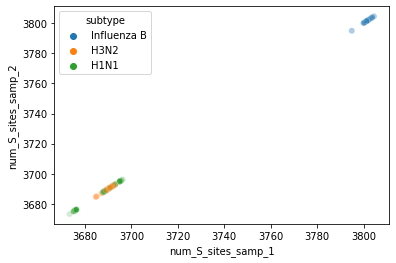

In [155]:
sns.scatterplot('num_S_sites_samp_1','num_S_sites_samp_2',hue='subtype',data=sample_comp, alpha=0.2)
# plt.gca().set_yscale('log')
# plt.gca().set_ylim(1e-6, 4e-4)
# plt.gca().set_xscale('log')
# plt.gca().set_xlim(1e-6, 4e-4)
sample_comp[['num_N_sites_samp_1','num_N_sites_samp_2','num_S_sites_samp_1','num_S_sites_samp_2']]
sample_comp['total_2'] = sample_comp.num_N_sites_samp_2 + sample_comp.num_S_sites_samp_2
sample_comp['total_1'] = sample_comp.num_N_sites_samp_1 + sample_comp.num_S_sites_samp_1
sample_comp[['subtypeLengths_1','total_1','total_2']]

In [156]:
testing_gene_columns = ['sampleID',
 'segment',
 'product',
 'piN_gene',
 'piS_gene',
 'N_sites_gene',
 'S_sites_gene',
 'subtype',
 'num_of_snps',
 'num_of_mixed_muts',
 'num_of_nonsynon_muts',
 'num_of_oof_muts',
 'num_of_synon_muts',
 'num_of_snps_gene',
 'num_of_nonsynon_muts_gene',
 'num_of_synon_muts_gene',
 'genelength']

gene_comp = genes1[testing_gene_columns].merge(genes2[testing_gene_columns], on=['sampleID','product'], suffixes=('_1','_2'))

/home/jlalli/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(1e-05, 0.01)

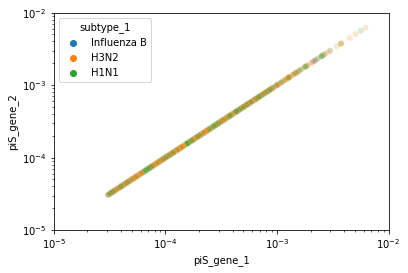

In [157]:
sns.scatterplot('piS_gene_1','piS_gene_2',hue='subtype_1',data=gene_comp, alpha=0.2)
plt.gca().set_yscale('log')
plt.gca().set_ylim(1e-5, 1e-2)
plt.gca().set_xscale('log')
plt.gca().set_xlim(1e-5, 1e-2)

In [158]:
# gene_comp.columns
# columns_in_presentation_order=['sampleID','product','piN_gene_1','piN_gene_2','piS_gene_1','piS_gene_2','N_sites_gene_1','N_sites_gene_2','S_sites_gene_1','S_sites_gene_2']
# gene_comp.loc[(gene_comp['product']=='PB2')&(~np.isclose(gene_comp.N_sites_gene_1.values, gene_comp.N_sites_gene_2.values, atol=.1)), ['num_of_snps_gene_1']+columns_in_presentation_order]


In [159]:
# importlib.reload(SNPGenie2)
# from SNPGenie2 import *
# del calcPi
# vcfDF = df
# gtf = gtfFiles[2]
# maf = 0.01
# rollingWindow=None
# synon_nonsynon=False
# # length = 
# refseq = consensusReferences[2]
# # def calcPi(vcfDF, gtf=None, length = None, refseq = None, maf = 0.01, rollingWindow=None, synon_nonsynon=False): 
# # Main body of program
# refseq = list(SeqIO.parse(refseq, 'fasta'))
# refseqArray, segStarts, segCoords = combine_segments(refseq)

# vcfDF = vcfDF.rename(columns={'sample':'sampleID'})
# #Now that we have our concatenated sequence with dictionary of start of each segment,
# #we can assemble a numpy representation of read counts aligned with our references
# piSNPs = vcfDF[['sampleID','product','segment','inGenePos','ref_nuc','alt_nuc','RD','AD','AAtype','pos']]
# piSNPs = piSNPs.sort_values(['sampleID','product','inGenePos'])

# piSNPs['pos'] = piSNPs.pos-1 #Apparantly this is taken straight from vcf, which is 1-indexed

# piSNPs = piSNPs.rename(columns={'pos':'inSegPos'})
# piSNPs['refAlleleFreq'] = piSNPs.RD/(piSNPs.RD+piSNPs.AD)

# # piSNPs = piSNPs.loc[(piSNPs.refAlleleFreq >= maf)&(piSNPs.refAlleleFreq <= (1-maf))]
# # Adjust SNPs to remove reads that contribute to minor variants below maf cutoff:
# piSNPs.loc[piSNPs.refAlleleFreq < maf, 'RD'] = 0
# piSNPs.loc[piSNPs.refAlleleFreq > (1-maf), 'AD'] = 0
# piSNPs['pos'] = piSNPs['product'] + ' '+ piSNPs['inGenePos'].astype(str)
# piSNPs[['sampleID','segment','pos','ref_nuc','alt_nuc','RD','AD','AAtype','inSegPos','refAlleleFreq']].set_index(['sampleID','pos'])
# piSNPs['inConcatPos'] = piSNPs.inSegPos

# for seg, offset in segStarts.items():
#     seg = seg.split('_')[-1]
#     piSNPs.loc[piSNPs.segment == seg,'inConcatPos'] += offset

# refSeqArrays, sampleKey = getRefSeqs(piSNPs, refseqArray)
# readCts, samplelist, poslist = turnDFintoReadCts(piSNPs, len(refseqArray))

# piMath = performPiCalc(readCts)

# perSitePi = calcPerSitePi(piMath)

# def calcPerSamplePi(sitePi, length=None, printit=None):
#     '''given numpy array of pi values, returns average per sample pi'''
#     if length is None:
#         length = sitePi.shape[1]
#     return np.nansum(sitePi,axis=1)/length

# perSitePi = np.nan_to_num(perSitePi)
# perSitePiDF = pd.DataFrame(perSitePi, index=sampleKey).dropna(how='all',axis=1)
# # perSitePiDF.columns = poslist
# perSitePiDF = perSitePiDF.stack().reset_index().rename(columns={'level_0':'sampleID','level_1':'inConcatPos',0:'pi'})
# perSitePiDF = piSNPs.merge(perSitePiDF, on=['sampleID','inConcatPos'])

# perSamplePi = calcPerSamplePi(perSitePi)
# perSamplePiDF = pd.DataFrame(perSamplePi, index=sampleKey, columns=['pi_sample'])


# #segment Pi
# perSegmentPiDF = pd.DataFrame(index=sampleKey)

# for seg, coords in segCoords.items():
#     perSegmentPiDF[seg] = pd.Series(calcPerSamplePi(perSitePi[:,coords[0]:coords[1]], length = coords[1]-coords[0]), index=sampleKey)
# perSegmentPiDF = perSegmentPiDF.stack().reset_index().rename(columns={'level_0':'sampleID','level_1':'segment',0:'pi_seg'})

# #coding region Pi/PiN/PiS
# codingCoords = parseGTF(gtf, segStarts)
# codingMasks = masksFromCodingCoordinates(codingCoords, segStarts, refSeqArrays)
# overlaps = calc_overlaps(codingCoords)

# genePis = pd.DataFrame(index=sampleKey)
# genePiN = pd.DataFrame(index=sampleKey)
# genePiS = pd.DataFrame(index=sampleKey)
# genePiN_sites = pd.DataFrame(index=sampleKey)
# genePiS_sites = pd.DataFrame(index=sampleKey)
# sample_piN_piS = pd.DataFrame(index=sampleKey, columns=['piN_sum','piN_sites','piS_sum','piS_sites']).fillna(0)


# for gene, mask in codingMasks.items():
#     # print ((readCts*mask[np.newaxis, :, np.newaxis]).sum())
#     geneSeqMaskedArray = np.ma.array(refSeqArrays, mask=np.broadcast_to(abs(mask-1), refSeqArrays.shape))
#     geneSeqArray = geneSeqMaskedArray.compressed().reshape(len(samplelist),-1)

#     synonFilter, nonSynonFilter, synonSiteFilter, nonSynonSiteFilter = generateSynonFilters(geneSeqArray)

#     gene_readCts = np.ma.array(readCts, mask=np.broadcast_to(abs(mask-1)[np.newaxis,:,np.newaxis], readCts.shape))
#     gene_readCts = gene_readCts.compressed().reshape(synonSiteFilter.shape)

#     SNP_freqs = read_cts_into_SNP_freqs(gene_readCts, geneSeqArray)
#     # remove start codon from math
#     if SNPGenie_1_rules:
#         nonSynonSiteFilter[:,0:3,:] = 1
#         synonSiteFilter[:,0:3,:] = 0

#     nonsynon_sites = (SNP_freqs*nonSynonSiteFilter).sum(axis=2)
#     synon_sites = (SNP_freqs*synonSiteFilter).sum(axis=2)
#     print('\n'+gene)
#     print(synon_sites.sum(axis=1)-genes.loc[genes['sampleID'].isin(samplelist) & (genes['product']==gene), 'S_sites_gene'].values)
#     print(np.sum(np.abs((apply_mask(refseqArray[np.newaxis,:], mask)==geneSeqArray)-1), axis=1))
#     piMathMaskedArray = np.ma.array(piMath, mask=np.broadcast_to(abs(mask-1)[np.newaxis,:,np.newaxis], piMath.shape))
#     genePiMathArray = piMathMaskedArray.compressed().reshape(synonFilter.shape)
#     genePerSitePi = calcPerSitePi(genePiMathArray)
#     nonSynonPerSitePi = calcPerSitePi(genePiMathArray*nonSynonFilter)
#     synonPerSitePi = calcPerSitePi(genePiMathArray*synonFilter)
#     genePis[gene] = calcPerSamplePi(genePerSitePi)
#     genePiN[gene] = calcPerSamplePi(nonSynonPerSitePi, length=nonsynon_sites.sum(axis=1), printit='PiN')
#     genePiS[gene] = calcPerSamplePi(synonPerSitePi, length=synon_sites.sum(axis=1),printit='PiS')
#     genePiN_sites[gene] = nonsynon_sites.sum(axis=1)
#     genePiS_sites[gene] = synon_sites.sum(axis=1)
#     # print(gene, genePiN[gene])
#     #And now do the same thing w/o overlapping regions to accurately determine whole-sample piN/piS
#     if gene in overlaps.keys():
#         synonFilter_no_overlap = remove_overlap_regions(overlaps, synonFilter)
#         nonSynonFilter_no_overlap = remove_overlap_regions(overlaps, nonSynonFilter)
#         seg = [seg for seg in codingCoords.keys() if gene in codingCoords[seg]][0]
#         keepers = get_nonoverlapping_in_gene_locations(seg, gene, codingCoords)

#         sample_piN_piS['piS_sites'] += synon_sites[:, keepers].sum(axis=1)
#         sample_piN_piS['piN_sites'] += nonsynon_sites[:, keepers].sum(axis=1)
# #             print(gene, 'nonsynon_sites', get_num_sites(nonSynonFilter_no_overlap))
#         nonSynonPerSitePi_no_overlap = calcPerSitePi(genePiMathArray*nonSynonFilter_no_overlap)
#         synonPerSitePi_no_overlap = calcPerSitePi(genePiMathArray*synonFilter_no_overlap)

#         sample_piN_piS['piS_sum'] += calcPerSamplePi(synonPerSitePi_no_overlap, length=1, printit='PiS')
#         sample_piN_piS['piN_sum'] += calcPerSamplePi(nonSynonPerSitePi_no_overlap, length=1, printit='PiN')
#     else:
#         if gene not in ['PA-X', 'PB1-F2', 'HA_antigenic', 'HA_nonantigenic']:
# #             print(gene, get_num_sites(nonSynonFilter_no_overlap)[0])
#             sample_piN_piS['piS_sites'] += synon_sites.sum(axis=1)
#             sample_piN_piS['piN_sites'] += nonsynon_sites.sum(axis=1)
#     #             print(gene, 'nonsynon_sites', num_nonsynon_sites)
#             sample_piN_piS['piS_sum'] += calcPerSamplePi(synonPerSitePi, length=1, printit='PiS')
#             sample_piN_piS['piN_sum'] += calcPerSamplePi(nonSynonPerSitePi, length=1, printit='PiN')


# sample_piN_piS['piN_sample'] = sample_piN_piS['piN_sum']/sample_piN_piS['piN_sites']
# sample_piN_piS['piS_sample'] = sample_piN_piS['piS_sum']/sample_piN_piS['piS_sites']
# perSamplePiDF = perSamplePiDF.join(sample_piN_piS)#[['piN_sample','piS_sample']])

# genePis = genePis.stack().reset_index().rename(columns={'level_0':'sampleID','level_1':'product',0:'pi'})
# genePiN = genePiN.stack().reset_index().rename(columns={'level_0':'sampleID','level_1':'product',0:'pi'})
# genePiS = genePiS.stack().reset_index().rename(columns={'level_0':'sampleID','level_1':'product',0:'pi'})
# genePiN_sites = genePiN_sites.stack().reset_index().rename(columns={'level_0':'sampleID','level_1':'product',0:'sites'})
# genePiS_sites = genePiS_sites.stack().reset_index().rename(columns={'level_0':'sampleID','level_1':'product',0:'sites'})
# genePiN = genePiN.merge(genePiN_sites, on=['sampleID','product'], how='left')
# genePiS = genePiS.merge(genePiS_sites, on=['sampleID','product'], how='left')

# genePis['type'] = 'pi'
# genePiN['type'] = 'piN'
# genePiS['type'] = 'piS'

# genePis = genePis.append(genePiN).append(genePiS)

# # Finally, just because somehow it hasn't happened yet in this code,
# # I'm going to make sure the segment is attached to the gene DF

# segDict = {gene:seg.split('_')[-1] for seg in codingCoords.keys() for gene in codingCoords[seg]}
# segDict['PB1-F2']='PB1'
# segDict['PA-X']='PA'
# segDict['HA_nonantigenic']='HA'
# segDict['HA_antigenic']='HA'
# segDict['NB'] = 'NA'
# segDict['BM2'] = 'MP'
# segDict['M2'] = 'MP'
# segDict['M1'] = 'MP'
# segDict['NEP'] = 'NS'
# segDict['NS1'] = 'NS'
# genePis['segment'] = genePis['product'].map(segDict)

# #     return perSamplePiDF, perSegmentPiDF, genePis, perSitePiDF


In [160]:
# for ref, df in SNPs.groupby('referenceFile'):
#     df = df.rename(columns={'sampleID':'sample'})
#     break

In [161]:
# SNP_freqs[np.where((SNP_freqs>0)&(SNP_freqs<1))]

In [162]:
# def apply_mask(array, mask):
#     masked_array = np.ma.array(array, mask=np.broadcast_to(abs(mask-1), array.shape))
#     return masked_array.compressed().reshape(array.shape[0],-1)



In [163]:
# # len(refseqArray)
# # SNPs.loc[(SNPs.sampleID=='18VR002051')&(SNPs.segment=='HA')&(SNPs.inGenePos==26)]
# geneSeqMaskedArray = np.ma.array(refSeqArrays, mask=np.broadcast_to(abs(mask-1), refSeqArrays.shape))
# geneSeqArray = geneSeqMaskedArray.compressed().reshape(len(samplelist),-1)
# refSeqArrays.shape

In [164]:
# np.where(((nonsynon_sites%1)!=0)&((nonsynon_sites%1)!=1/6)&((nonsynon_sites%1)!=2/6)&((nonsynon_sites%1)!=3/6)&((nonsynon_sites%1)!=4/6)&((nonsynon_sites%1)!=5/6))

In [165]:
def checkForDuplicateColumnsPostMerge(df, suffixes=('_x','_y')):
    '''if an index/contact or x/y column pairing are identical, unify them into one column.
       Keeps np.nan values seperate.'''
    columns = [column[:-len(suffixes[0])] for column in df.columns if column[-len(suffixes[0]):]==suffixes[0]]
    
    merged=[]
    kept = []
    for column in columns:
        columna = column+suffixes[0]
        columnb = column+suffixes[1]
                
        a=df[columna].values
        b=df[columnb].values
        
        if (df[columna].dtype.kind in 'biufc') and (df[columnb].dtype.kind in 'biufc'):
            theyAreEqual = ((a==b)|np.isclose(a,b,atol=1E-4)|np.isclose(b,a,atol=1E-4))
        else:
            theyAreEqual = ((a==b))
        if theyAreEqual.all():
            df = df.rename(columns={columna:column}).drop(columns=[columnb])
            merged.append(column)
        
        else:
            kept.append(column)
    
    print('merged:')
    print (merged)
    print('kept:')
    print(kept)
    return df

def updateDuplicateColumnsPostMerge(df, exclude=[], suffixes=('_x','_y')):
    '''if an index/contact or x/y column pairing are identical except for na values, unify them into one column.
       Assumes np.nan values are artifacts, and fills in values if one column has them'''
#     suffixes = ('_index','_contact')
    columns = [column[:-len(suffixes[0])] for column in df.columns if column[-len(suffixes[0]):]==suffixes[0]]
#     for column in df.columns:
#         print (column)
#         print (f'column:{column[:-len(suffixes[0])]}')
#         print (f'matching end: {column[-len(suffixes[0]):]}')
    merged=[]
    kept = []
    for column in columns:
        columna = column+suffixes[0]
        columnb = column+suffixes[1]
                
        a=df[columna].values
        b=df[columnb].values
        
        if (df[columna].dtype.kind in 'biufc') and (df[columnb].dtype.kind in 'biufc'):
            theyAreEqual = ((a==b)|pd.isna(a)|pd.isna(b)|np.isclose(a,b,atol=1E-4)|np.isclose(b,a,atol=1E-4))
        else:
            theyAreEqual = ((a==b)|pd.isna(a)|pd.isna(b))
        
        if 'AAstr' in column:
            print (((a==b)|pd.isna(a)|pd.isna(b)).all())
            print (df[((a!=b)&pd.notna(a)&pd.notna(b))])
        
        if theyAreEqual.all():
            df[columna].update(df[columnb])
            df = df.rename(columns={columna:column}).drop(columns=[columnb])
            merged.append(column)
        else:
            kept.append(column)
                
    print('updated:')
    print (merged)
    print('untouched:')
    print(kept)
    return df

In [166]:
### Make transmission DF

transmissionPairs = []
indexsamples=[]
problems = []
tosequence = pd.DataFrame()

print ('loading pre-calculated sample distances...')
distanceDF = pd.DataFrame()
for distancefile in distancefiles:
    tmp = pd.read_csv(distancefile, **read_tsv_args).set_index('Unnamed: 0')
    distanceDF = distanceDF.append(tmp, sort=True)

for i, df in subjects.groupby('household'):
    indexcase = df.loc[df.isIndexCase]
    if len(indexcase) == 0:
        continue
   
    indexSample = indexcase.day0_sample.values[0]
    
    for _, pt in df.iterrows():
        if pd.notna(pt.day0_sample) & pd.notna(pt.day7_sample):    
            transmissionPairs.append({'index':pt.day0_sample,'contact':pt.day7_sample, 'kind':'self','distance':distanceDF.at[pt.day0_sample,pt.day7_sample]})
        if not pt.isIndexCase and pd.notna(indexSample):
            if pd.notna(pt.day0_sample):
                transmissionPairs.append({'index':indexSample,'contact':pt.day0_sample, 'kind':'transmission','distance':distanceDF.at[indexSample,pt.day0_sample]})
            if pd.notna(pt.day7_sample):
                transmissionPairs.append({'index':indexSample,'contact':pt.day7_sample, 'kind':'transmission','distance':distanceDF.at[indexSample,pt.day7_sample]})

transmissionPairs = pd.DataFrame(transmissionPairs).dropna()
transmissionPairs = transmissionPairs.merge(samples.set_index('sampleID'), how='left', left_on=['index'], right_index=True, suffixes=('','_index'))

transmissionPairs = transmissionPairs.merge(samples.set_index('sampleID'), how='left', left_on=['contact'], right_index=True, suffixes=('_index','_contact'))
transmissionPairs = checkForDuplicateColumnsPostMerge(transmissionPairs,suffixes=('_index','_contact'))


loading pre-calculated sample distances...
merged:
['subtype', 'mapped', 'decimalDate', 'season', 'household', 'taken_on_hh_infection_day', 'clade', 'subclade', 'subtypeLengths']
kept:
['ptID', 'CT', 'sample_date', 'seasonalDate', 'week', 'day0_or_day7_sample', 'participant_ID', 'age', 'gender', 'time_of_symptom_onset', 'recieved_flu_vaccine', 'school', 'jackson_score', 'antipyretic_use', 'flu_antiviral_treatment', 'school_absence', 'number_in_household', 'recent_travel', 'isIndexCase', '%ofHHinfected', 'age_category', 'days_since_symptom_onset', 'symptom_severity', 'saw_a_doctor', 'num_of_snps', 'num_of_mixed_muts', 'num_of_nonsynon_muts', 'num_of_oof_muts', 'num_of_synon_muts', 'Xue_divergence', 'Xue_mixed_divergence', 'Xue_nonsynon_divergence', 'Xue_oof_divergence', 'Xue_synon_divergence', 'pi_sample', 'num_N_sites_samp', 'num_S_sites_samp', 'piN_sample', 'piS_sample', 'snps_per_day_samp', 'synon_snps_per_day_samp', 'nonsynon_snps_per_day_samp', 'oof_snps_per_day_samp', 'mutation_ra

In [167]:
# indextp = transmissionPairs[['index','contact']].merge(SNPs.rename(columns={'sampleID':'index'}),on='index', how='left')
# contacttp = transmissionPairs[['index','contact']].merge(SNPs.rename(columns={'sampleID':'contact'}),on='contact', how='left')

In [168]:
indextp = transmissionPairs[['index','contact']].merge(SNPs.rename(columns={'sampleID':'index'}),on='index', how='left')
contacttp = transmissionPairs[['index','contact']].merge(SNPs.rename(columns={'sampleID':'contact'}),on='contact', how='left')

indextp['SNPkey'] = indextp['index'] + ':' + indextp['contact'] + ':'+indextp.segment+':'+indextp.pos.astype(str)+':'+indextp.alt_nuc+':'+indextp['product'].fillna('OORF')
contacttp['SNPkey'] = contacttp['index'] + ':' + contacttp['contact'] + ':'+contacttp.segment+':'+contacttp.pos.astype(str)+':'+contacttp.alt_nuc+':'+contacttp['product'].fillna('OORF')

assert len(indextp.SNPkey.unique())==len(indextp)
assert len(contacttp.SNPkey.unique())==len(contacttp)

tSNPs = indextp.merge(contacttp, on='SNPkey', how='outer', suffixes=('_index','_contact'))
# tSNPs.loc[tSNPs.index_index != tSNPs.index_contact, ['index_index','index_contact','contact_index','contact_contact']]
tSNPs = updateDuplicateColumnsPostMerge(tSNPs, suffixes=('_index','_contact'))
tSNPs = tSNPs.drop_duplicates()


True
Empty DataFrame
Columns: [index, contact, chrom, pos, ref_nuc, alt_nuc, qual, GT_index, GQ_index, SDP_index, depth_index, RD_index, AD_index, SNP_frequency_index, PVAL_index, RBQ_index, ABQ_index, RDF_index, RDR_index, ADF_index, ADR_index, product, inGenePos, refAA, codon, altAA, AAstr_index, AAtype_index, referenceFile_index, segment_index, subtype_index, CT_index, sample_date_index, decimalDate_index, seasonalDate_index, week_index, season_index, household_index, participant_ID_index, age_index, gender_index, time_of_symptom_onset_index, recieved_flu_vaccine_index, school_index, jackson_score_index, antipyretic_use_index, flu_antiviral_treatment_index, school_absence_index, number_in_household_index, recent_travel_index, isIndexCase_index, %ofHHinfected_index, age_category_index, days_since_symptom_onset_index, symptom_severity_index, saw_a_doctor_index, taken_on_hh_infection_day_index, clade_index, subclade_index, transformed_frequency_index, log_transformed_frequency_index, r

In [169]:
tSNPs.SNP_frequency_index.max()

1.0

In [170]:
transmissionSNPs = tSNPs.merge(transmissionPairs, on=['index','contact'])#.rename(columns={'subtype_y':'subtype'})

transmissionSNPs = updateDuplicateColumnsPostMerge(transmissionSNPs, suffixes=('_x','_y'))

updated:
['subtype', 'CT_index', 'sample_date_index', 'decimalDate', 'seasonalDate_index', 'week_index', 'season', 'household', 'participant_ID_index', 'age_index', 'gender_index', 'time_of_symptom_onset_index', 'recieved_flu_vaccine_index', 'school_index', 'jackson_score_index', 'antipyretic_use_index', 'school_absence_index', 'isIndexCase_index', 'age_category_index', 'days_since_symptom_onset_index', 'symptom_severity_index', 'saw_a_doctor_index', 'taken_on_hh_infection_day', 'clade', 'subclade', 'num_N_sites_samp_index', 'num_S_sites_samp_index', 'CT_contact', 'sample_date_contact', 'seasonalDate_contact', 'week_contact', 'participant_ID_contact', 'age_contact', 'gender_contact', 'time_of_symptom_onset_contact', 'recieved_flu_vaccine_contact', 'school_contact', 'jackson_score_contact', 'antipyretic_use_contact', 'school_absence_contact', 'isIndexCase_contact', 'age_category_contact', 'days_since_symptom_onset_contact', 'symptom_severity_contact', 'saw_a_doctor_contact', 'num_N_site

In [171]:
len(tSNPs.loc[np.abs(tSNPs.SNP_frequency_contact-tSNPs.SNP_frequency_index)>0.30])# transmissionSNPs.loc[transmissionSNPs.AAstr_index != transmissionSNPs.AAstr_contact,['AAstr_index','AAstr_contact']]

13

In [172]:
transmissionSNPs.SNP_frequency_index.max()

1.0

In [173]:
# SNPs.loc[(SNPs.sampleID=='19VR004458')&(SNPs.segment=='HA')]
# withMixedRemoved[['index','contact','refAA','codon','altAA_index','antigenic_product']].loc[withMixedRemoved.refAA!=withMixedRemoved.altAA_index].sort_values('codon')

In [174]:
# #Figuring out where G145S and I230V went
# hhs = list()
# ptIDs = list()
# for hh, df in subjects.groupby('household'):
#     if len(df)>=3:
#         hhs.append(hh)
#         for id in df['participant_ID']:
#             ptIDs.append(id)
# sampleIDs = list(samples.loc[samples.participant_ID.isin(ptIDs), 'sampleID'])
# SNPs.loc[(SNPs.codon==245)&(SNPs['segment']=='HA')&(SNPs['sampleID'].isin(sampleIDs))]
# sampleIDs = ['19VR006682','19VR007474']
# ptIDs = [1818.0,1817.2]
# hh = 1817

# # transmissionPairs.loc[(transmissionPairs['index'].isin(samps))|(transmissionPairs['contact'].isin(samps))]
# contactsOfInterest = ['19VR006682','19VR007474']
# indexOfInterest = ['19VR006679']
# householdOfInterest = 1817
# subjects.loc[subjects.household == hh, 'isIndexCase']
# reffiles
# len(_consensus_noambig.fasta)

In [175]:
#Calculate bottleneck size:
def getReadDepth(sample, segment, pos, alt):
    reffile = SNPs.loc[SNPs['sampleID']==sample, 'referenceFile'].iloc[0]
    ref = reffile.split('/')[5]
    refbase = reffile.split('/')[-1].split('_')
    if 'Hong_Kong' in reffile:
        chrom = hongkongContigs[segment]
    elif 'Michigan' in reffile:
        chrom = '_'.join(refbase[:-4])+'_'+segment
    elif refbase[-3] in ['17','18','19']:
        chrom = '_'.join(refbase[:-3])+'_'+segment
    else:
        chrom = '_'.join(refbase[:-2])+'_'+segment

    bamfile = '/'.join(reffile.split('/')[0:6])+'/'+'_'.join(reffile.split('/')[-1].split('_')[:-2])+'/map_to_consensus/'+sample+'.bam'
    pos = int(pos)
    sam = pysam.AlignmentFile(bamfile, "rb")
    try:
        pileup = sam.pileup(contig=chrom, start=pos, end=pos+1, truncate=True, stepper="nofilter")
    except:
        print (sam.references)
        print (chrom)
        print (reffile)
        print (ref)
        raise
        
    column = next(pileup)
    column.set_min_base_quality(30)
    try:
        bases = column.get_query_sequences(mark_matches=True)
        altreads = bases.count(alt.lower()) + bases.count(alt.upper())
    except:
        altreads = 0
    frequency = round(altreads/column.get_num_aligned(),4)
    depth = column.get_num_aligned()
    return frequency, altreads, depth

def makeBottleneckInputFile(i, pairing):
    index, contact = pairing
    indexdata = SNPs.loc[SNPs['sampleID'] == index, ['segment', 'pos', 'SNP_frequency', 'AD', 'depth','alt_nuc']].groupby(['segment','pos']).first()
    contactdata = SNPs.loc[SNPs['sampleID'] == contact, ['segment', 'pos', 'SNP_frequency', 'AD', 'depth','alt_nuc']].groupby(['segment','pos']).first()
    export = indexdata.merge(contactdata, on=['segment','pos'], how='left', suffixes=('_index','_contact'))
    for ix, row in export.iterrows():
        if pd.isna(row.depth_contact):
            export.loc[ix,['SNP_frequency_contact','AD_contact','depth_contact']] = getReadDepth(contact, ix[0],ix[1],row.alt_nuc_contact)
    export.fillna(0)
    filename = figures+'/bottleneck_figures/'+index+'_'+contact+'.txt'
    export.to_csv(filename[:-4]+'.tsv', sep='\t')
    export = export[['SNP_frequency_index','SNP_frequency_contact','depth_contact','AD_contact']].round(4)
    export = export.loc[(0.99 > export.SNP_frequency_index) & (export.SNP_frequency_index > 0.01)]
    export = export.loc[~export.duplicated()]
    bottleneckpairingDF.at[i, 'supportingSNPs'] = len(export)
    export.to_csv(filename, sep='\t', header=False, index=False)
    return filename

def koelleBottleneck(filename):
    #print (filename)
    bottleneckregex = r"(?:size\n)(\d*)"
    lowerboundregex = r"(?:left bound\n)(\d*)"
    upperboundregex = r"(?:right bound\n)(\d*)"
    pair = filename.split('.')[0].split('/')[-1]
    #print (f'Getting bottleneck of transmission pair {pair}')
    with open(f"{figures}/betabinomialResults_exact.log", 'a+') as outputFile:
        cmd = f'Rscript /d/orchards/betaBinomial/Bottleneck_size_estimation_exact.r --file {filename} --plot_bool TRUE --var_calling_threshold {SNP_frequency_cutoff} --Nb_min 1 --Nb_max 200 --confidence_level .95'
        outputFile.write(f"\n\n--------------------\n\n{pair}\n\n")
        print (cmd)
        results = subprocess.run(cmd.split(" "), text=True, stdout=subprocess.PIPE)
        try:
            os.rename('/mnt/d/orchards/betaBinomial/exact_plot.svg', f'{figures}/{pair}_bottleneckplot_exact.svg')
        except:
            print (f'{pair} doesn\'t have an exact plot svg')
        bottleneck = int(re.search(bottleneckregex, results.stdout).group(1))
        lowerbound = int(re.search(lowerboundregex, results.stdout).group(1))
        upperbound = int(re.search(upperboundregex, results.stdout).group(1))
        print (f'{pair}: {lowerbound} |-- {bottleneck} --| {upperbound}')
    return pair, bottleneck, lowerbound, upperbound

if recalc_bottlenecks: #calc bottleneck
    bottleneckpairingDF = transmissionPairs[['index','contact']]
    bottleneckpairingDF['bottleneck_size'] = 0
    bottleneckpairingDF['bottleneck_min'] = 0
    bottleneckpairingDF['bottleneck_max'] = 0
    bottleneckpairingDF['supportingSNPs'] = 0
    
    pairingfiles = []
    for i, row in tqdm(bottleneckpairingDF.iterrows(),total=len(bottleneckpairingDF)):
        pairing = (row['index'],row.contact)
        pairingfile = makeBottleneckInputFile(i, pairing)
        pairingfiles.append(pairingfile)

    for result in [koelleBottleneck(pairingfile) for pairingfile in pairingfiles]:
        pair, bottleneck, lowerbound, upperbound = result
        index, contact = tuple(pair.split('_'))
        bottleneckpairingDF.loc[(bottleneckpairingDF['index'] == index) & (bottleneckpairingDF['contact'] == contact), ['bottleneck_size', 'bottleneck_min', 'bottleneck_max']] = bottleneck, lowerbound, upperbound

#     with mp.Pool(6) as pool:
#         for result in pool.imap_unordered(koelleBottleneck, pairingfiles):
#             pair, bottleneck, lowerbound, upperbound = result
#             print (result)
#             index, contact = tuple(pair.split('_'))
#             bottleneckpairingDF.loc[(bottleneckpairingDF['index'] == index) & (bottleneckpairingDF['contact'] == contact), ['bottleneck_size', 'bottleneck_min', 'bottleneck_max']] = bottleneck, lowerbound, upperbound


    
    bottleneckpairingDF.to_csv(figures+'/bottleneckpairingDF.tsv', sep='\t', index=False)
else:
    bottleneckpairingDF = pd.read_csv(figures+'/bottleneckpairingDF.tsv', **read_tsv_args)

<ipython-input-175-7da69faea119>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottleneckpairingDF['bottleneck_size'] = 0
<ipython-input-175-7da69faea119>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottleneckpairingDF['bottleneck_min'] = 0
<ipython-input-175-7da69faea119>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Rscript /d/orchards/betaBinomial/Bottleneck_size_estimation_exact.r --file /mnt/d/orchards/h1n1/figures/bottleneck_figures/17VR005325_17VR005779.txt --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 200 --confidence_level .95


AttributeError: 'NoneType' object has no attribute 'group'

In [ ]:
if len([column for column in transmissionPairs.columns if '_x' in column])>0:
    print (transmissionPairs.columns)
    raise Exception

In [ ]:
transmissionSNPs.SNP_frequency_index.max()

In [ ]:
transmissionPairs = transmissionPairs.merge(bottleneckpairingDF, on=['index','contact'])
# print(transmissionPairs.columns)
transmissionPairs = checkForDuplicateColumnsPostMerge(transmissionPairs,suffixes=('_x','_y'))
# tocombine = ['household','number_in_household','week','clade','decimalDate','seasonalDate']
# todelete = ['mapped_index','mapped_contact']
# for column in tocombine:
#     transmissionPairs[column+'_index'].update(transmissionPairs[column+'_contact'])
#     transmissionPairs = transmissionPairs.drop(column+'_contact', axis=1).rename(columns={column+'_index':column})

# transmissionPairs = transmissionPairs.drop(columns = todelete)

In [ ]:
#Pre-calculate change in variables across transmission
# columnstodelta = set()
# for column in transmissionPairs.columns:
#     if '_index' in str(column):
#         columnstodelta.add(column.replace('_index',''))
#     if transmissionPairs[column].dtype != 'datetime64[ns]':
#         try:
#             transmissionPairs[column] = pd.to_numeric(transmissionPairs[column])
#         except:
#             pass
# print ('merging columns')
# for column in columnstodelta:
#     if transmissionPairs[column+'_index'].dtype == 'datetime64[ns]':
#         transmissionPairs[column+'_difference'] = (transmissionPairs[column+'_contact']-transmissionPairs[column+'_index']).dt.days
#     else:
#         try:
#             transmissionPairs[column+'_difference'] = transmissionPairs[column+'_contact'] - transmissionPairs[column+'_index']
#         except:
#             pass


        
# toDrop = ['isIndexCase_index','isIndexCase_contact','%ofHHinfected_contact','%ofHHinfected_difference','participant_ID_difference']
# toRename = {'ofHHinfected_index':'ofHHinfected'}

# transmissionPairs = transmissionPairs.drop(toDrop, axis=1).rename(columns=toRename)
#(transmissionPairs.time_of_symptom_onset_contact - transmissionPairs.index_symptom_start_date_contact).dt.days
# transmissionPairs = checkForDuplicateColumnsPostMerge(transmissionPairs,suffixes=('_index','_contact'))


In [ ]:
transmissionSNPs.SNP_frequency_index.max()

In [ ]:
transmissionSegments = transmissionPairs.merge(segments, right_on=['sampleID'], left_on=['index'], how='left', suffixes=('','_index'))
transmissionSegments = transmissionSegments.merge(segments,left_on=['contact','segment'], right_on=['sampleID', 'segment'], how='left', suffixes=('_index','_contact'))
transmissionSegments = transmissionSegments.loc[:,~transmissionSegments.columns.duplicated()]
todelete = ['mapped_index','mapped_contact','sampleID_index','sampleID_contact']


transmissionSegments = transmissionSegments.drop(columns = todelete)
transmissionSegments = checkForDuplicateColumnsPostMerge(transmissionSegments,suffixes=('_index','_contact'))


In [ ]:
# sampleSpecificSNPcols = ['index','contact','ABQ','AD','ADF','ADR','depth','SNP_frequency','GQ','GT','PVAL','RBQ','RD','RDF','RDR','SDP','qual','transformed_frequency','log_transformed_frequency','pi_nucleotide']

# tP_mergeOnCols = [column for column in transmissionPairs.columns if column not in SNPs.columns]
# common_cols = [column for column in SNPs.columns if column in samples.columns]
# SNPs_mergeOnCols = [column for column in SNPs.columns if column not in sampleSpecificSNPcols+common_cols]

# a = transmissionPairs[['index','contact']].merge(SNPs,how='left',left_on='index',right_on='sampleID')
# b = transmissionPairs[['index','contact']].merge(SNPs,how='left',left_on='contact',right_on='sampleID')

# a = a.drop(columns=common_cols)
# b = b.drop(columns=common_cols)

# codingA = a.loc[~(a.AAtype=='Out of reading frame')]
# codingB = b.loc[~(b.AAtype=='Out of reading frame')]
# NC_A = a.loc[(a.AAtype=='Out of reading frame')]
# NC_B = b.loc[(b.AAtype=='Out of reading frame')]


# t = codingA.merge(codingB, on=['index','contact','product','inGenePos'], how='outer',suffixes=('_index','_contact'))
# OORFtSNPs = NC_A.merge(NC_B, on=['index','contact','segment','pos'], how='outer',suffixes=('_index','_contact'))
# transmissionSNPs = t.loc[~((t.alt_nuc_index != t.alt_nuc_contact)&pd.notna(t.alt_nuc_index)&pd.notna(t.alt_nuc_contact))]

# transmissionSNPs = updateDuplicateColumnsPostMerge(transmissionSNPs,suffixes=('_index','_contact'))
# OORFtSNPs = updateDuplicateColumnsPostMerge(OORFtSNPs,suffixes=('_index','_contact'))


# # print([col for col in t.columns if 'pos' in col])



# transmissionSNPs = transmissionSNPs.append(OORFtSNPs)

# # print(transmissionSNPs['pos'])







# #The rolling columns are not always identical due to sampling taking place during different periods.
# #The differences are too large to just ignore, but too small to actually matter. (on the order of 1E-2).
# #So I'll merge all columns with rolling in them by taking the average
# rollingcolumns = [column for column in transmissionSNPs.columns if (('rolling' in column) or ('Globally' in column)) and ('_index' in column)]
# for column in rollingcolumns:
#     iColumn = column
#     cColumn = column[:-6]+'_contact'
#     newcolumn = column[:-6]
#     transmissionSNPs[iColumn].update(transmissionSNPs[cColumn])
#     transmissionSNPs[newcolumn] = transmissionSNPs[[iColumn,cColumn]].mean(axis=1)
#     transmissionSNPs = transmissionSNPs.drop(columns=[iColumn,cColumn])

In [ ]:
# transmissionSNPs = transmissionSNPs.merge(transmissionPairs, on=['index', 'contact'], how='left')

In [ ]:
# c[['index','contact','segment','pos','SNP_frequency_index','SNP_frequency_contact','CT_index']]

In [ ]:
# shortIndexSnps = indexSNPs[['index','segment','pos','SNP_frequency']]
# shortContactSnps = contactSNPs[['contact','segment','pos','SNP_frequency']]
# pairing = transmissionPairs[['index','contact']]
# tmp = shortIndexSnps.merge(pairing, on='index')
# shortContactSnps.merge(tmp, on=['contact', 'segment','pos'],how='outer',suffixes=('_index','_contact'))

# sharedColumns = [column for column in transmissionPairs.columns if column in SNPs]
# snpSpecifyingColumns = ['index','contact','segment','antigenic_site','antigenic_product','chrom','referenceFile','codon', 'AAstr', 'AAtype', 'alt_nuc', 'altAA', 'product', 'inGenePos', 'pos', 'ref_nuc', 'refAA', 'rolling_AA_mean_global_freq','rolling_AA_max_global_freq','rolling_DNA_mean_global_freq','rolling_DNA_max_global_freq','rolling_AA_mean_global_freq_following_year','rolling_AA_max_global_freq_following_year','rolling_DNA_mean_global_freq_following_year','rolling_DNA_max_global_freq_following_year','AAobservedGlobally','AAobservedGloballyFollowingSeason','DNAobservedGlobally','DNAobservedGloballyFollowingSeason','class_of_mutation_at_site']

# a = indexSNPs.merge(pairing)

# b = contactSNPs.merge(pairing)
# c = a.merge(b,on=snpSpecifyingColumns+sharedColumns,how='outer',suffixes=('_index','_contact'))
# print(c.select_dtypes(include='object').columns)
# c = c.apply(pd.to_numeric, c.select_dtypes(include='object').columns,errors='ignore')
# transmissionPairs = transmissionPairs.apply(pd.to_numeric, transmissionPairs.select_dtypes(include='object').columns,errors='ignore')
# sharedColumns = [column for column in transmissionPairs.columns if column in c.columns]
# # print(sharedColumns[:3])
# # c[sharedColumns[:3]].dtypes
# # a.dtypes
# c.merge(transmissionPairs, on=sharedColumns)

In [ ]:
# 

# transmissionSNPs = transmissionSegments.merge(SNPs, left_on=['index','segment'], right_on=['sampleID', 'segment'], how='left')
# transmissionSNPs = transmissionSNPs.merge(SNPs, left_on=['contact','segment']+snpSpecificColumns, right_on=['sampleID', 'segment']+snpSpecificColumns, how='left', suffixes=('_index','_contact'))

# #If there's a segment with no SNPs, then this merge leaves a blank entry with only the segment information filled in.
# #This line of code removes those entries.
# # transmissionSNPs = transmissionSNPs.loc[pd.notna(transmissionSNPs.SNP_frequency_index) & pd.notna(transmissionSNPs.SNP_frequency_contact)]

# transmissionSNPs = transmissionSNPs.drop(columns=['sampleID_index','sampleID_contact'])

In [ ]:
# tmp = [column for column in transmissionColumns if column not in ['index','contact']]
# # list(indexSNPs.merge(contactSNPs, on=['index','contact']+snpSpecificColumns+transmissionColumns[40:41], how='outer',suffixes=('_index','_contact')).columns)
# transmissionColumns[:6] #6,13:16
# tmpcol = [column for column in indexSNPs.columns if column in contactSNPs.columns]
# indexSNPs.merge(contactSNPs, on=tmpcol, how='outer',suffixes=('_index','_contact'))

In [ ]:
# transmissionSNPs.iloc[1388:1390][['index','contact']]
# print(list(transmissionPairs.contact))
# SNPs.loc[SNPs.sampleID=='19VR009188']
transmissionSNPs.SNP_frequency_index.max()
for sample in list(transmissionPairs.contact):
    print(f'{sample}: {len(SNPs.loc[(SNPs.sampleID==sample)&(SNPs.SNP_frequency < 0.99)&(SNPs.SNP_frequency > 0.01)])}')
    
# sns.swarmplot(SNPs.loc[(SNPs.SNP_frequency < 0.98)&(SNPs.SNP_frequency > 0.02)].groupby('sampleID').count())

In [ ]:
def getReadDepthWrapper(row):
    if pd.isna(row.SNP_frequency_index):
        try:
            result = getReadDepth(row['index'], row.segment,row.pos,row.alt_nuc)+(row.SNP_frequency_contact,row.AD_contact,row.depth_contact)
        except:
            print (row[['index','contact','segment','pos','SNP_frequency_index','SNP_frequency_contact']])
            raise
    elif pd.isna(row.SNP_frequency_contact):
        try:
            result = (row.SNP_frequency_index,row.AD_index,row.depth_index)+getReadDepth(row.contact, row.segment,row.pos,row.alt_nuc)
        except:
            print (row)  
            raise
    else:
        result = (row.SNP_frequency_index,row.AD_index,row.depth_index,row.SNP_frequency_contact,row.AD_contact,row.depth_contact)
        
    if len(result) != 6:
#         print (row)
        print (result)
    return result

# # transmissionSNPs[['SNP_frequency_index','AD_index','depth_index','SNP_frequency_contact','AD_contact','depth_contact']]
# # getReadDepthWrapper(transmissionSNPs.iloc[0])
# transmissionSNPs['pos']

In [ ]:
min_coverage = 100

In [ ]:
#I'd like to fill in my transmissionSNP depth data. It will make computing bottlenecks more straightforward, among other things.
#I'm doing this by applying a function to all transmission SNPs that:
#a) determines whether the index or contact frequency/AD/depth info contains nans
#b) calls getReadDepth on the appropriate information to fill in the nans
#c) returns the original data with getReadDepth's results filling in the nans
columnsToUpdate = ['SNP_frequency_index','AD_index','depth_index','SNP_frequency_contact','AD_contact','depth_contact']
# tmp = transmissionSNPs.apply(getReadDepthWrapper,axis=1)

In [ ]:
tmp = pd.DataFrame(transmissionSNPs.apply(getReadDepthWrapper,axis=1).to_list())

#It makes me nervous that I'm applying a function to all my values which in theory could change all my SNP values.
#So I'm going to do this carefully. I will apply the function and create a separate data frame, preserving my original data.
#I then assert that the data that I am about to change is either a) identical to the new data, or b) nan
a = transmissionSNPs[columnsToUpdate].to_numpy()
b = tmp.to_numpy()

assert ((a==b) | np.isnan(a)).all()

#Once that's confirmed, I replace my original data with my updated data
transmissionSNPs[columnsToUpdate] = b

# To save time, I do not get reference SNP depth, just total depth and alt depth. 
# Both are calculated w/ quality minimums, so ref_depth is just total depth - alt depth
# I'm only changing values that are nan, otherwise I will use the info previously gathered
transmissionSNPs.loc[transmissionSNPs.RD_index.isna(), 'RD_index'] = transmissionSNPs.loc[transmissionSNPs.RD_index.isna(), 'depth_index']-transmissionSNPs.loc[transmissionSNPs.RD_index.isna(), 'AD_index']
transmissionSNPs.loc[transmissionSNPs.RD_contact.isna(), 'RD_contact'] = transmissionSNPs.loc[transmissionSNPs.RD_contact.isna(), 'depth_contact']-transmissionSNPs.loc[transmissionSNPs.RD_contact.isna(), 'AD_contact']

assert(len(transmissionSNPs.loc[transmissionSNPs.RD_index.isna()])==0)
assert(len(transmissionSNPs.loc[transmissionSNPs.RD_contact.isna()])==0)
assert(len(transmissionSNPs.loc[transmissionSNPs.AD_index.isna()])==0)
assert(len(transmissionSNPs.loc[transmissionSNPs.AD_contact.isna()])==0)

#Now that I have completely filled in depth data, make sure both index and contact meet minimum coverage requirements
min_coverage = 100
transmissionSNPs = transmissionSNPs.loc[(transmissionSNPs.depth_index >= min_coverage)&(transmissionSNPs.depth_contact >= min_coverage)]

In [ ]:
#And now that my nans are filled in, I calculated differences in snp frequency
transmissionSNPs['abs_SNP_frequency_difference'] = np.abs(transmissionSNPs.SNP_frequency_contact-transmissionSNPs.SNP_frequency_index)
transmissionSNPs['SNP_frequency_directional_change'] = transmissionSNPs.SNP_frequency_contact-transmissionSNPs.SNP_frequency_index
transmissionSNPs['log_abs_SNP_frequency_difference'] = np.log10(transmissionSNPs.abs_SNP_frequency_difference).fillna(0).replace((np.inf), 0).replace((-np.inf),0)

In [ ]:
len(transmissionSNPs.loc[transmissionSNPs.abs_SNP_frequency_difference>0.99])
# transmissionSNPs.loc[(transmissionSNPs.SNP_frequency_contact>0.1)&(transmissionSNPs.SNP_frequency_index<0.1),['SNP_frequency_index','SNP_frequency_contact']]

# transmissionSNPs.SNP_frequency_index.max()

In [ ]:
print ('saving transmission pairs...')
transmissionPairs.to_csv(basename+'/transmissionPairs.tsv', sep='\t', index=False)
print ('saving transmission segments...')
transmissionSegments.to_csv(basename+'/transmissionSegments.tsv', sep='\t', index=False)
print ('saving transmission SNPs...')
transmissionSNPs.to_csv(basename+'/transmissionSNPs_lenient_filter.gz', sep='\t', index=False)

In [ ]:
# unfilteredSNPs = pd.read_csv(basename+'/SNPs_unfiltered.gz',**read_tsv_args)
# unfilteredtSNPs = pd.read_csv(basename+'/transmissionSNPs_unfiltered.gz',**read_tsv_args)
# filteredSNPs = pd.read_csv(basename+'/SNPs_lenient_filter.gz',**read_tsv_args)
# filteredtSNPs  = pd.read_csv(basename+'/transmissionSNPs_lenient_filter.gz',**read_tsv_args)

# filteredSNPs2 = pd.read_csv(basename+'/SNPs_lenient_filter.gz',**read_tsv_args)
# filteredtSNPs2  = pd.read_csv(basename+'/transmissionSNPs_lenient_filter.gz',**read_tsv_args)

# unfilteredtSNPs['abs_SNP_frequency_difference'] = np.abs(unfilteredtSNPs.SNP_frequency_contact-unfilteredtSNPs.SNP_frequency_index)
# unfilteredtSNPs['log_abs_SNP_frequency_difference'] = np.log10(unfilteredtSNPs.abs_SNP_frequency_difference)

# filteredtSNPs['abs_SNP_frequency_difference'] = np.abs(filteredtSNPs.SNP_frequency_contact-filteredtSNPs.SNP_frequency_index)
# filteredtSNPs['log_abs_SNP_frequency_difference'] = np.log10(filteredtSNPs.abs_SNP_frequency_difference).replace(-np.inf, -100)

# filteredtSNPs2['abs_SNP_frequency_difference'] = np.abs(filteredtSNPs2.SNP_frequency_contact-filteredtSNPs2.SNP_frequency_index)
# filteredtSNPs2['log_abs_SNP_frequency_difference'] = np.log10(filteredtSNPs2.abs_SNP_frequency_difference).replace(-np.inf, -100)
# print (len(unfilteredtSNPs), len(filteredtSNPs),len(filteredtSNPs2))

In [ ]:
# ##Unfiltered analysis
# from scipy import stats
# unfilteredIntraHostResults={gene:{} for gene in unfilteredSNPs.antigenic_product.unique()}

# for gene, df in unfilteredSNPs.loc[(unfilteredSNPs.subtype=='H3N2')&(unfilteredSNPs.transformed_frequency>0.01)].groupby('antigenic_product'):
#     df['AAtype'] = df.AAtype.map({'Nonsynonymous':1, 'Synonymous':0})
#     m, b, r_value, p_value, std_err = stats.linregress(df[['log_transformed_frequency','AAtype']].to_numpy())
# #     print (f'gene:{gene} m: {m}, b: {b}, r^2: {r_value**2}, pvalue: {p_value}, ci: {std_err*1.96}')
#     unfilteredIntraHostResults[gene] = {'slope':m,'ci':std_err*1.96,'pvalue':p_value}
#     sns.lmplot('log_transformed_frequency','AAtype',data=df)
#     plt.title(gene)
    
# pd.DataFrame(unfilteredIntraHostResults).T

In [ ]:
# unfilteredtSNPs['abs_SNP_frequency_difference'] = np.abs(unfilteredtSNPs.SNP_frequency_contact-unfilteredtSNPs.SNP_frequency_index)
# unfilteredtSNPs['log_abs_SNP_frequency_difference'] = np.log10(unfilteredtSNPs.abs_SNP_frequency_difference)
# unfilteredtSNPs.loc[(unfilteredtSNPs.kind=='transmission')&(unfilteredtSNPs.subtype=='H3N2')&(unfilteredtSNPs.abs_SNP_frequency_difference>0.01)]
# unFilteredTransmissionResults={gene:{} for gene in unfilteredtSNPs.antigenic_product.unique()}
# for gene, df in unfilteredtSNPs.loc[(unfilteredtSNPs.kind=='transmission')&(unfilteredtSNPs.subtype=='H3N2')&(unfilteredtSNPs.abs_SNP_frequency_difference > 0.01)].groupby('antigenic_product'):
#     df['AAtype'] = df.AAtype.map({'Nonsynonymous':1, 'Synonymous':0})
#     m, b, r_value, p_value, std_err = stats.linregress(df[['log_abs_SNP_frequency_difference','AAtype']].to_numpy())
# #     print (f'gene:{gene} m: {m}, b: {b}, r^2: {r_value**2}, pvalue: {p_value}, ci: {std_err*1.96}')
#     unFilteredTransmissionResults[gene] = {'slope':m,'ci':std_err*1.96,'pvalue':p_value}
#     sns.lmplot('log_abs_SNP_frequency_difference','AAtype',data=df)
#     plt.title(gene)

# pd.DataFrame(unFilteredTransmissionResults).T

In [ ]:
# #filtered analysis
# from scipy import stats
# intraHostResults={gene:{} for gene in filteredSNPs.antigenic_product.unique()}

# for gene, df in filteredSNPs.loc[(filteredSNPs.subtype=='H3N2')&(filteredSNPs.transformed_frequency>0.01)].groupby('antigenic_product'):
#     df['AAtype'] = df.AAtype.map({'Nonsynonymous':1, 'Synonymous':0})
#     m, b, r_value, p_value, std_err = stats.linregress(df[['log_transformed_frequency','AAtype']].to_numpy())
# #     print (f'gene:{gene} m: {m}, b: {b}, r^2: {r_value**2}, pvalue: {p_value}, ci: {std_err*1.96}')
#     intraHostResults[gene] = {'slope':m,'ci':std_err*1.96,'pvalue':p_value}
#     sns.lmplot('log_transformed_frequency','AAtype',data=df)
#     plt.title(gene)
    
# pd.DataFrame(intraHostResults).T

In [ ]:
# filteredtSNPs[['abs_SNP_frequency_difference','log_abs_SNP_frequency_difference']]

In [ ]:
# filtered_transmissionResults={gene:{} for gene in filteredtSNPs.antigenic_product.unique()}
# for gene, df in filteredtSNPs.loc[(filteredtSNPs.kind=='transmission')&(filteredtSNPs.subtype=='H3N2')&(filteredtSNPs.abs_SNP_frequency_difference > 0.01)].groupby('antigenic_product'):
#     print(gene)
    
#     df['AAtype'] = df.AAtype.map({'Nonsynonymous':1, 'Synonymous':0})
#     m, b, r_value, p_value, std_err = stats.linregress(df[['log_abs_SNP_frequency_difference','AAtype']].to_numpy())
# #     print (f'gene:{gene} m: {m}, b: {b}, r^2: {r_value**2}, pvalue: {p_value}, ci: {std_err*1.96}')
#     filtered_transmissionResults[gene] = {'slope':m,'ci':std_err*1.96,'pvalue':p_value}
#     sns.lmplot('log_abs_SNP_frequency_difference','AAtype',data=df)
#     plt.title(gene)

# pd.DataFrame(filtered_transmissionResults).T

In [ ]:
# filteredintraHostResults = pd.DataFrame(intraHostResults).T
# unfilteredIntraHostResults = pd.DataFrame(unfilteredIntraHostResults).T
# transmissionResults = pd.DataFrame(filtered_transmissionResults).T
# unfilteredTransmissionResults = pd.DataFrame(unFilteredTransmissionResults).T

In [ ]:
# transmissionResults
# allXResults = transmissionResults.merge(unfilteredTransmissionResults, left_index=True,right_index=True,suffixes=('_filtered','_unfiltered'))
# allXResults[['slope_unfiltered','slope_filtered','pvalue_unfiltered','pvalue_filtered']].dropna()

In [ ]:
# import statsmodels.api as sm
# drop=['M2','NEP','PA-X','PB1-F2']
# tmp = allXResults[['slope_filtered','ci_filtered']].dropna().drop(drop).reset_index()
# sns.barplot('index','slope_filtered',data=tmp)

# plt.errorbar(x=range(len(tmp)),y=tmp['slope_filtered'], yerr=tmp.ci_filtered, fmt='none')


# filtered_transmissionResults={'HA_antigenic':{}, 'everything_else':{}}
# tmp = filteredtSNPs.loc[(filteredtSNPs.kind=='transmission')&(filteredtSNPs.abs_SNP_frequency_difference > 0.01)]#&(filteredtSNPs.subtype!='Influenza B')]
# anti = [('HA_antigenic',tmp.loc[tmp.antigenic_product == 'HA_antigenic']), ('everything_else',tmp.loc[tmp.antigenic_product != 'HA_antigenic'])]

# for group, df in anti:
#     plt.figure()
#     df.loc[~df.antigenic_product.isin(drop)]
#     df['AAtype'] = df.AAtype.map({'Nonsynonymous':1, 'Synonymous':0})
#     ds = df[['log_abs_SNP_frequency_difference','AAtype']].dropna()
#     X = ds.log_abs_SNP_frequency_difference
#     X = sm.add_constant(X)
#     Y = ds.AAtype
#     model= sm.OLS(Y,X).fit()
#     print(model.summary())
    
# tmp['broad'] = 0
# tmp.loc[tmp.antigenic_product == 'HA_antigenic', 'broad'] = 1

# tmp['AAtype'] = tmp.AAtype.map({'Nonsynonymous':1, 'Synonymous':0})
# tmptmp = tmp[['broad','log_abs_SNP_frequency_difference', 'AAtype']].dropna()

# X = tmptmp[['broad','log_abs_SNP_frequency_difference']]
# X = sm.add_constant(X)
# y = tmptmp.AAtype
# model = sm.OLS(y,X).fit()
# model.summary()

# #     m, b, r_value, p_value, std_err = stats.linregress(df[['log_abs_SNP_frequency_difference','AAtype']].dropna().to_numpy())
# #     print (f'gene:{gene} m: {m}, b: {b}, r^2: {r_value**2}, pvalue: {p_value}, ci: {std_err*1.96}')
# #     filtered_transmissionResults[group] = {'slope':m,'ci':std_err*1.96,'pvalue':p_value}
# #     plt.scatter(ds[:,0],ds[:,1])
# #     plt.title(group)
# # x = pd.DataFrame(filtered_transmissionResults).T
# # x['range-']= x['slope']-x.ci
# # x['range+'] = x.slope+x.ci
# model.params

In [ ]:
# import statsmodels.formula.api as smf
# tmp = tmp.dropna(subset=['AAtype','log_abs_SNP_frequency_difference','antigenic_product'])
# mod = smf.ols(formula='AAtype ~ log_abs_SNP_frequency_difference', data=tmp).fit()
# mod.summary()

In [ ]:
# comp = [[0,0,1],[0,1,0]]
# print(model.f_test('broad=log_abs_SNP_frequency_difference'))
# model.summary()
# # infl = model.get_influence()
# # cutoff = 2./len(X)**.5
# # print (cutoff)
# # inflparams = infl.summary_frame().filter(regex="dfb")
# # tmp.loc[inflparams.dfb_log_abs_SNP_frequency_difference>cutoff]

In [ ]:
# filteredLinearResults = filteredintraHostResults.merge(transmissionResults,left_index=True,right_index=True,suffixes=('_intrahost','_interhost'))#[['slope_intrahost','slope_interhost','pvalue_intrahost','pvalue_interhost']].dropna()
# # unfilteredIntraHostResults.merge(unfilteredTransmissionResults,left_index=True,right_index=True,suffixes=('_intrahost','_interhost'))[['slope_intrahost','slope_interhost','pvalue_intrahost','pvalue_interhost']].dropna()

# # unfilteredIntraHostResults

In [ ]:
# dfOfInterest = filteredtSNPs
# categoryOfInterest = 'abs_SNP_frequency_difference'#'transformed_frequency'
# tmp = dfOfInterest.loc[(dfOfInterest[categoryOfInterest] >0.01)&(dfOfInterest.kind=='transmission')]
# categories=3
# # tmp['qcut'] = pd.qcut(tmp.log_transformed_frequency,q=categories,labels=[float(x) for x in range(categories)])
# tmp['qcut'] = pd.cut(tmp['log_'+categoryOfInterest],bins=categories,labels=[float(x) for x in range(categories)])
# # tmp[['abs_SNP_frequency_difference','qcut']]
# tmp=tmp.loc[tmp.AAtype!='Out of reading frame']

# #     m, b, r_value, p_value, std_err = stats.linregress(df[['log_abs_SNP_frequency_difference','AAtype']].to_numpy())
# # #     print (f'gene:{gene} m: {m}, b: {b}, r^2: {r_value**2}, pvalue: {p_value}, ci: {std_err*1.96}')
# #     filtered_transmissionResults[gene] = {'slope':m,'ci':std_err*1.96,'pvalue':p_value}
# #     sns.lmplot('log_abs_SNP_frequency_difference','AAtype',data=df)
# #     plt.title(gene)

# # tmp['log_abs_SNP_frequency_difference'] = tmp.log_abs_SNP_frequency_difference.replace(np.inf, 0).replace(-np.inf,-100)
# # sns.distplot(1/(tmp.loc[tmp.log_abs_SNP_frequency_difference<0,'log_abs_SNP_frequency_difference']))tmp['rank#
# # x = pd.qtmp.log_abs_SNP_frequency_difference
# # sns.distplot()#, data=tmp)

# # categories = 5

# #Source: Matsuzaki 2014
# H1N1_antigenic_sites = [87,88,90,91,92, 132,
#           141,142,143,171,172,174,177,180,
#           170,173,202,206,210,211,212,
#           151,154,156,157,158,159,200,238,
#           147]
# H1N1_antigenic_sites = [site-1 for site in H1N1_antigenic_sites] #convert to zero-index
# print(len(antigenic_sites))
# print(len(antigenic_sites_glyc))
# print(len(antigenic_sites_ridge_glyc))

# tmp['antigenic_segment'] = tmp.segment
# tmp.loc[(tmp.subtype=='H3N2')&(tmp.segment=='HA'), 'antigenic_segment'] = 'HA_nonantigenic'
# tmp.loc[(tmp.subtype=='H3N2')&(tmp.segment=='HA')&tmp.codon.isin(antigenic_sites_ridge_glyc), 'antigenic_segment'] = 'HA_antigenic'
# tmp.loc[(tmp.subtype=='H1N1pdm')&(tmp.segment=='HA'), 'antigenic_segment'] = 'HA_nonantigenic'
# tmp.loc[(tmp.subtype=='H1N1pdm')&(tmp.segment=='HA')&tmp.codon.isin(H1N1_antigenic_sites), 'antigenic_segment'] = 'HA_antigenic'
# tmp['numAAtype'] = tmp.AAtype.map({'Nonsynonymous':1, 'Synonymous':0})

# tmp['exp'] = -1/(50*tmp[categoryOfInterest])
# tmp['box'],lam = stats.boxcox(tmp[categoryOfInterest])

# # print(len(tmp.loc[(tmp.subtype=='H1N1pdm')&(tmp.)]))
# # tmp['qcut'] = pd.qcut(tmp.log_abs_SNP_frequency_difference,q=categories,labels=[float(x) for x in range(categories)])
# # tmp['cut'] = pd.cut(tmp.log_abs_SNP_)
# # tmp['cat_AAtype'] = tmp.AAtype.map({'Nonsynonymous':1, 'Synonymous':0})
# for gene, df in tmp.loc[tmp.subtype!='Influenza B'].groupby('antigenic_segment'):
# #     print(df[['qcut','cat_AAtype']])
#     df['AAtype'] = df.AAtype.map({'Nonsynonymous':1, 'Synonymous':0})
# #     m, b, r_value, p_value, std_err = stats.linregress(df[['log_abs_SNP_frequency_difference','AAtype']])
#     m, b, r_value, p_value, std_err = stats.linregress(df[['box','AAtype']])
#     print (f'gene:{gene} m: {m}, b: {b}, r^2: {r_value**2}, pvalue: {p_value}, ci: {std_err*1.96}')
#     plt.figure()
#     sns.lmplot('box','AAtype',data=df)
#     plt.title(gene)
# #     sns.residplot('abs_SNP_frequency_difference','AAtype',lowess=True,data=df)
# #     break
# #     filtered_transmissionResults[gene] = {'slope':m,'ci':std_err*1.96,'pvalue':p_value}
# #     sns.lmplot('log_abs_SNP_frequency_difference','AAtype',data=df)
# #     plt.title(gene)



In [ ]:
# # ax = plt.figure().add_subplot(111)
# prob = stats.boxcox_normplot(test.abs_SNP_frequency_difference,-20,20,N=200,plot=ax)
# x, maxlog = stats.boxcox(test.abs_SNP_frequency_difference)
# # ax.axvline(maxlog, color='r')
# # maxlog

# sns.distplot(x)

In [ ]:

# test = tmp.loc[tmp.antigenic_segment=='PB2']
# test['AAtype'] = test.AAtype.map({'Synonymous':0,'Nonsynonymous':1})
# test['exp'] = 1/(test.abs_SNP_frequency_difference)
# test['log_log_abs_SNP_frequency_difference'] = np.log(test.abs_SNP_frequency_difference).replace(-np.nan, 0)
# # print(test.log_log_abs_SNP_frequency_difference.describe())
# sns.residplot('abs_SNP_frequency_difference','AAtype',lowess=True,data=test)
# plt.title('abs')
# plt.figure()
# sns.lmplot('abs_SNP_frequency_difference','AAtype',data=test)
# print('abs')
# m, b, r_value, p_value, std_err = stats.linregress(test[['abs_SNP_frequency_difference','AAtype']])
# print (f'gene:PB2 m: {m}, b: {b}, r^2: {r_value**2}, pvalue: {p_value}, ci: {std_err*1.96}')

# plt.figure()
# sns.residplot('log_abs_SNP_frequency_difference','AAtype',lowess=True,data=test)
# plt.title('log_abs')
# plt.figure()
# sns.lmplot('log_abs_SNP_frequency_difference','AAtype',data=test)
# print('log_abs')
# m, b, r_value, p_value, std_err = stats.linregress(test[['log_abs_SNP_frequency_difference','AAtype']])
# print (f'gene:PB2 m: {m}, b: {b}, r^2: {r_value**2}, pvalue: {p_value}, ci: {std_err*1.96}')

# plt.figure()
# sns.residplot('log_log_abs_SNP_frequency_difference','AAtype',lowess=True,data=test)
# plt.title('log_log_abs')
# plt.figure()
# sns.lmplot('log_log_abs_SNP_frequency_difference','AAtype',data=test)
# print('log_log_abs')
# m, b, r_value, p_value, std_err = stats.linregress(test[['log_log_abs_SNP_frequency_difference','AAtype']])
# print (f'gene:PB2 m: {m}, b: {b}, r^2: {r_value**2}, pvalue: {p_value}, ci: {std_err*1.96}')

# plt.figure()
# sns.residplot('exp','AAtype',lowess=True,data=test)
# plt.title('exp')
# plt.figure()
# sns.lmplot('exp','AAtype',data=test)
# print('exp')
# m, b, r_value, p_value, std_err = stats.linregress(test[['exp','AAtype']])
# print (f'gene:PB2 m: {m}, b: {b}, r^2: {r_value**2}, pvalue: {p_value}, ci: {std_err*1.96}')


In [ ]:
# sns.distplot(-tmp.exp)

In [ ]:
# deleted = tmp
# sns.lmplot('log_abs_SNP_frequency_difference','numAAtype',data=deleted.loc[(deleted.subtype=='H3N2')&(deleted.antigenic_segment=='HA_nonantigenic')])
# deleted['H3N2_codon'] = deleted.codon-14
# # print(antigenic_sites)
# print([site-14 for site in antigenic_sites])
# deleted.loc[(deleted.antigenic_segment=='HA_nonantigenic')&(deleted.log_abs_SNP_frequency_difference>-1.2),['index','contact','segment','pos','AAstr','codon','H3N2_codon','abs_SNP_frequency_difference','log_abs_SNP_frequency_difference','AAtype']]
# # tmp.loc[(tmp.subtype=='H3N2')&(tmp.antigenic_segment=='HA_nonantigenic')&(tmp.log_abs_SNP_frequency_difference>-1),['index','contact','segment','pos','AAstr','codon','abs_SNP_frequency_difference','log_abs_SNP_frequency_difference','AAtype']]

In [ ]:
# #antigenic sites alone:
# gene:HA m: -0.39676518465977434, b: 0.6407688380218459, r^2: 0.01898256898473917, pvalue: 0.05476259266094406, ci: 0.4024128517326837
# gene:HA_antigenic m: 0.20151640257687498, b: 0.7608758644754745, r^2: 0.015471304647140404, pvalue: 0.36557823279193413, ci: 0.43279203406413286
# gene:HA_nonantigenic m: 0.15031152947673096, b: 0.6875388144713909, r^2: 0.0041608717131222835, pvalue: 0.4456635633359718, ci: 0.3852004428239943
# #add glyc sites:
# gene:HA m: -0.39676518465977434, b: 0.6407688380218459, r^2: 0.01898256898473917, pvalue: 0.05476259266094406, ci: 0.4024128517326837
# gene:HA_antigenic m: 0.20864653475125594, b: 0.7653081324929474, r^2: 0.023497228448378416, pvalue: 0.2506389126082541, ci: 0.3522910861635799
# gene:HA_nonantigenic m: 0.07139396755402376, b: 0.6870006370616757, r^2: 0.0006427480600744835, pvalue: 0.7670393455282324, ci: 0.47140838401876767
# #add ridge sites:
# gene:HA m: -0.39676518465977434, b: 0.6407688380218459, r^2: 0.01898256898473917, pvalue: 0.05476259266094406, ci: 0.4024128517326837
# gene:HA_antigenic m: 0.19314447758636405, b: 0.7786999455457064, r^2: 0.020042484187416006, pvalue: 0.27645094739234033, ci: 0.34461978727402776
# gene:HA_nonantigenic m: 0.0813942433702434, b: 0.6795956969557642, r^2: 0.000842702140099572, pvalue: 0.7372606087384561, ci: 0.47454483029544187


# gene:HA m: 0.18383588955740468, b: 0.706976152450306, r^2: 0.007806827612243418, pvalue: 0.2169558120933586, ci: 0.29089073496096907
# gene:MP m: -0.5965578083984763, b: 0.6047818344209833, r^2: 0.04311013955024761, pvalue: 0.1024989216320991, ci: 0.7053179725178346
# gene:NA m: -0.5859867266158809, b: 0.677997386701978, r^2: 0.0537661898793504, pvalue: 0.0010431770778698175, ci: 0.34504135024911464
# gene:NP m: -0.8948263664149644, b: 0.7518448659781097, r^2: 0.04655673452623357, pvalue: 0.003264865835931893, ci: 0.5883223153120624
# gene:NS m: 0.1016784607519183, b: 0.6943386476209003, r^2: 0.00036913723758104307, pvalue: 0.8223741084893332, ci: 0.8860345355261467
# gene:PA m: -0.6192436543469743, b: 0.7062408242905469, r^2: 0.028909674427365698, pvalue: 0.0036825137489776235, ci: 0.41450483973667357
# gene:PB1 m: -0.2702087592219644, b: 0.6929854355581092, r^2: 0.013330895174339585, pvalue: 0.052352210868886015, ci: 0.27180562655905466
# gene:PB2 m: -0.426146594598844, b: 0.6337060779353555, r^2: 0.013851130110175433, pvalue: 0.07879962935220033, ci: 0.47300664581253976

# tmp.loc[tmp['segment'])]

In [ ]:
# # dfOfInterest = filteredtSNPs
# # categoryOfInterest = 'abs_SNP_frequency_difference'#transformed_frequency
# # tmp = dfOfInterest.loc[(dfOfInterest[categoryOfInterest] >0.01)&(dfOfInterest.subtype!='Influenza B')&(dfOfInterest.kind=='transmission')]
# # categories=5
# # tmp['qcut'] = pd.qcut(tmp.log_transformed_frequency,q=categories,labels=[float(x) for x in range(categories)])
# # tmp['qcut'] = pd.cut(tmp['log_'+categoryOfInterest],bins=categories,labels=[float(x) for x in range(categories)])
# tmp['qcut'] = pd.cut(tmp[categoryOfInterest],bins=[0,.05,.1,1],labels=[1,2,3])
# # tmp[['abs_SNP_frequency_difference','qcut']]
# tmp=tmp.loc[tmp.AAtype!='Out of reading frame']
# # tmp.groupby(['qcut','AAtype','antigenic_product']).count()['index'].fillna(0).unstack().T
# # # sns.distplot(np.log(np.log(tmp.abs_SNP_frequency_difference)))
# # sns.distplot(np.log(-np.log(tmp.abs_SNP_frequency_difference).replace(np.inf, 0)).replace(-np.inf, 0))
# for gene, df in tmp.loc[tmp.subtype!='Influenza B'].groupby('antigenic_segment'):
#     table = sm.stats.Table(pd.crosstab(df.AAtype,tmp.qcut))
#     print (f'{gene}: {table.test_ordinal_association().pvalue}')
#     print (table)
# #     print(table.test_ordinal_association())

In [ ]:
# x = filteredtSNPs.set_index('SNPkey')
# y = unfilteredtSNPs.set_index('SNPkey')
# droppedkeys = x.index.symmetric_difference(y.index)

# dropped = unfilteredtSNPs.loc[unfilteredtSNPs.SNPkey.isin(droppedkeys)]
# droppedSNPs = dropped.loc[(dropped.subtype=='H3N2')&(dropped.kind=='transmission')&(dropped.abs_SNP_frequency_difference>0.01)]

In [ ]:
# droppedSNPs['log_abs_SNP_frequency_difference'] = np.log10(droppedSNPs.abs_SNP_frequency_difference)

In [ ]:
# sns.distplot(droppedSNPs['log_abs_SNP_frequency_difference'])
# sns.distplot(unfilteredtSNPs.loc[unfilteredtSNPs.abs_SNP_frequency_difference>0.01,'log_abs_SNP_frequency_difference'])

In [ ]:
# droppedSNPs.loc[droppedSNPs.antigenic_product == 'PB2',['SNPkey','index','contact','pos','AAtype','SNP_frequency_index','SNP_frequency_contact']]

In [ ]:
# import statsmodels.api as sm

# from statsmodels.formula.api import logit,probit

In [ ]:
# SNPsofInterest = filteredSNPs
# logitSNPs = SNPsofInterest.loc[(SNPsofInterest.subtype=='H3N2')&pd.notna(SNPsofInterest.antigenic_product)&(SNPsofInterest.transformed_frequency>0.01)]
# logitSNPs['numAAtype'] = logitSNPs.AAtype.map({'Nonsynonymous':1.0, 'Synonymous':0.0})

# tSNPsofInterest = filteredtSNPs
# logitTransSNPs = tSNPsofInterest.loc[(tSNPsofInterest.subtype=='H3N2')&pd.notna(tSNPsofInterest.antigenic_product)&(tSNPsofInterest.abs_SNP_frequency_difference>0.01)&(tSNPsofInterest.kind=='transmission')]
# logitTransSNPs['numAAtype'] = logitTransSNPs.AAtype.map({'Nonsynonymous':1.0, 'Synonymous':0.0})
# results_df = pd.DataFrame()
# for gene, df in logitTransSNPs.groupby('antigenic_product'):
#     print('\n\n')
#     print(gene)
    
#     logit_mod = logit('numAAtype ~ log_abs_SNP_frequency_difference', df).fit()#sm.Logit(df.numAAtype, df.log_transformed_frequency)
# #     logit_res = logit_mod
#     margfx = logit_mod.get_margeff()
#     print (margfx.summary())
#     probit_mod = probit('numAAtype ~ log_abs_SNP_frequency_difference', df).fit()#sm.Logit(df.numAAtype, df.log_transformed_frequency)
# #     logit_res = logit_mod
#     margfx = probit_mod.get_margeff()
#     results_df = results_df.append(margfx.summary_frame().rename({'log_abs_SNP_frequency_difference':gene}))
    
    
# # for gene, df in logitTransSNPs:

In [ ]:
# results_df

In [ ]:
# pd.concat([filteredLinearResults.dropna()['slope_interhost'], results_df['dy/dx']],axis=1)

In [ ]:
# columnsOfInterest=['index','contact','AAstr','AAtype','abs_SNP_frequency_difference']
# filteredtSNPs.loc[(filteredtSNPs['product'] == 'PB2')&(filteredtSNPs.subtype=='H3N2')&(filteredtSNPs.kind=='transmission')&(filteredtSNPs.abs_SNP_frequency_difference > 0.1),columnsOfInterest]

In [ ]:
# print (len(unfilteredtSNPs), len(filteredtSNPs),len(filteredtSNPs2))
# SNPsofInterest = filteredSNPs2
# logitSNPs = SNPsofInterest.loc[(SNPsofInterest.transformed_frequency>0.01)]
# logitSNPs['numAAtype'] = logitSNPs.AAtype.map({'Nonsynonymous':1.0, 'Synonymous':0.0})

# tSNPsofInterest = filteredtSNPs2
# logitTransSNPs = tSNPsofInterest.loc[(tSNPsofInterest.abs_SNP_frequency_difference>0.01)&(tSNPsofInterest.kind=='transmission')]
# logitTransSNPs['numAAtype'] = logitTransSNPs.AAtype.map({'Nonsynonymous':1.0, 'Synonymous':0.0})
# results_df = pd.DataFrame()
# for gene, df in logitTransSNPs.groupby('antigenic_product'):
# #     print('\n\n')
# #     print(gene)
    
#     logit_mod = logit('numAAtype ~ log_abs_SNP_frequency_difference', df).fit()#sm.Logit(df.numAAtype, df.log_transformed_frequency)
# #     logit_res = logit_mod
#     margfx = logit_mod.get_margeff()
# #     print (margfx.summary())
#     probit_mod = probit('numAAtype ~ log_abs_SNP_frequency_difference', df).fit()#sm.Logit(df.numAAtype, df.log_transformed_frequency)
# #     logit_res = logit_mod
#     margfx = probit_mod.get_margeff()
#     results_df = results_df.append(margfx.summary_frame().rename({'log_abs_SNP_frequency_difference':gene}))
    
# results_df
# # for gene, df in logitTransSNPs:

In [ ]:
# results_df
# # logitTransSNPs.loc[logitTransSNPs.antigenic_product=='HA_nonantigenic', ('SNP_frequency_index','SNP_frequency_contact','codon','pos','ref_nuc','alt_nuc','segment','product','antigenic_product','antigenic_site')]
# # transmissionSNPs.loc[transmissionSNPs.abs_SNP_frequency_difference>0.01]#.loc[logitTransSNPs.subtype!='H3N2',['SNP_frequency_index','SNP_frequency_contact','codon','pos','ref_nuc','alt_nuc','segment','product','antigenic_product','antigenic_site']]

In [ ]:
# #Compare to global freqs
# def getVariableMutationSites(jsonFile,cutoff=0.02, cutoffyear = 2009):
#     with open(jsonFile, 'r') as freqFile:
#         frequencies = json.load(freqFile)
#     dates = frequencies.pop('pivots')
#     offKeys = [key for key in frequencies.keys() if len(frequencies[key]) != len(dates)]
#     if len(offKeys) > 0:
#         print (f'offKey length is {len(offKeys)}')
#         offVals = [frequencies.pop(key) for key in offKeys]
#     freqDF = pd.DataFrame(frequencies, index=dates)
    
#     freqDF = freqDF.loc[freqDF.index > cutoffyear]
#     freqDF = freqDF.unstack().reset_index().rename(columns={'level_0':'mutkey','level_1':'month',0:'freq'})
#     return freqDF.loc[(freqDF.freq>cutoff)&(freqDF.freq<(1-cutoff)),'mutkey'].str[:-1].unique()

In [ ]:
SNPs.loc[SNPs.codon<0, ['chrom','pos','codon','product']]

In [ ]:
samples.columns

In [ ]:
rawSNPs.loc[rawSNPs.sampleID=='17VR014370', ['pos','chrom','product','SNP_frequency', 'AAtype']]